# Notebook to view the seismomgrams, view removing the instrument response, and make and view the power spectral density plots (ppsd).

Section 1 - Code

Section 2 - Signal Examples (Events used in the plot SSP_Noise_Fig5.pdf in 'Standing on Apollo’s Shoulders: a Microseismometer for the Moon')

Section 3 - Noise examples for the peaked, short-period and flat instrument (Examples of noise which fits different percentiles - used in the plot low_noise.pdf in 'Standing on Apollo’s Shoulders: a Microseismometer for the Moon')

Section 4 - An example of an event which is visible on the short-period instrument, but not on the peaked instrument 

Section 5 - Comparing horizontal and vertical 

Section 6 - Catalog events accepted for the histograms

Section 7 - View any of the events in the catalogs

Section 8 - Saving the npz files for the histograms 

Section 9 - Examples from Mars

The blue lines on the seismomgrams are the event pick (the P pick where available). These picks are
from the Nakamura 1981 catalog. The picks are to the minute, and therefore have a 1 minute uncertainty. 

## to save all the power spectra density calculation (npz files) in the entire notebook, set save_mode_default=True

In [1]:
# to save everything in the entire notebook, set save_mode_default=True
# to not save, but just view seismograms, set save_mode_default=False

save_mode_default=False

# Section 1 - Code 

In [2]:

%pylab inline
# from scipy import interpolate, signal
# import time 
from obspy.core import read, Stream
from obspy.core.event import Catalog
import numpy as np
import matplotlib.pylab as plt
import os
import glob
from obspy.core.utcdatetime import UTCDateTime
# import urllib.request
from obspy import read_events, read_inventory
from obspy.signal import PPSD
# from obspy.io.jaxa_moon.core import _read_jaxa_moon
import statistics 
from datetime import timedelta, date
import pandas as pd


# plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['font.size'] = 12
SECONDS_PER_DAY=3600.*24


Populating the interactive namespace from numpy and matplotlib


In [3]:
top_level_processed_dir = '/Users/cnunn/lunar_data/PDART_PROCESSED' #no longer used 
inv_name = "files/XA.1969-1977_updated_2019.xml"
inv_name_flat = "files/XA.1969-1977_S12_flat_response.xml"

In [4]:
def find_dir(top_level_dir,year,station,channel):
    return os.path.join(top_level_dir, str(year), 'XA', station, channel)

def find_processed_dir(top_level_dir,year,station):
    return os.path.join(top_level_dir, str(year), 'XA', station)

def find_seismogram(top_level_dir,starttime,endtime,
  stations=['S12','S14','S15','S16'],channels=['MH1', 'MH2', 'MHZ'], 
  dir_type='pdart_dir'):

    for station in stations: 
        stream = Stream()
        channel='*'
        if dir_type=='processed_dir':
            dir = find_processed_dir(top_level_dir,starttime.year,station)
            filename = '*%s.%s.%s.%s.%s.%03d*.gz' % ('XA',station, '*', channel,
                str(starttime.year), starttime.julday)
        else:
            dir = find_dir(top_level_dir,starttime.year,station,channel)
            filename = '%s.%s.%s.%s.%s.%03d.gz' % ('XA',station, '*', channel,
                str(starttime.year), starttime.julday)
        filename = os.path.join(dir,filename)
        try:
            stream += read(filename)
        except Exception as e:
            print(str(e))

        if starttime.julday != endtime.julday:
            if dir_type=='processed_dir':
                dir = find_processed_dir(top_level_dir,endtime.year,station)
                filename = '*%s.%s.%s.%s.%s.%03d*.gz' % ('XA',station, '*', channel,
                    str(endtime.year), endtime.julday)
            else: 
                dir = find_dir(top_level_dir,endtime.year,station,channel)
                filename = '*%s.%s.%s.%s.%s.%03d*.gz' % ('XA',station, '*', channel,
                    str(endtime.year), endtime.julday)
            filename = os.path.join(dir,filename)
            try: 
                stream += read(filename)
            except Exception as e:
                print(str(e))

        # print('Before ', stream)
        stream = stream.trim(starttime=starttime,endtime=endtime)
        # print('After ', stream)

        if stream is not None and len(stream) > 0: 
            for tr in stream: 
                tr.stats.location = ''
                if tr.stats.channel not in channels:
                    stream.remove(tr)

            stream.merge()

    return stream


In [5]:
def daterange(starttime, endtime):
    starttime = UTCDateTime(year=starttime.year, julday=starttime.julday)
    for n in range(int((endtime - starttime)/(24*3600))+1 ):
        yield starttime + timedelta(n)

In [6]:
# test daterange function
for x in daterange(UTCDateTime('1973-11-10T01:00'), UTCDateTime('1973-11-11T23:59')):
    print(x)

1973-11-10T00:00:00.000000Z
1973-11-11T00:00:00.000000Z


In [7]:
top_level_dir_geoscope = '/Users/cnunn/lunar_data/GEOSCOPE_lunar_data'

def find_processed_dir_geoscope(top_level_dir,year,station,channel='MHZ'):
    return os.path.join(top_level_dir, str(year), station, channel)

def find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
  stations=['S12','S14','S15','S16'],channel='MHZ'):

    for station in stations: 
        stream = Stream()
        
#         /Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/SHZ
# S14.XA..SHZ.1973.317
# S16.XA..*.1973.314
        for date1 in daterange(starttime, endtime):

            dir = find_processed_dir_geoscope(top_level_dir_geoscope,date1.year,station,channel)
            filename = '%s.%s..%s.%s.%s' % (station, 'XA',  channel,
                str(date1.year), str(date1.julday))

            filename = os.path.join(dir,filename)
            print(filename)
            try:
                stream += read(filename)
            except Exception as e:
                print(str(e))

        if len(stream) > 0: 
            stream = stream.trim(starttime=starttime,endtime=endtime)
            stream.merge()

    return stream


In [8]:
# save the selected events to a text file 
def save_tmp_selected_events(filepath,selected_events):
    with open(filepath, 'w') as f:
        for item in selected_events:
            f.write("%s\n" % item)

In [9]:
def simple_deglitch(data, min=-30., max=30):
    l_before = len(data)
    if np.ma.isMaskedArray(data):
        data = np.ma.MaskedArray.filled(data, 999)
    df = pd.DataFrame(data=data,columns=['data'])
    df.drop(df[df['data'] < min].index, inplace = True) 
    df.drop(df[df['data'] > max].index, inplace = True) 
    df.drop(df[df['data'] == 999].index, inplace = True) 
    arr = df['data'].to_numpy()
    l_after = len(arr)

    if l_after < l_before:
        print('Initial no. of samples: {}, Final no. of samples: {}'.format(l_before,l_after))
    return arr

In [10]:
# test simple_deglitch

arr = np.array([110, 0, 1, 1, 0, 1, 0, 1, 3, 0, -110, 0, 0, -300, 300, 300, 0, 4])
print(simple_deglitch(arr))



Initial no. of samples: 18, Final no. of samples: 13
[0 1 1 0 1 0 1 3 0 0 0 0 4]


In [11]:
# view the waveform and/or write the mode files containing the sensitivity 
def check_waveform_write_mode(catalogs,top_level_dir,dir_type,inv_name,
  xaxis_frequency=True,yaxis_db=True, station_code=None, channel=None,
  plot_raw_waveform=False,raw_ylim=None,plot_waveform=False,plot_instrument_removal=False,pre_filt=None,plot_ppsd=False,
  accept_all=False,accepted_events_file=None,folder='tmp_npz',save_mode=False, noise=False):

    if noise:
        noise_times = []
    
    if accepted_events_file is not None:       
        with open(accepted_events_file, 'r') as f:
            accepted_events = f.read().splitlines()
        
    
    if station_code is None:
        print('station_code is required')
        return
    
    if channel is None:
        print('channel is required')
        return
    
    for (catalog, color, label) in catalogs:

        if save_mode: 
            catalog_basename = os.path.basename(catalog).replace('.xml','')
            filename_remove = '{}_smi_*.npz'.format(catalog_basename)

            matches = glob.glob(os.path.join(folder,filename_remove)) 

            if matches:
                print('The following filenames should be removed first: ', os.path.join(folder,filename_remove))

        cat = read_events(catalog)

        # read the response file
        inv = read_inventory(inv_name)
        
        count=0
            
        for i, ev in enumerate(cat): 
#         for i, ev in enumerate(cat[1:2]): 
            print(i, ev.resource_id)

            p_pick = None
            s_pick = None
            for p in ev.picks:        
                if p.waveform_id.station_code == station_code and p.phase_hint == 'S':
                    s_pick = p.time
                elif p.waveform_id.station_code == station_code and p.phase_hint == 'P':
                    p_pick = p.time

            if p_pick is not None:
                picktime = p_pick
                print('P ', picktime)
            elif s_pick is not None:
                picktime = s_pick
                print('S ', picktime)
            else: 
                # if we can't find a pick, just ignore the entry 
                continue 
            
            # for noise we can plot and use a 10 minute record 
            # for the event, a 40 minute record is best to view (10 mins before to see the noise, then 30 mins)
            # and a 10 minute record for the ppsd    
            
            if noise:
                starttime = picktime - 3600
                endtime = starttime + 600
            else:
                starttime = picktime - 600
                endtime = starttime + 1800
            
            if accept_all == False:
                if accepted_events_file is not None and ev.resource_id not in accepted_events:
                    print('Event is not in list of accepted events')
                    continue 
#               
#             stream = find_seismogram(top_level_dir,starttime,endtime, stations=[station_code],
#                                      channels=[channel],dir_type=dir_type)
            
#             if stream is None:
#                 #  also try geoscope 

            stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
                  stations=[station_code], channel=channel)
    
            if stream is None:
                print('Stream not found')
                continue
            
            # remove the mean? 
            for tr in stream:
                mean = tr.data.mean()
                tr.data = tr.data - mean
                
                if tr.stats.channel == 'MHN':
                    tr.stats.channel = 'MH1'
                elif tr.stats.channel == 'MHE':
                    tr.stats.channel = 'MH2'

            # split the stream, then refill it with zeros on the gaps
            stream = stream.split()
            stream = stream.merge(fill_value=0)
            
            if len(stream) < 1:
                continue
                
            if noise:   
                noise_times.append([str(starttime), station_code, channel] )
                
            if plot_raw_waveform:
            
                    fig = stream.plot(handle=True,show=False)
                    if not noise:
                        pick_mark = (((picktime+0 - tr.stats.starttime) / SECONDS_PER_DAY) +
                              date2num(tr.stats.starttime.datetime))
                        plt.axvline(x=pick_mark, color='b')
                        pick_mark = (((picktime+60. - tr.stats.starttime) / SECONDS_PER_DAY) +
                              date2num(tr.stats.starttime.datetime))
                        plt.axvline(x=pick_mark, color='b')
                    ax = fig.gca()
                    if raw_ylim is not None: 
                        ax.set_ylim(raw_ylim)
                    plt.show()
    

            if plot_waveform or plot_instrument_removal:
                
                stream1 = stream.copy()
                stream1.attach_response(inv)
        
                stream1.remove_response(output='ACC', water_level=0,pre_filt=pre_filt,
                    zero_mean=False,taper=True,plot=plot_instrument_removal)
            
                if plot_waveform:  
                    fig = stream1.plot(handle=True,show=False)
                    if not noise:
                        pick_mark = (((picktime+0 - tr.stats.starttime) / SECONDS_PER_DAY) +
                              date2num(tr.stats.starttime.datetime))
                        plt.axvline(x=pick_mark, color='b')
                        pick_mark = (((picktime+60. - tr.stats.starttime) / SECONDS_PER_DAY) +
                              date2num(tr.stats.starttime.datetime))
                        plt.axvline(x=pick_mark, color='b')
                    ax = fig.gca()
                    plt.show()
    
            if save_mode or plot_ppsd:
                # the ppsd uses one 600 s segment   
                stream2 = stream.copy()
                
                if not noise:
                    stream2.trim(starttime=picktime, endtime=picktime+600)
                
                # calculate the ppsd for 10 minutes after the picktime                
                ppsd = PPSD(stream2[0].stats, metadata=inv, ppsd_length=600,
                           skip_on_gaps=True,period_limits=(0.3,1000),
                   db_bins=(-200, -50, 1.))


                ppsd.add(stream2)
                
                
            if plot_ppsd:
                ppsd.plot(show_mode=True,xaxis_frequency=True)


            if save_mode: 
                resource_name = str(ev.resource_id).replace(':','_').replace('/','_')
                filename = '{}_{}.npz'.format(catalog_basename,resource_name)
                filepath = os.path.join(folder,filename)
                print(filepath)
                ppsd.save_npz(filepath)
                
            count +=1
            
        if noise: 
            print(noise_times)
        print('Successful count = ', count)
        

In [12]:
# view the waveform or write the mode files containing the sensitivity 
def check_waveform_from_data(seismograms,top_level_dir,dir_type,inv_name,
  xaxis_frequency=True,yaxis_db=True, 
  plot_raw_waveform=False,waveform_length=None,raw_ylim=None,plot_raw_deglitched=False,save_raw_deglitched=False,deglitched_ylim=None,plot_waveform=False,waveform_ylim=None,plot_instrument_removal=False,pre_filt=None,plot_ppsd=False,
  noise=False,deglitch=False,folder='tmp_npz',save_mode=False):

    # default for the length of the plot     
    if waveform_length is None:
        if noise:
            waveform_length = 3600
        else: 
            waveform_length = 1800
            
    if noise:
        noise_times = []
        if deglitch==False:
            print('Deglitching recommended when viewing noise.')
    
    if deglitch:
        print('simple_deglitch() will be applied.')

    # read the response file
    inv = read_inventory(inv_name)
    
    for seismogram in seismograms:
        
        if save_mode: 
            catalog_basename = os.path.basename(catalog).replace('.xml','')
            filename_remove = '{}_smi_*.npz'.format(catalog_basename)

            matches = glob.glob(os.path.join(folder,filename_remove)) 

            if matches:
                print('The following filenames should be removed first: ', os.path.join(folder,filename_remove))
        
        count=0
        
        picktime = seismogram[0]
        print(picktime)
        station_code = seismogram[1]
        channel = seismogram[2]
  
        color = seismogram[3]
               
        try:
            label = seismogram[4]
            print(label)
        except:
            print('Label not set')
            label = None
            
            
        # Options for ppsd         
        ppsd_length=None
        try:
            _ = seismogram[5]
            period_limits=seismogram[6]
            db_bins = seismogram[7]
            ppsd_length=seismogram[8]
            ppsd_hours=seismogram[9]
            dominant_period=seismogram[10]
        except:
            print('Options for ppsd are missing')
            pass    

            
        # for noise we can plot and use a 10 minute record 
        # for the event, a 40 minute record is best to view (10 mins before to see the noise, then 30 mins)
        # and a 10 minute record for the ppsd    
        if noise:
            # slightly different from the other method, because we already have the right time for the noise
            starttime = picktime
        else:
            starttime = picktime - 600
        
        # make sure we're getting a seismogram that is long enough  
        if ppsd_length is not None:
            if waveform_length > ppsd_hours*3600:
                endtime = starttime + waveform_length
            else:
                endtime = starttime + ppsd_hours*3600
        else:
            endtime = starttime + waveform_length
            
#         stream = find_seismogram(top_level_dir,starttime,endtime, stations=[station_code],
#                      channels=[channel],dir_type=dir_type)

        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
              stations=[station_code], channel=channel)

        if stream is None:
            print('Stream not found')
            continue

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean
            
            if tr.stats.channel == 'MHN':
                tr.stats.channel = 'MH1'
            elif tr.stats.channel == 'MHE':
                tr.stats.channel = 'MH2'      

        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)

        if len(stream) < 1:
            continue

        if noise:   
            noise_times.append([str(starttime), station_code, channel] )

        # plot the raw waveform         
        if plot_raw_waveform:
            stream_r = stream.copy()
            stream_r.trim(endtime=starttime+waveform_length)
            fig = stream_r.plot(handle=True,show=False)
            if not noise:
                # catalog picks from Nakamura - beginning and end of the minute                 
                pick_mark = (((picktime+0 - tr.stats.starttime) / SECONDS_PER_DAY) +
                      date2num(tr.stats.starttime.datetime))
                plt.axvline(x=pick_mark, color='b')
                pick_mark = (((picktime+60. - tr.stats.starttime) / SECONDS_PER_DAY) +
                      date2num(tr.stats.starttime.datetime))
                plt.axvline(x=pick_mark, color='b')
            ax = fig.gca()
            if raw_ylim is not None: 
                ax.set_ylim(raw_ylim)
            plt.show()
            
        if plot_raw_deglitched or save_raw_deglitched:
            stream_d = stream.copy()
    
            stream_d.trim(endtime=starttime+waveform_length)
            for tr in stream_d:
                tr.data = simple_deglitch(tr.data, min=-30, max=30)
            stream_d = stream_d.merge()
            
            fig = plt.figure()
            ax = fig.gca()
            ax.plot(stream_d[0].times()/60., stream_d[0].data, color=MUTED_DARK_BLUE, linestyle='solid', label='{} - {} ({})'.format(stream_d[0].id, label, stream_d[0].stats.starttime.strftime('%Y-%m-%dT%H:%M:%S')))
            # set xlim to the last value, plus 0.603 s to make sure that we get 
            # a nicely formated end ticklabel              
            ax.set_xlim(0,stream_d[0].times()[-1]/60.+0.01)
            ax.set_ylabel('Digital Units (DU)', fontsize=14)
            ax.set_xlabel('Time (minutes)', fontsize=14)
            ax.tick_params(axis='both', labelsize=14)
            if deglitched_ylim is not None: 
                ax.set_ylim(deglitched_ylim)     
            plt.legend(loc='upper left', fontsize=15)
            plt.tight_layout()

            if save_raw_deglitched:
                figlabel = '{}{}.pdf'.format(stream_d[0].id,label)
                figlabel = figlabel.replace(" ", "_")
                plt.savefig(os.path.join('plots/',figlabel))
            if plot_raw_deglitched:
                plt.show()

        if plot_waveform or plot_instrument_removal:

            stream1 = stream.copy()
            stream1.trim(endtime=starttime+waveform_length)
            stream1.attach_response(inv)

            stream1.remove_response(output='ACC', water_level=0,pre_filt=pre_filt,
                zero_mean=False,taper=True,plot=plot_instrument_removal)
            plt.show()

            # plot waveform (after removing the instrument respone)             
            if plot_waveform:
                fig = stream1.plot(handle=True,show=False)
                if not noise:
                    pick_mark = (((picktime+0 - tr.stats.starttime) / SECONDS_PER_DAY) +
                          date2num(tr.stats.starttime.datetime))
                    plt.axvline(x=pick_mark, color='b')
                    pick_mark = (((picktime+60. - tr.stats.starttime) / SECONDS_PER_DAY) +
                          date2num(tr.stats.starttime.datetime))
                    plt.axvline(x=pick_mark, color='b')
                ax = fig.gca()
                if waveform_ylim is not None: 
                    ax.set_ylim(waveform_ylim)
                plt.show()

        # plot the ppsd (only if the options have been set correctly)         
        if plot_ppsd and ppsd_length is not None:
            stream2 = stream.copy()
            stream2.trim(starttime=picktime,endtime=picktime+ppsd_hours*3600)
            
            # deglitch if requested              
            if deglitch:
                for tr in stream2:
                    # deglitch the stream                  
                    tr.data = simple_deglitch(tr.data, min=-30, max=30)
                    
            if noise:
                skip_on_gaps=True
            else:
                skip_on_gaps=False
                
            ppsd = PPSD(stream2[0].stats, metadata=inv, ppsd_length=ppsd_length,overlap=0.75,
                       skip_on_gaps=skip_on_gaps,period_limits=period_limits,
                   db_bins=db_bins)

            ppsd.add(stream2)

            try:
                # get mode     
                (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
            except:
                print('Not found')
                continue 
                
            ppsd.plot(show_mode=True,xaxis_frequency=True)
            
            # find the index of the first period over the dominant period            
            i_2 = np.min(np.argwhere(seismogram_pbc > dominant_period))
            print('{}: PPSD {} (at {})'.format(label, seismogram_mode[i_2], dominant_period))
    
        count +=1

    if noise: 
        print(noise_times)
    print('Successful count = ', count)
    

In [13]:
# find times when the noise is within a particular range (use plot_lunar_example_ppsd in plot_seismometer_noise to 
# find the relevant values)
def find_percentile_in_ppsd(seismograms,top_level_dir,dir_type,inv_name,
  xaxis_frequency=True,yaxis_db=True, 
  plot_raw_waveform=False,waveform_length=3600,raw_ylim=None,plot_raw_deglitched=False,deglitched_ylim=None,plot_waveform=False,waveform_ylim=None,plot_instrument_removal=False,pre_filt=None,plot_ppsd=False,
  noise=False,deglitch=False,folder='tmp_npz',save_mode=False,hours=1,total_hours=24):
    
    
#     hours = length of time to progess in hours
# ppsd_length in seconds, length of time for the ppsd. (just a bit shorter than hours, because it can stopp workeing if 
#  there are a few missing sections.)
    
#     find times when the noise is within a particular range. 
#     also plot the raw waveform - should be roughly 1 hour, although it can be a bit shorter.
    

    starttimes = []
    ppsd_results = []
    station_codes = []

    
    if deglitch:
        print('simple_deglitch() will be applied.')

    # read the response file
    inv = read_inventory(inv_name)
    
    for seismogram in seismograms:
        
        count=0
        picktime = seismogram[0]
        print(picktime)
        station_code = seismogram[1]
        channel = seismogram[2]
  
        color = seismogram[3]
               
        try:
            print(seismogram[4])
        except:
            print('Label not set')
            label = None
            
        # Options for ppsd         
        ppsd_length=None
        try:
            _ = seismogram[5]
            period_limits=seismogram[6]
            db_bins = seismogram[7]
            ppsd_length=seismogram[8]
            ppsd_hours=seismogram[9]
            dominant_period=seismogram[10]
        except:
            print('Options for ppsd are missing')
            pass    
        
        starttime = picktime
   
        print('temporary')
        stream_all = find_seismogram_geoscope(top_level_dir_geoscope,starttime,starttime+total_hours*3600,
                  stations=[station_code], channel=channel)
        
        if stream_all is None:
            print('Stream not found')
            continue


        while starttime < (picktime + total_hours*3600.):

    #         stream = find_seismogram(top_level_dir,starttime,endtime, stations=[station_code],
    #                      channels=[channel],dir_type=dir_type)
  

            stream = stream_all.copy().trim(starttime=starttime, endtime=starttime+hours*3600)
            

            # remove the mean? 
            for tr in stream:
                mean = tr.data.mean()
                tr.data = tr.data - mean

            if len(stream) < 1:
                starttime += 3600. * hours
                print('Empty stream')
                continue

            # plot the raw waveform         
            if plot_raw_waveform:
 
                fig = stream_r.plot(handle=True,show=False)
                if not noise:
                    # catalog picks from Nakamura - beginning and end of the minute                 
                    pick_mark = (((picktime+0 - tr.stats.starttime) / SECONDS_PER_DAY) +
                          date2num(tr.stats.starttime.datetime))
                    plt.axvline(x=pick_mark, color='b')
                    pick_mark = (((picktime+60. - tr.stats.starttime) / SECONDS_PER_DAY) +
                          date2num(tr.stats.starttime.datetime))
                    plt.axvline(x=pick_mark, color='b')
                ax = fig.gca()
                if raw_ylim is not None: 
                    ax.set_ylim(raw_ylim)
                plt.show()


            stream2 = stream.copy()
#                 stream2.trim(starttime=picktime,endtime=)

            # deglitch if requested              
            if deglitch:
                for tr in stream2:
                    # deglitch the stream                  
                    tr.data = simple_deglitch(tr.data, min=-30, max=30)

            skip_on_gaps=True
            ppsd = PPSD(stream2[0].stats, metadata=inv, ppsd_length=ppsd_length,overlap=0.75,
                       skip_on_gaps=skip_on_gaps,period_limits=period_limits,
                   db_bins=db_bins)

            ppsd.add(stream2)

            try:
                # get mode     
                (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
            except:
                print('Not found')
                starttime += hours*3600.
                continue 

            if plot_ppsd:
                ppsd.plot(show_mode=True,xaxis_frequency=True)
            
    ###############################################################################      

#             this section was used to find some examples for the percentiles 
            # find the index of the first period over the dominant period            
            i_2 = np.min(np.argwhere(seismogram_pbc > dominant_period))


        
# Count of psd segments  961
# None 2.2
# 5% -182.7
# 10% -182.3
# 15% -182.2
# 45% -181.7
# 50% -181.6
# 55% -181.5
# 85% -179.5
# 90% -178.6
# 95% -176.4

# S15 10%
#             print('{} {:0.2f}% {}s'.format(starttime, seismogram_mode[i_2], dominant_period))
            starttimes.append(starttime)
            ppsd_results.append(seismogram_mode[i_2])
            station_codes.append(station_code)
#             if seismogram_mode[i_2] < -182.3:
#                 print('This was found ', starttime, seismogram_mode[i_2])
# #                 return
#             else:
#                 print('Not found', seismogram_mode[i_2])
# S15 50%        
#             if seismogram_mode[i_2] <  -181.5 and seismogram_mode[i_2] >  -181.7:  
#                 print('This was found ', starttime, seismogram_mode[i_2])
#                 return
#             else:
#                 print('Not found', seismogram_mode[i_2])
# S15 90%               
#             if seismogram_mode[i_2] <  -176.4 and seismogram_mode[i_2] >  -179.5:  
#                 print('This was found ', starttime, seismogram_mode[i_2])
#                 return
#             else:
#                 print('Not found', seismogram_mode[i_2])    
        
                
                
        
    #             Around 90%
#             if seismogram_mode[i_2] < -176.4 and seismogram_mode[i_2] > -179.5:
#                 print('This was found ', starttime, seismogram_mode[i_2])
#                 return
#             else:
#                 print('Not found', seismogram_mode[i_2])


    #         sHZ
    #             Around 10%
    #             if seismogram_mode[i_2] <  -166.4 and seismogram_mode[i_2] >  -167.3:
       #             Around 50%
    #             if seismogram_mode[i_2] <  -162.5 and seismogram_mode[i_2] >  -163.6:     
           #             Around 50%
    #             if seismogram_mode[i_2] <  -159.3 and seismogram_mode[i_2] >  -160.0:     

    #         flat
    #             Around 10%
    #             if seismogram_mode[i_2] <  -196.3 and seismogram_mode[i_2] >  -196.6:
       #             Around 50%
    #             if seismogram_mode[i_2] <  -195.0 and seismogram_mode[i_2] >  -195.6:     
           #             Around 50%
    #             if seismogram_mode[i_2] <  -186.9 and seismogram_mode[i_2] >  -188.8: 
    #                 print(starttime)
    #                 print('Yes')
    #             else:
    #                 print('No')

    ###############################################################################     
                
            starttime += hours*3600.
        
    return starttimes, ppsd_results, station_codes
        


In [14]:
# colours from plot_seimsometer_noise
# not used, but make it easier to copy and paste seismomgrams between sheets 

MUTED_LIGHT_BLUE = 'skyblue'
MUTED_BLUE ='#2E71BA'
MUTED_PINK ='#DE7F94'
MUTED_ORANGE ='#E4A461'
MUTED_DARK_GREEN = '#506356'
MUTED_MID_GREEN = '#6F985F'
MUTED_LIGHT_GREEN = '#C4DD55'
MUTED_PURPLE = '#825D98'
MUTED_DARK_BLUE = '#002078'

In [15]:
# show the instrument response for Mars 
def view_seismograms_mars(seismograms,inv_name, starttime=None, endtime=None,
  xaxis_frequency=True,yaxis_db=True,
  plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False):
    
    for filename, channel in seismograms:
        
        
    
#         cruise_inv_name = "files/CRUI1.xml"
#         cruise_data = "files/CRUI1-2.mseed"

        stEHc = read(filename)
        invEHc = read_inventory(inv_name)
        stEHc_sel = stEHc.select(channel=channel)
        
        
        
        stEHc_sel.split()
        stEHc_sel.attach_response(invEHc)
        
        

        # The fourth trace has a nice low noise segment
        # (some of the others contain calibration pulses)
        stream = stEHc_sel
        
        print(stream[0].stats)
        if starttime is not None:
            stream.trim(starttime=starttime, endtime=endtime)
        
#         stream = stEHc_sel[4:5]

        stream.detrend()
        
        if plot_instrument_removal:
            stream1 = stream.copy()
            stream1.attach_response(invEHc)
#             stream1.remove_response(output='ACC', water_level=0,pre_filt=None,
#                                    zero_mean=False,taper=True,plot=plot_instrument_removal)
            

            stream1.remove_response(output='ACC', water_level=0,pre_filt=[0.2,0.25,10,12],
                                   zero_mean=False,taper=True,plot=plot_instrument_removal)
            plt.show()
        
        if plot_waveform:
            fig = stream.plot(handle=True,show=False)
            ax = fig.gca()
#                     ax.set_ylim(-5,5)
#             ax.set_ylim(-10,10)
            plt.show()
        
        if plot_ppsd:
            ppsd = PPSD(stream[0].stats, metadata=invEHc, ppsd_length=200.0,
               skip_on_gaps=True, 
#                         period_limits=(0.02, 100.0),
               db_bins=(-200, -50, 1))

            ppsd.add(stream)
            (cruise_pbc, cruise_mode) = ppsd.get_mode()

            ppsd.plot(show_mode=True,xaxis_frequency=True)


# Section 2 - Signal Examples
Events used in the plot SSP_Noise_Fig5.jpg in 'Standing on Apollo’s Shoulders: a Microseismometer for the Moon'

a) Peaked events

b) Short-period events 

c) Flat events






a) Peaked events

1973-03-13T08:01:00.000000Z
Largest Lunar Event
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72


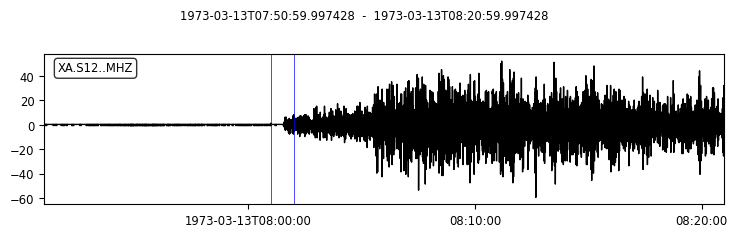

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


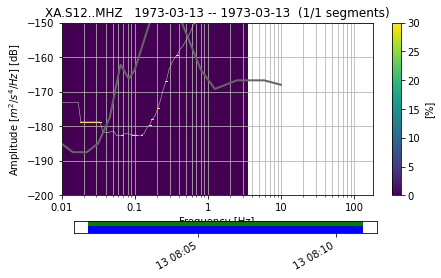

Largest Lunar Event: PPSD -156.85000000000002 (at 2.2)
1971-04-17T07:04:00.000000Z
Large Lunar Event
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107


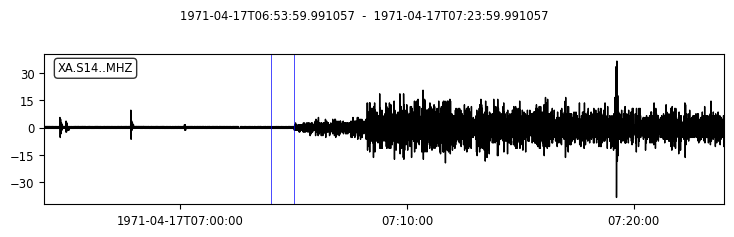

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


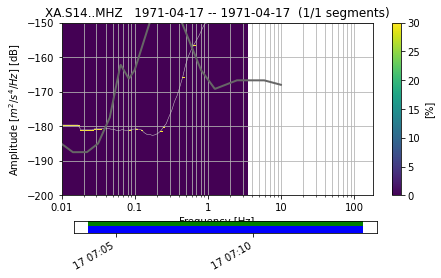

Large Lunar Event: PPSD -165.75 (at 2.2)
1973-07-23T01:14:00.000000Z
Medium Lunar Event
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204


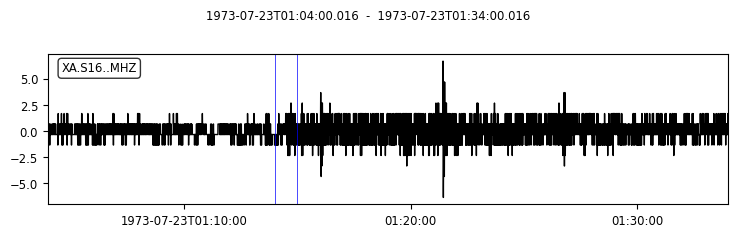

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


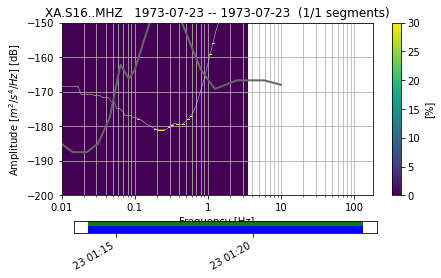

Medium Lunar Event: PPSD -179.35000000000002 (at 2.2)
1973-10-01T04:00:00.000000Z
Small Lunar Event
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.274


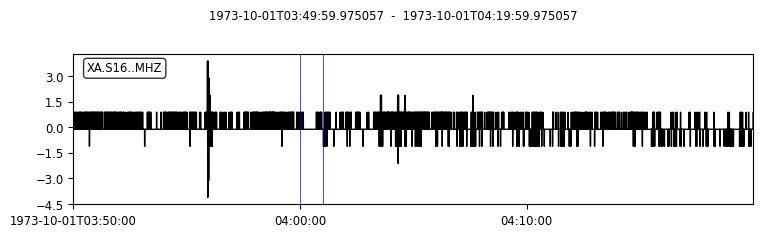

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


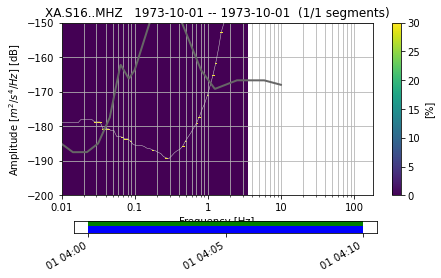

Small Lunar Event: PPSD -185.75 (at 2.2)
Successful count =  1


In [16]:
# These are the peaked events used in the plot 

ppsd_hours=1/6
seismograms = [
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', MUTED_ORANGE, 'Largest Lunar Event', 'solid',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event', 'solid',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
#     meteoroid? 
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event', 'solid',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
      [UTCDateTime('1973-10-01T04:00:00.000000Z'), 'S16', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'solid',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],  
]

# Sensible filtering for the peaked instrument 
# pre_filt=[0.2,0.3,0.9,1.3]
pre_filt=None
check_waveform_from_data(seismograms,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,
    plot_raw_waveform=True,plot_waveform=False,waveform_ylim=None, plot_instrument_removal=False,pre_filt=pre_filt,plot_ppsd=True,
    noise=False)

# CHECKED

b) Short-period events 


1973-03-13T08:01:00.000000Z
Largest Lunar Event (SP)
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/SHZ/S14.XA..SHZ.1973.72


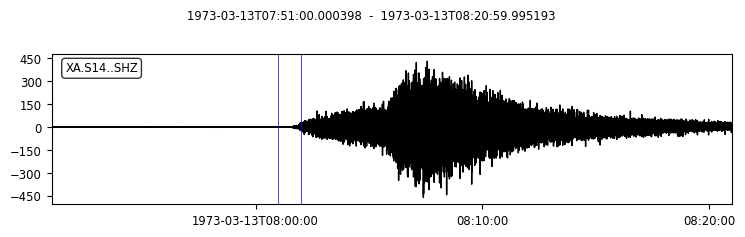

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 12.605041516806724 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


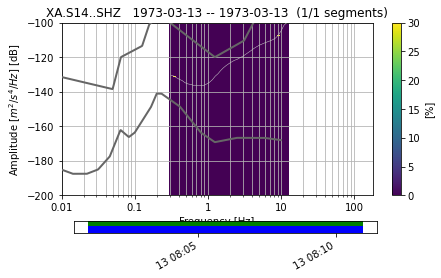

Largest Lunar Event (SP): PPSD -133.55 (at 2.2)
1971-04-17T07:04:00.000000Z
Large Lunar Event (SP)
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107


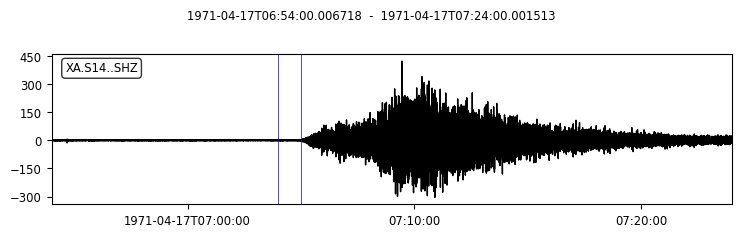

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 12.605041516806724 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


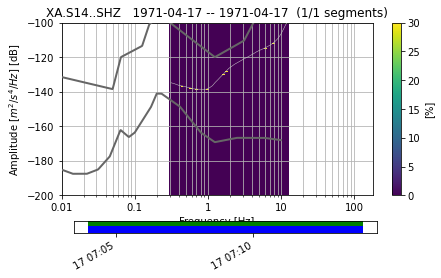

Large Lunar Event (SP): PPSD -136.64999999999998 (at 2.2)
1973-07-23T01:14:00.000000Z
Medium Lunar Event (SP)
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.204


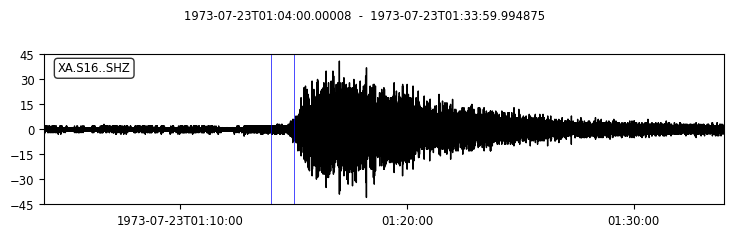

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 12.605041516806724 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


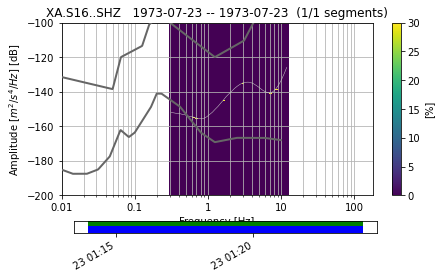

Medium Lunar Event (SP): PPSD -153.05 (at 2.2)
1973-10-01T04:00:00.000000Z
Small Lunar Event
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.274


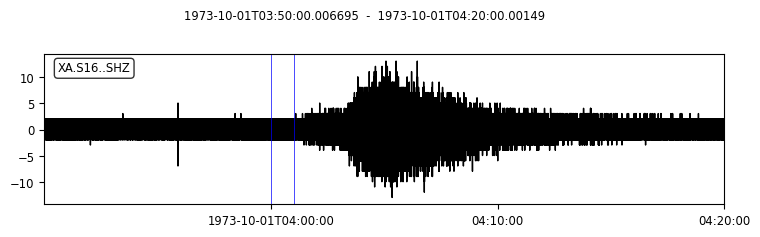

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 12.605041516806724 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


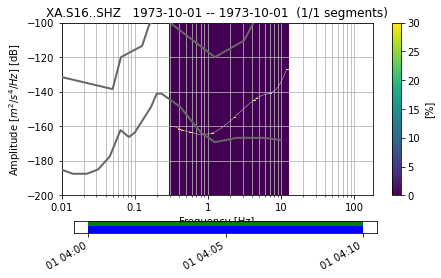

Small Lunar Event: PPSD -162.14999999999998 (at 2.2)
Successful count =  1


In [17]:
# these are the short-period events used in the plot

ppsd_hours=1/6
sp_seismograms = [
#     'Largest Lunar Event'
    [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S14', 'SHZ',  MUTED_ORANGE, 'Largest Lunar Event (SP)', 'dotted',(0.0833,3),(-200, -100, 0.1),600,ppsd_hours,2.2],
#     'Large Lunar Event'
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'SHZ',  MUTED_LIGHT_GREEN, 'Large Lunar Event (SP)', 'dotted',(0.0833,3),(-200, -100, 0.1),600,ppsd_hours,2.2],
    #     meteoroid? , 'Medium Lunar Event'
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'SHZ', MUTED_MID_GREEN, 'Medium Lunar Event (SP)', 'dotted',(0.0833,3),(-200, -100, 0.1),600,ppsd_hours,2.2],
#     'Small Lunar Event'
      [UTCDateTime('1973-10-01T04:00:00.000000Z'), 'S16', 'SHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'dotted',(0.0833,3),(-200, -100, 0.1),600,ppsd_hours,2.2], 
]


pre_filt=None
check_waveform_from_data(sp_seismograms,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,
    plot_raw_waveform=True,plot_waveform=False,waveform_ylim=None, plot_instrument_removal=False,pre_filt=pre_filt,plot_ppsd=True,
    noise=False)

# CHECKED

c) Flat examples 

1976-01-25T16:10:00.000000Z
Largest Lunar Event (flat)
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1976/S12/MHZ/S12.XA..MHZ.1976.25


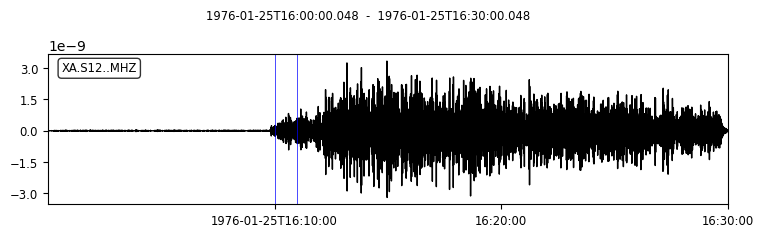

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


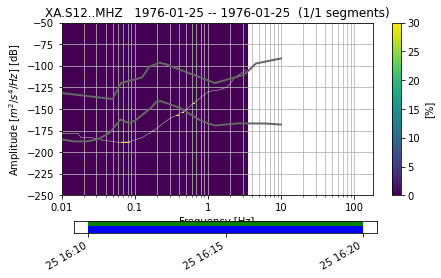

Largest Lunar Event (flat): PPSD -186.14999999999998 (at 10)
1976-03-06T10:16:00.000000Z
Large Lunar Event (flat)
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1976/S12/MHZ/S12.XA..MHZ.1976.66


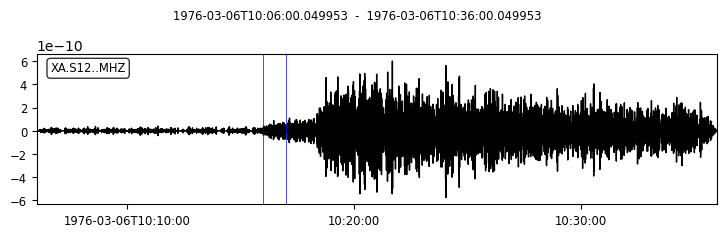

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


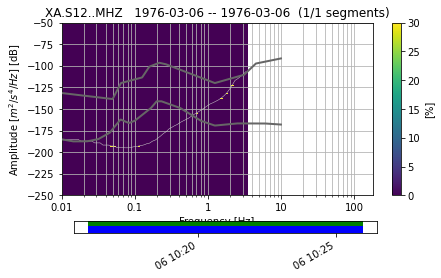

Large Lunar Event (flat): PPSD -193.85000000000002 (at 10)
1975-02-13T22:05:00.000000Z
Medium Lunar Event (flat)
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.44


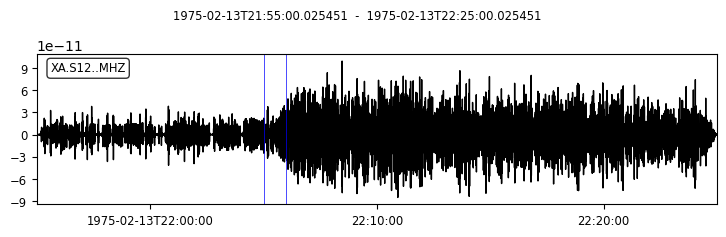

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


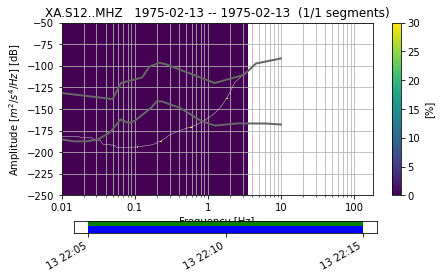

Medium Lunar Event (flat): PPSD -194.14999999999998 (at 10)
1975-01-12T03:21:00.000000Z
Small Lunar Event (flat)
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.12


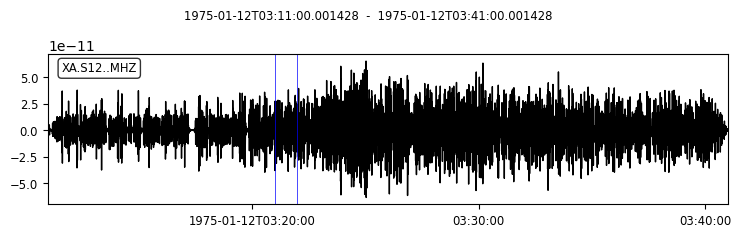

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


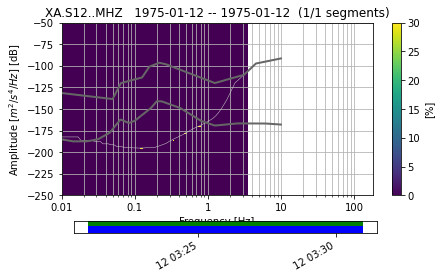

Small Lunar Event (flat): PPSD -195.05 (at 10)
Successful count =  1


In [18]:
# These are examples of flat events - aggressively filtered so that they are clearly visible 
# These were not used in the plot for 'Standing on Apollo’s Shoulders: a Microseismometer for the Moon'

# for the length of the PPSD
ppsd_hours=1/6
flat_seismograms = [
  [UTCDateTime('1976-01-25T16:10:00.000000Z'), 'S12', 'MHZ', MUTED_ORANGE, 'Largest Lunar Event (flat)', 'dashed',(0.3,100),(-250, -50, 0.1),600,ppsd_hours,10],
  [UTCDateTime('1976-03-06T10:16:00.000000Z'), 'S12', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event (flat)', 'dashed',(0.3,100),(-250, -50, 0.1),600,ppsd_hours,10],
  [UTCDateTime('1975-02-13T22:05:00.000000Z'), 'S12', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event (flat)', 'dashed',(0.3,100),(-250, -50, 0.1),600,ppsd_hours,10],
#     adjusting the catalog pick which is a bit late
  [UTCDateTime('1975-01-12T03:17:00.000000Z')+240., 'S12', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event (flat)', 'dashed',(0.3,100),(-250, -50, 0.1),600,ppsd_hours,10],
]


# pre_filt=None
pre_filt=[0.6,0.7,1.1,2]
check_waveform_from_data(flat_seismograms,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,
    plot_raw_waveform=False,plot_waveform=True,plot_instrument_removal=False,pre_filt=pre_filt,plot_ppsd=True,
    noise=False)

# CHECKED


1976-01-25T16:10:00.000000Z
Largest Lunar Event (flat)
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1976/S12/MHZ/S12.XA..MHZ.1976.25


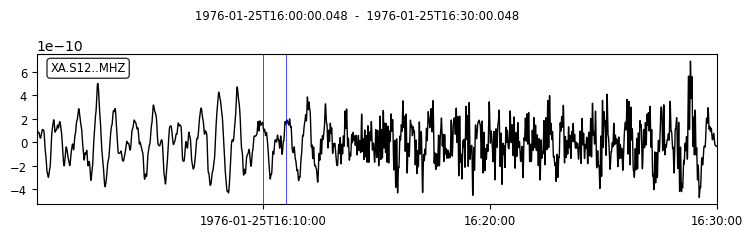

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


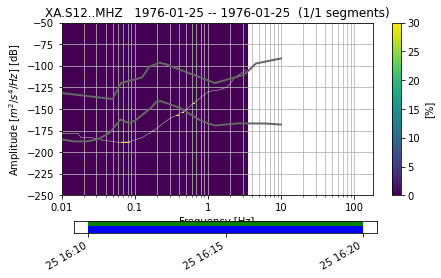

Largest Lunar Event (flat): PPSD -186.14999999999998 (at 10)
1976-03-06T10:16:00.000000Z
Large Lunar Event (flat)
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1976/S12/MHZ/S12.XA..MHZ.1976.66


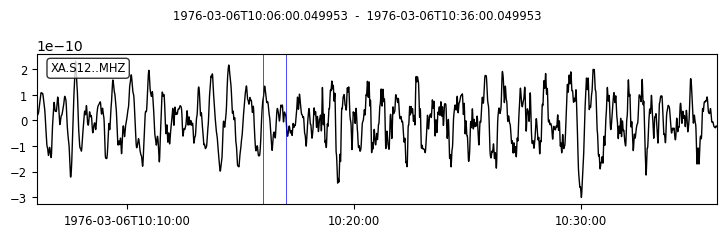

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


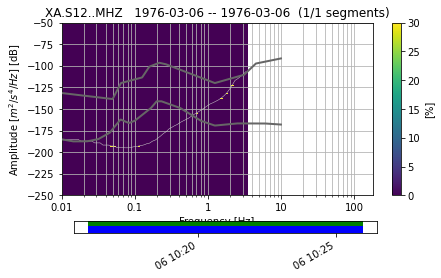

Large Lunar Event (flat): PPSD -193.85000000000002 (at 10)
1975-02-13T22:05:00.000000Z
Medium Lunar Event (flat)
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.44


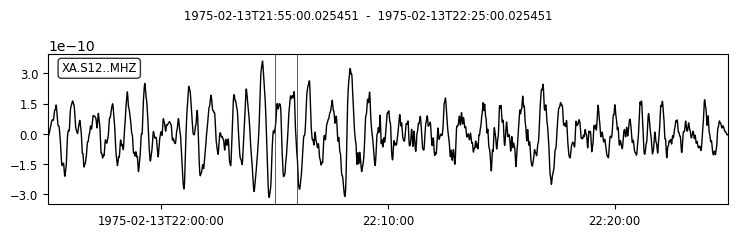

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


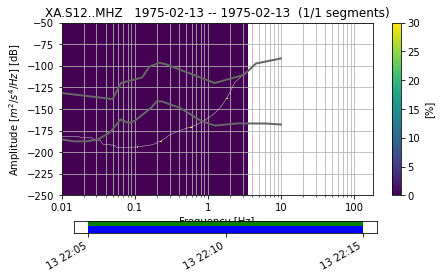

Medium Lunar Event (flat): PPSD -194.14999999999998 (at 10)
1975-01-12T03:21:00.000000Z
Small Lunar Event (flat)
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.12


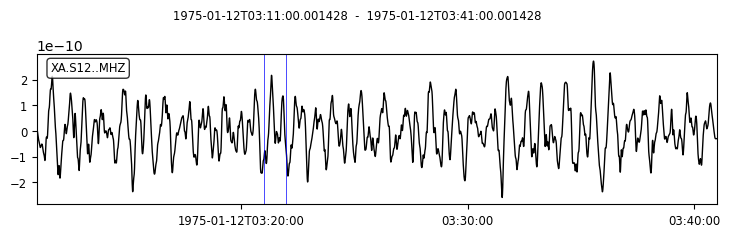

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


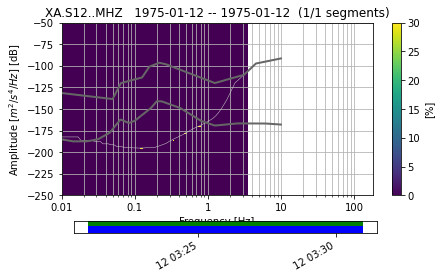

Small Lunar Event (flat): PPSD -195.05 (at 10)
Successful count =  1


In [19]:
# These are examples of flat events - (same as previous box) 
# These were not used in the plot for 'Standing on Apollo’s Shoulders: a Microseismometer for the Moon'
# - filtered where the instrument is technically most sensitive

# for the length of the PPSD
ppsd_hours=1/6
flat_seismograms = [
  [UTCDateTime('1976-01-25T16:10:00.000000Z'), 'S12', 'MHZ', MUTED_ORANGE, 'Largest Lunar Event (flat)', 'dashed',(0.3,100),(-250, -50, 0.1),600,ppsd_hours,10],
  [UTCDateTime('1976-03-06T10:16:00.000000Z'), 'S12', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event (flat)', 'dashed',(0.3,100),(-250, -50, 0.1),600,ppsd_hours,10],
  [UTCDateTime('1975-02-13T22:05:00.000000Z'), 'S12', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event (flat)', 'dashed',(0.3,100),(-250, -50, 0.1),600,ppsd_hours,10],
#     adjusting the catalog pick which is a bit late
  [UTCDateTime('1975-01-12T03:17:00.000000Z')+240., 'S12', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event (flat)', 'dashed',(0.3,100),(-250, -50, 0.1),600,ppsd_hours,10],
]


# these frequencies are where the instrument is technically most sensitive
pre_filt=[0.01,0.02,0.2,0.3]
check_waveform_from_data(flat_seismograms,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,
    plot_raw_waveform=False,plot_waveform=True,plot_instrument_removal=False,pre_filt=pre_filt,plot_ppsd=True,
    noise=False)

# CHECKED

# Section 3 - Noise examples for the peaked, short-period and flat instrument

## Section 3a - Noise examples from Fig 6b,c,d,e

simple_deglitch() will be applied.
1971-04-20T10:04:00.000000Z
Example of 10th percentile noise
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.110
Initial no. of samples: 23851, Final no. of samples: 23799


/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


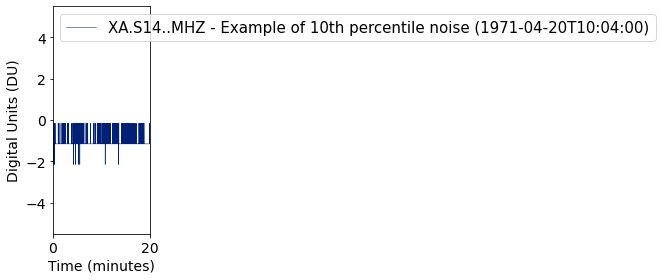

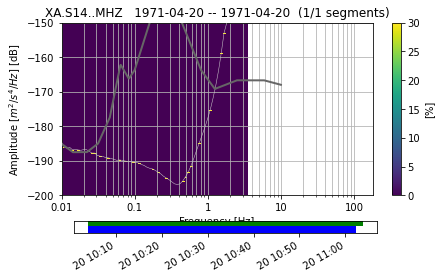

Example of 10th percentile noise: PPSD -195.85000000000002 (at 2.2)
1971-04-16T11:04:00.000000Z
Example of 50th percentile noise
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.106
Initial no. of samples: 23851, Final no. of samples: 23847


/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


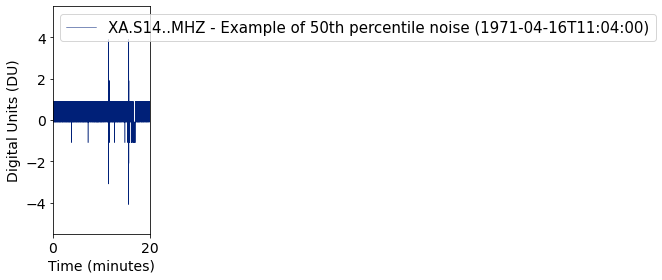

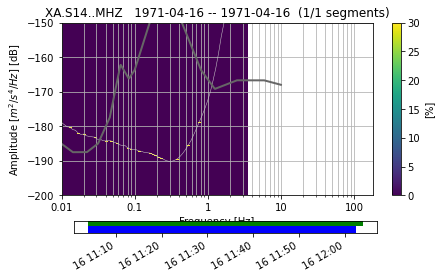

Example of 50th percentile noise: PPSD -187.85000000000002 (at 2.2)
1971-04-16T23:04:00.000000Z
Example of 90th percentile noise
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107


/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


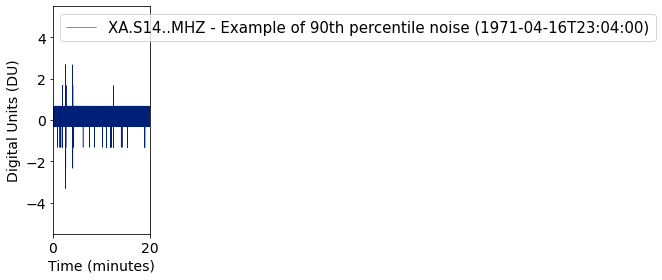

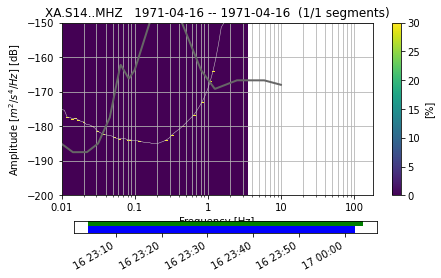

Example of 90th percentile noise: PPSD -179.95 (at 2.2)
1973-03-14T03:00:00.000000Z
Example of 10th percentile noise
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.73


/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


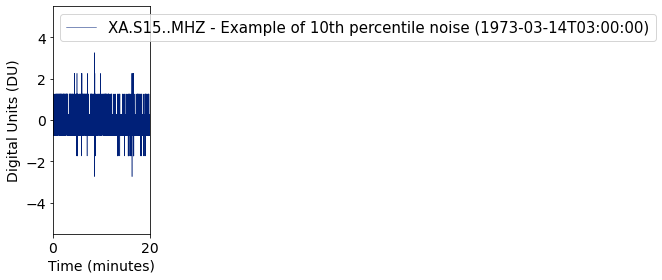

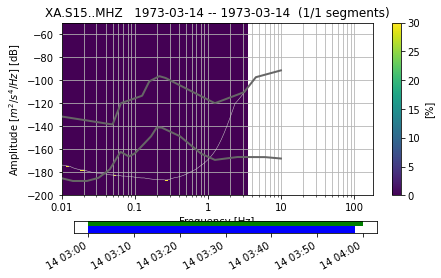

Example of 10th percentile noise: PPSD -182.85000000000002 (at 2.2)
1973-03-13T18:01:00.000000Z
Example of 50th percentile noise
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.72
Initial no. of samples: 23851, Final no. of samples: 23850


/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


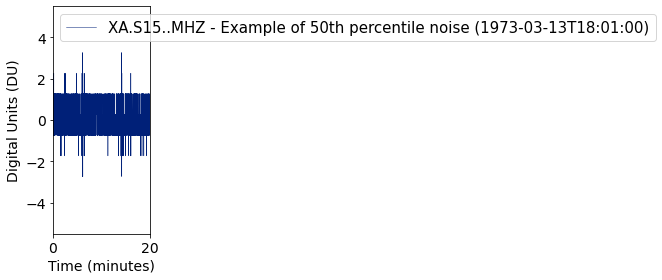

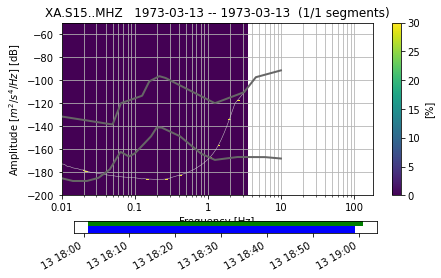

Example of 50th percentile noise: PPSD -181.55 (at 2.2)
1973-03-14T08:01:00.000000Z
Example of 90th percentile noise
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.73


/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


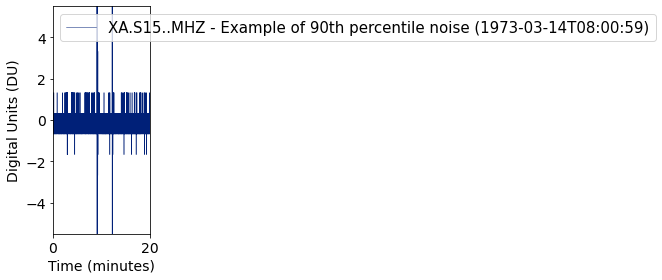

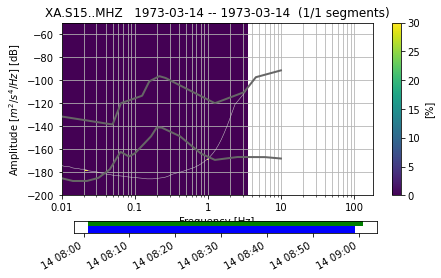

Example of 90th percentile noise: PPSD -179.14999999999998 (at 2.2)
[['1971-04-20T10:04:00.000000Z', 'S14', 'MHZ'], ['1971-04-16T11:04:00.000000Z', 'S14', 'MHZ'], ['1971-04-16T23:04:00.000000Z', 'S14', 'MHZ'], ['1973-03-14T03:00:00.000000Z', 'S15', 'MHZ'], ['1973-03-13T18:01:00.000000Z', 'S15', 'MHZ'], ['1973-03-14T08:01:00.000000Z', 'S15', 'MHZ']]
Successful count =  1


In [20]:

# Make the example noise figures 
ppsd_hours=1

# note that the deglitching removes some of the record, so we use 3500 s for the ppsd, instead of the
# full hour

noise_seismograms = [

#     peaked
    #  10%
#     [UTCDateTime(''), 'S14', 'MHZ',MUTED_BLUE, 'Example of 10th percentile noise','dotted',(0.3,100),(-200, -150, 0.1),3600,ppsd_hours,2.2],
    [UTCDateTime('1971-04-20T10:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, 'Example of 10th percentile noise','dotted',(0.3,100),(-200, -150, 0.1),3500,ppsd_hours,2.2],

    #  50 % 
    [UTCDateTime('1971-04-16T11:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, 'Example of 50th percentile noise','dotted',(0.3,100),(-200, -150, 0.1),3500,ppsd_hours,2.2],

#     90%
    [UTCDateTime('1971-04-16T23:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, 'Example of 90th percentile noise','dotted',(0.3,100),(-200, -150, 0.1),3500,ppsd_hours,2.2],


#     10%, S15 1973-03-14T03:01:00.000000Z -182.85
    [UTCDateTime('1973-03-14T03:00:00.000000Z'), 'S15', 'MHZ',MUTED_BLUE, 'Example of 10th percentile noise','solid',(0.3,100),(-200, -50, 0.1),3500,ppsd_hours,2.2],

#     50%, S15 1973-03-13T18:01:00.000000Z -181.65
    [UTCDateTime('1973-03-13T18:01:00.000000Z'), 'S15', 'MHZ',MUTED_LIGHT_BLUE, 'Example of 50th percentile noise','solid',(0.3,100),(-200, -50, 0.1),3500,ppsd_hours,2.2],

#     90%, S15 1973-03-14T08:01:00.000000Z -178.65
    [UTCDateTime('1973-03-14T08:01:00.000000'), 'S15', 'MHZ',MUTED_LIGHT_BLUE, 'Example of 90th percentile noise','solid',(0.3,100),(-200, -50, 0.1),3500,ppsd_hours,2.2],
]

pre_filt=None
check_waveform_from_data(noise_seismograms,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,
    plot_raw_waveform=False,raw_ylim=(-40,40),plot_raw_deglitched=False,save_raw_deglitched=True,deglitched_ylim=(-5.5,5.5),
    plot_waveform=False,plot_instrument_removal=False,pre_filt=pre_filt,plot_ppsd=True,
    noise=True,deglitch=True,waveform_length=1200)



simple_deglitch() will be applied.
1973-03-14T08:01:00.000000Z
Example of 90th percentile noise
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.73


/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


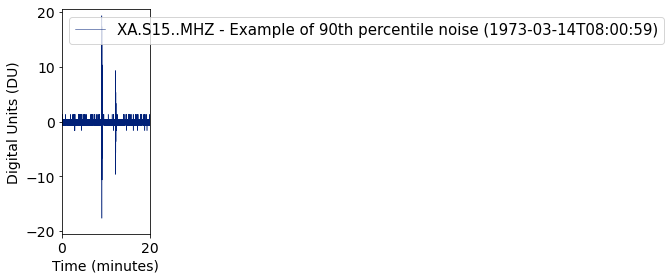

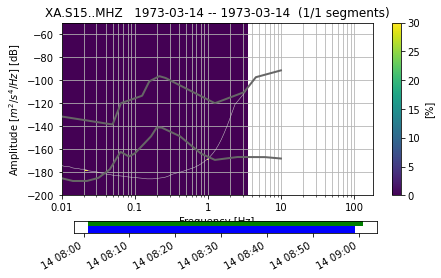

Example of 90th percentile noise: PPSD -179.14999999999998 (at 2.2)
[['1973-03-14T08:01:00.000000Z', 'S15', 'MHZ']]
Successful count =  1


In [21]:


# Make the example noise figures 
ppsd_hours=1

# note that the deglitching removes some of the record, so we use 3500 s for the ppsd, instead of the
# full hour

noise_seismograms = [


#     90%, S15 1973-03-14T08:01:00.000000Z -178.65
    [UTCDateTime('1973-03-14T08:01:00.000000'), 'S15', 'MHZ',MUTED_LIGHT_BLUE, 'Example of 90th percentile noise','solid',(0.3,100),(-200, -50, 0.1),3500,ppsd_hours,2.2],
]

pre_filt=None
check_waveform_from_data(noise_seismograms,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,
    plot_raw_waveform=False,raw_ylim=(-40,40),plot_raw_deglitched=False,save_raw_deglitched=True,deglitched_ylim=(-20.5,20.5),
    plot_waveform=False,plot_instrument_removal=False,pre_filt=pre_filt,plot_ppsd=True,
    noise=True,deglitch=True,waveform_length=1200)



In [22]:
## Section 3b - Plot some examples of different perentiles  

simple_deglitch() will be applied.
1971-04-20T10:04:00.000000Z
Apollo Noise (peaked) - 10th percentile
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.110


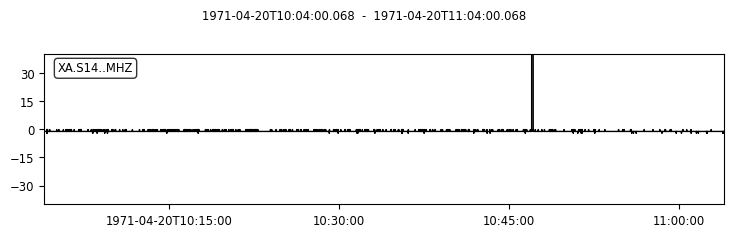

Initial no. of samples: 23851, Final no. of samples: 23799


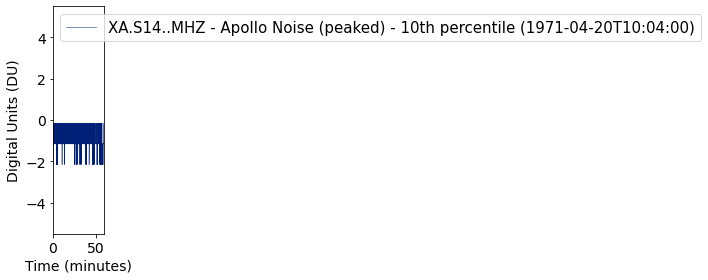

Initial no. of samples: 23851, Final no. of samples: 23799
Not found
1971-04-16T11:04:00.000000Z
Apollo Noise (peaked) - 50th percentile - 3+ digital units
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.106


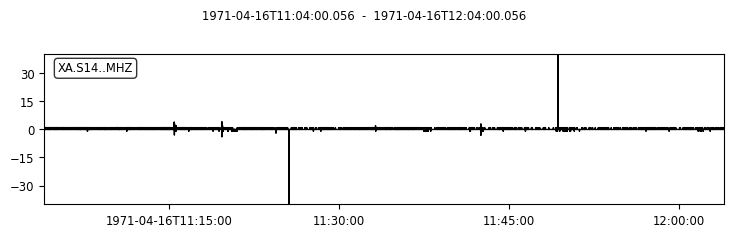

Initial no. of samples: 23851, Final no. of samples: 23847


/opt/anaconda3/envs/env36/lib/python3.6/site-packages/ipykernel_launcher.py:153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


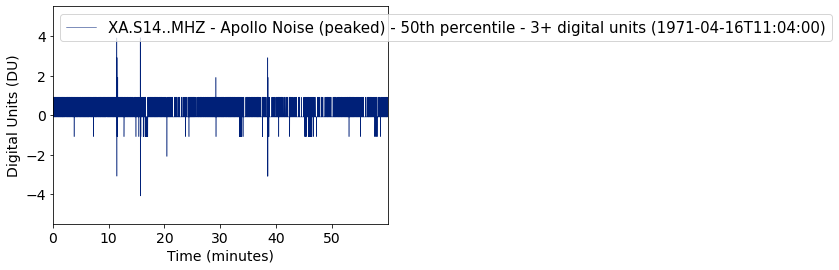

Initial no. of samples: 23851, Final no. of samples: 23847
Not found
1971-04-16T23:04:00.000000Z
Apollo Noise (peaked) - 90th percentile - 5 digital units
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107


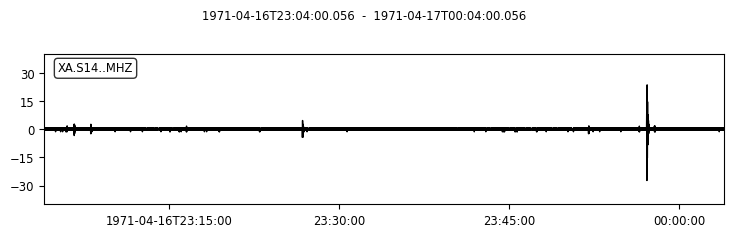

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/ipykernel_launcher.py:153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


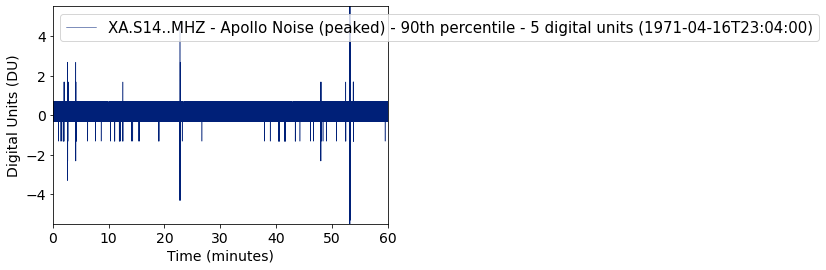

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


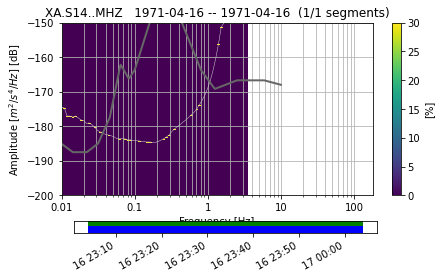

Apollo Noise (peaked) - 90th percentile - 5 digital units: PPSD -178.85000000000002 (at 2.2)
1971-04-23T20:04:00.000000Z
Apollo Noise (SP) - 10th percentile
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.113


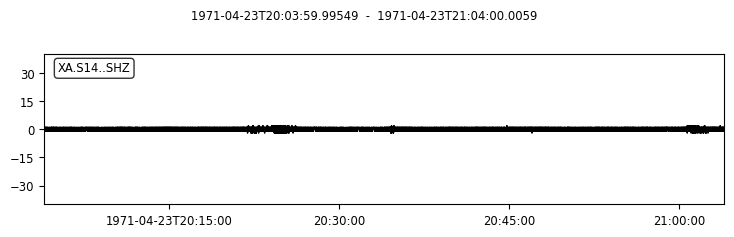

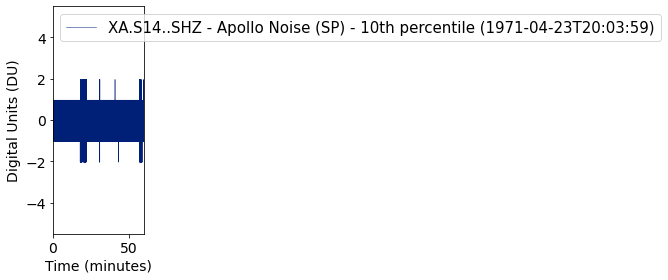

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


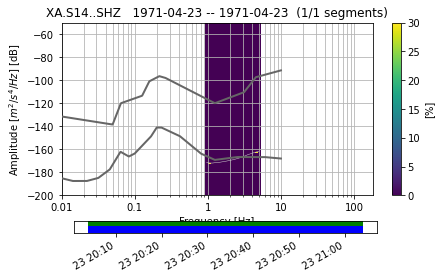

Apollo Noise (SP) - 10th percentile: PPSD -166.64999999999998 (at 0.33)
1971-04-18T12:04:00.000000Z
Apollo Noise (SP) - 50th percentile
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.108


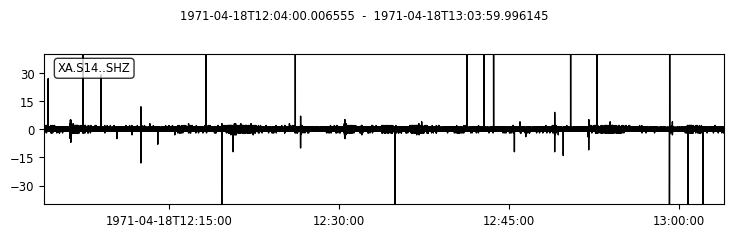

Initial no. of samples: 172913, Final no. of samples: 172886


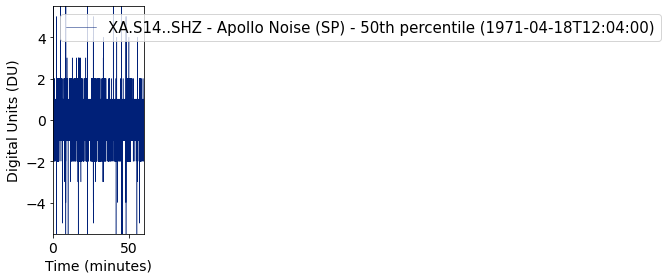

Initial no. of samples: 172913, Final no. of samples: 172886
Not found
1971-04-15T15:04:00.000000Z
Apollo Noise (SP) - 90th percentile
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.105


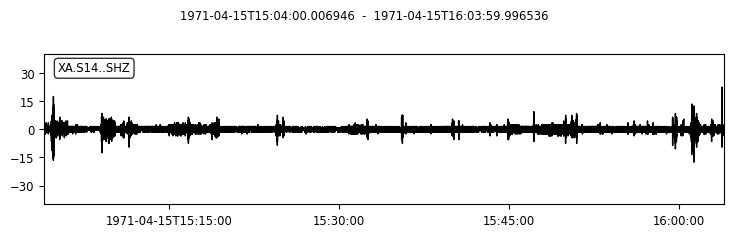

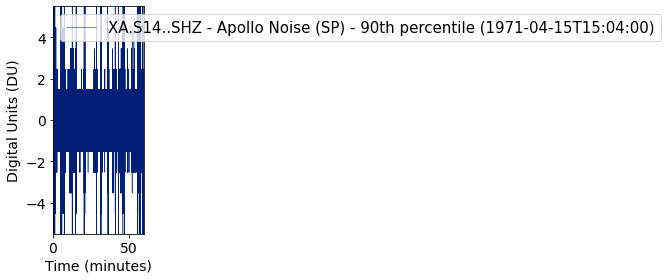

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


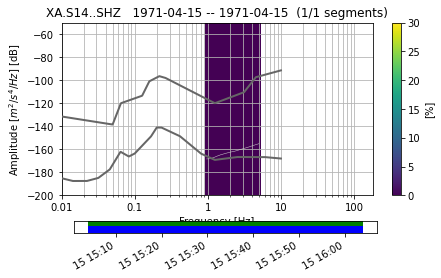

Apollo Noise (SP) - 90th percentile: PPSD -159.64999999999998 (at 0.33)
1975-01-12T13:17:00.000000Z
Apollo Noise (flat) - 10th percentile
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.12


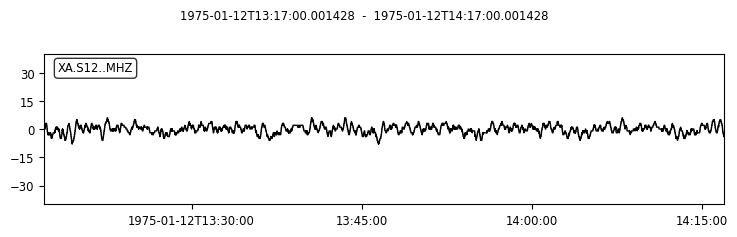

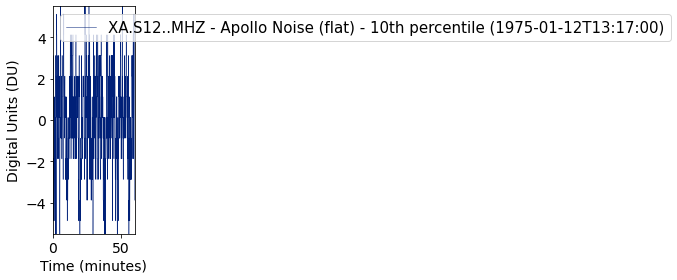

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


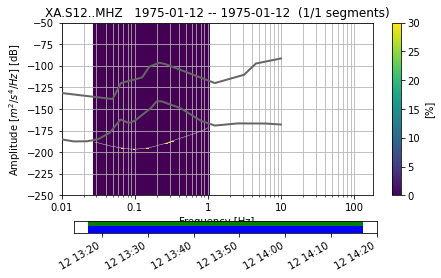

Apollo Noise (flat) - 10th percentile: PPSD -196.35000000000002 (at 10)
1975-01-15T17:17:00.000000Z
Apollo Noise (flat) - 50th percentile
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.15


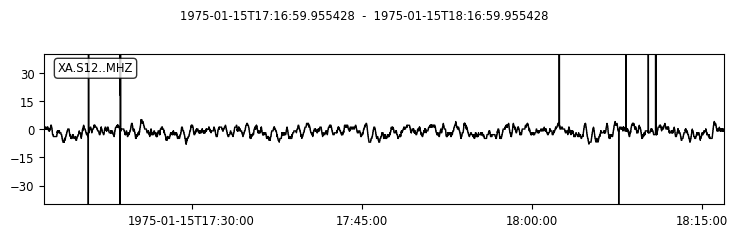

Initial no. of samples: 23851, Final no. of samples: 23779


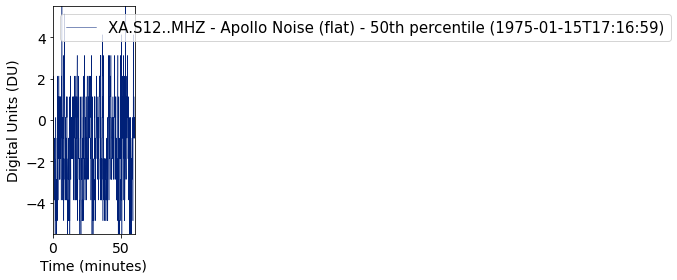

Initial no. of samples: 23851, Final no. of samples: 23779
Not found
1975-01-13T14:17:00.000000Z
Apollo Noise (peaked) - 90th percentile
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.13


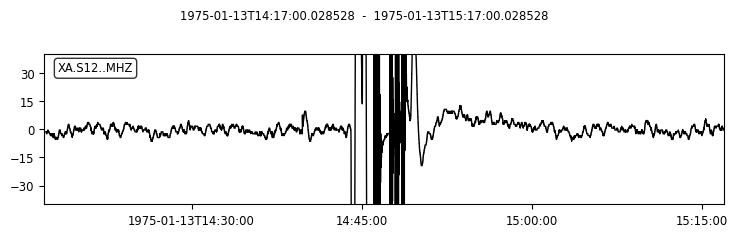

Initial no. of samples: 23851, Final no. of samples: 22472


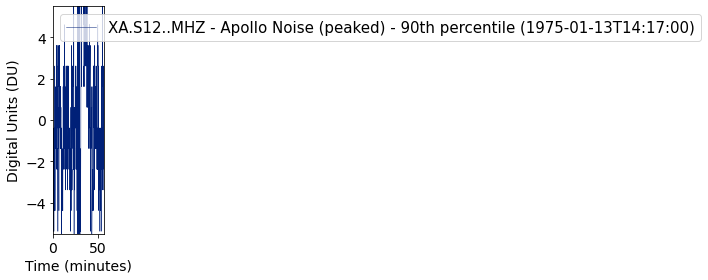

Initial no. of samples: 23851, Final no. of samples: 22472
Not found
1973-03-14T03:00:00.000000Z
Example of 10th percentile noise
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.73


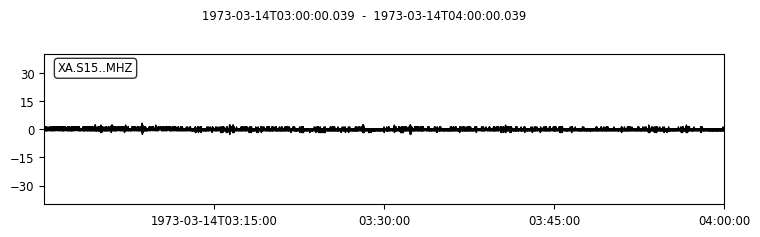

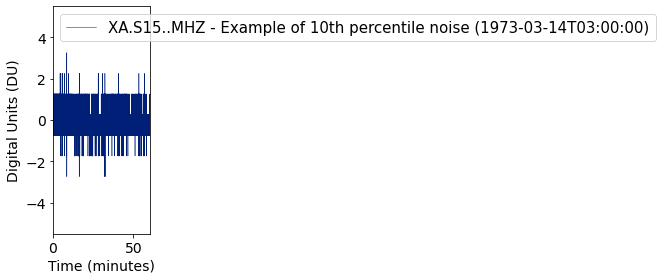

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


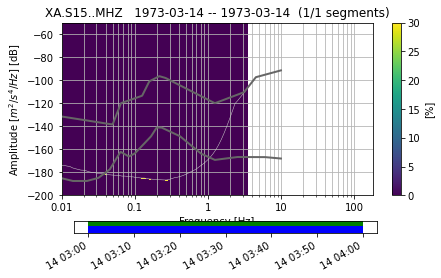

Example of 10th percentile noise: PPSD -182.85000000000002 (at 2.2)
1973-03-13T18:01:00.000000Z
Apollo Noise (peaked) - 50th percentile
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.72


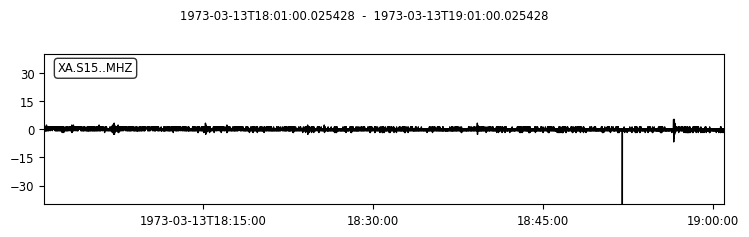

Initial no. of samples: 23851, Final no. of samples: 23850


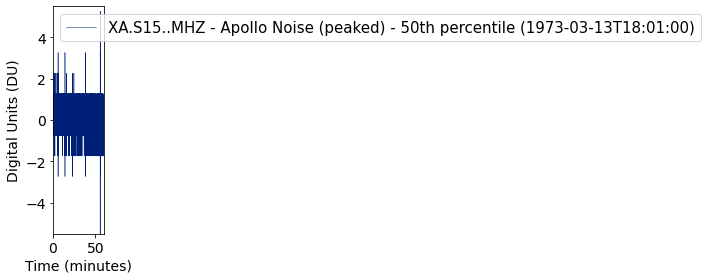

Initial no. of samples: 23851, Final no. of samples: 23850


/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


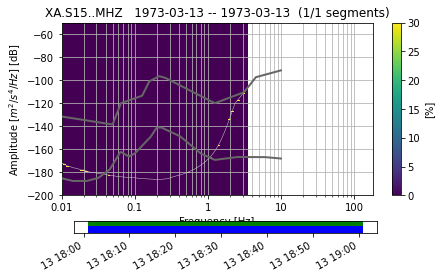

Apollo Noise (peaked) - 50th percentile: PPSD -181.55 (at 2.2)
1973-03-14T08:01:00.000000Z
Apollo Noise (peaked) - 90th percentile
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.73


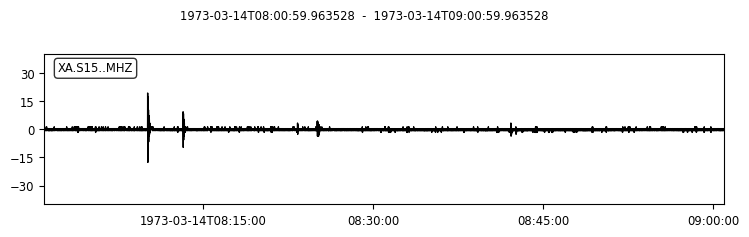

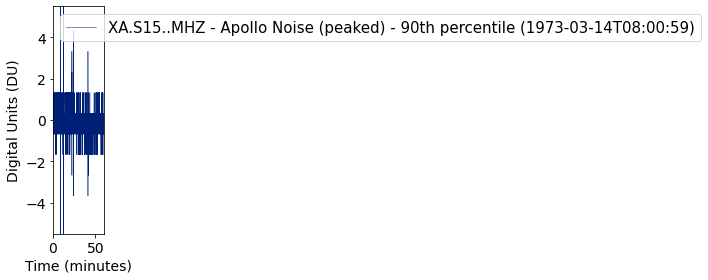

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


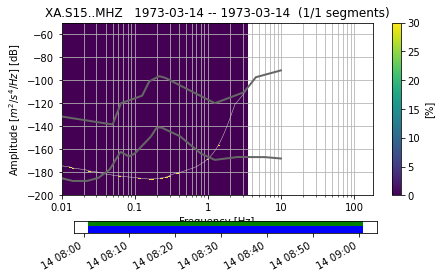

Apollo Noise (peaked) - 90th percentile: PPSD -179.35000000000002 (at 2.2)
[['1971-04-20T10:04:00.000000Z', 'S14', 'MHZ'], ['1971-04-16T11:04:00.000000Z', 'S14', 'MHZ'], ['1971-04-16T23:04:00.000000Z', 'S14', 'MHZ'], ['1971-04-23T20:04:00.000000Z', 'S14', 'SHZ'], ['1971-04-18T12:04:00.000000Z', 'S14', 'SHZ'], ['1971-04-15T15:04:00.000000Z', 'S14', 'SHZ'], ['1975-01-12T13:17:00.000000Z', 'S12', 'MHZ'], ['1975-01-15T17:17:00.000000Z', 'S12', 'MHZ'], ['1975-01-13T14:17:00.000000Z', 'S12', 'MHZ'], ['1973-03-14T03:00:00.000000Z', 'S15', 'MHZ'], ['1973-03-13T18:01:00.000000Z', 'S15', 'MHZ'], ['1973-03-14T08:01:00.000000Z', 'S15', 'MHZ']]
Successful count =  1


In [23]:
# Plot some examples of different perentiles  
ppsd_hours=1
noise_seismograms = [
    
#     peaked
    

#     Very low noise example, but with some glitches, which seem to contaminate it 
#     Example from Philippe - just before an event
#     [UTCDateTime('1972-12-15T02:45:40'), 'S14', 'MHZ',MUTED_BLUE, 'Apollo Noise (peaked) ????','dotted',(0.3,100),(-200, -150, 0.1),3000,ppsd_hours,2.2],

    
# #     Example from Philippe - just before an 
#      [UTCDateTime('1972-12-15T06:39:29'), 'S14', 'MHZ',MUTED_BLUE, 'Example of 10th percentile noise ????','dotted',(0.3,100),(-200, -150, 0.1),3000,ppsd_hours,2.2],

    
    #  10%
    [UTCDateTime('1971-04-20T10:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, 'Apollo Noise (peaked) - 10th percentile','dotted',(0.3,100),(-200, -150, 0.1),3600,ppsd_hours,2.2],

    #  50 % 
    [UTCDateTime('1971-04-16T11:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, 'Apollo Noise (peaked) - 50th percentile - 3+ digital units','dotted',(0.3,100),(-200, -150, 0.1),3600,ppsd_hours,2.2],

#     90%
    [UTCDateTime('1971-04-16T23:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, 'Apollo Noise (peaked) - 90th percentile - 5 digital units','dotted',(0.3,100),(-200, -150, 0.1),3600,ppsd_hours,2.2],

    
#     SHZ
#       10 %
      [UTCDateTime('1971-04-23T20:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, 'Apollo Noise (SP) - 10th percentile','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],

#       50 %
      [UTCDateTime('1971-04-18T12:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, 'Apollo Noise (SP) - 50th percentile','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],

    #       90 %
      [UTCDateTime('1971-04-15T15:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, 'Apollo Noise (SP) - 90th percentile','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],

#     Flat 
#     10%
      [UTCDateTime('1975-01-12T13:17:00.000000Z'), 'S12', 'MHZ',MUTED_LIGHT_BLUE, 'Apollo Noise (flat) - 10th percentile','solid',(1,33),(-250, -50, 0.1),3600,ppsd_hours,10],
    
#     50%
    [UTCDateTime('1975-01-15T17:17:00.000000Z'), 'S12', 'MHZ',MUTED_LIGHT_BLUE, 'Apollo Noise (flat) - 50th percentile','solid',(1,33),(-250, -50, 0.1),3600,ppsd_hours,10],
    
#     horribly glitchy example, where deglitching algorithm didn't work 
#     90%
    [UTCDateTime('1975-01-13T14:17:00.000000Z'), 'S12', 'MHZ',MUTED_LIGHT_BLUE, 'Apollo Noise (peaked) - 90th percentile','solid',(1,33),(-250, -50, 0.1),3600,ppsd_hours,10],

#     10%, S15 1973-03-14T03:01:00.000000Z -182.85
    [UTCDateTime('1973-03-14T03:00:00.000000Z'), 'S15', 'MHZ',MUTED_BLUE, 'Example of 10th percentile noise','solid',(0.3,100),(-200, -50, 0.1),3600,ppsd_hours,2.2],

#     50%, S15 1973-03-13T18:01:00.000000Z -181.65
    [UTCDateTime('1973-03-13T18:01:00.000000Z'), 'S15', 'MHZ',MUTED_LIGHT_BLUE, 'Apollo Noise (peaked) - 50th percentile','solid',(0.3,100),(-200, -50, 0.1),3600,ppsd_hours,2.2],

#     90%, S15 1973-03-14T08:01:00.000000Z -178.65
    [UTCDateTime('1973-03-14T08:01:00.000000'), 'S15', 'MHZ',MUTED_LIGHT_BLUE, 'Apollo Noise (peaked) - 90th percentile','solid',(0.3,100),(-200, -50, 0.1),3600,ppsd_hours,2.2],
 
]

pre_filt=None
check_waveform_from_data(noise_seismograms,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,
    plot_raw_waveform=True,raw_ylim=(-40,40),plot_raw_deglitched=True,save_raw_deglitched=False,deglitched_ylim=(-5.5,5.5),
    plot_waveform=False,plot_instrument_removal=False,pre_filt=pre_filt,plot_ppsd=True,
    noise=True,deglitch=True)

# This script will plot the original traces and the deglitched ones. 

# Section 4 - An example of an event which visible on the short-period instrument, but not on the peaked instrument 

1974-04-19T13:39:00.000000Z
Small Lunar Event
Options for ppsd are missing
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1974/S16/MHZ/S16.XA..MHZ.1974.109


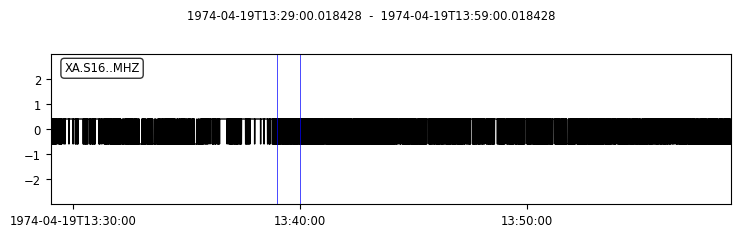

Successful count =  1


In [24]:
# This is an example of an event which is clearly visible on the short-period instrument, but not visisble on the 
# peaked instrument - note is picked approximately 1 min late
# classed as a shallow moonquake in the Nakamura catalog


seismograms = [
        [UTCDateTime('1974-04-19T13:39:00.000000Z'), 'S16', 'MHZ', 'red', 'Small Lunar Event', 'solid'], 
  ]


pre_filt=None
check_waveform_from_data(seismograms,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,
    plot_raw_waveform=True,raw_ylim=(-3,3),plot_waveform=False,waveform_ylim=None, plot_instrument_removal=False,pre_filt=pre_filt,plot_ppsd=False,
    noise=False)

# CHECKED

1974-04-19T13:39:00.000000Z
Small Lunar Event
Options for ppsd are missing
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1974/S16/SHZ/S16.XA..SHZ.1974.109


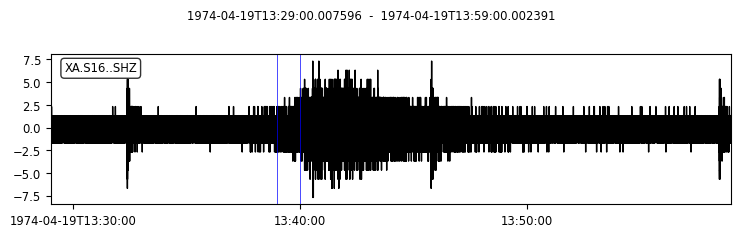

Successful count =  1


In [25]:
# This is an example of an event which is clearly visible on the short-period instrument, but not visisble on the 
# peaked instrument - note is picked approximately 1 min late
# classed as a shallow moonquake in the Nakamura catalog


seismograms = [
        [UTCDateTime('1974-04-19T13:39:00.000000Z'), 'S16', 'SHZ', 'red', 'Small Lunar Event', 'solid'], 
  ]

# Sensible filtering for the peaked instrument 
pre_filt=[0.2,0.3,0.9,1.3]
check_waveform_from_data(seismograms,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,
    plot_raw_waveform=True,plot_waveform=False,waveform_ylim=None, plot_instrument_removal=False,pre_filt=pre_filt,plot_ppsd=False,
    noise=False)

# CHECKED

# Section 5 - Comparing horizontal and vertical 

1973-03-13T08:01:00.000000Z
Large Lunar Event - Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72


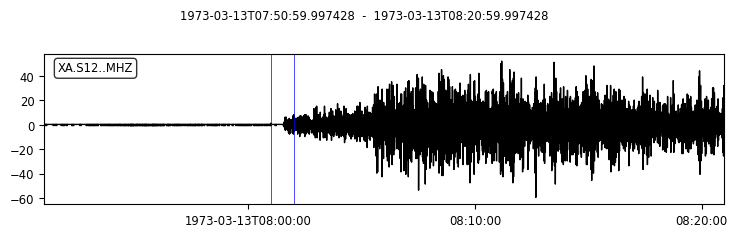

1973-03-13T08:01:00.000000Z
Large Lunar Event - 1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH1/S12.XA..MH1.1973.72


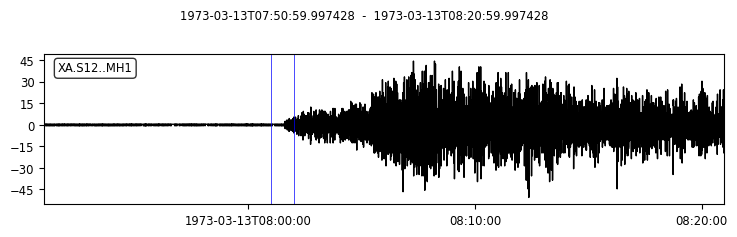

1973-03-13T08:01:00.000000Z
Large Lunar Event - 2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH2/S12.XA..MH2.1973.72


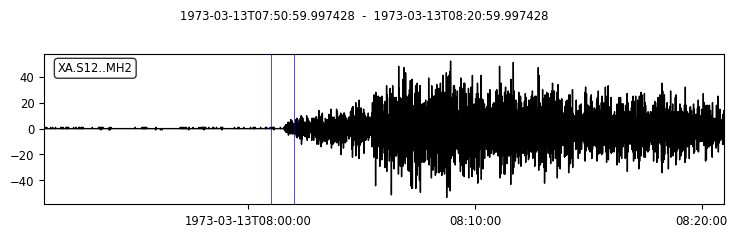

1973-02-05T20:59:00.000000Z
Meteoroid Impact - Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.36


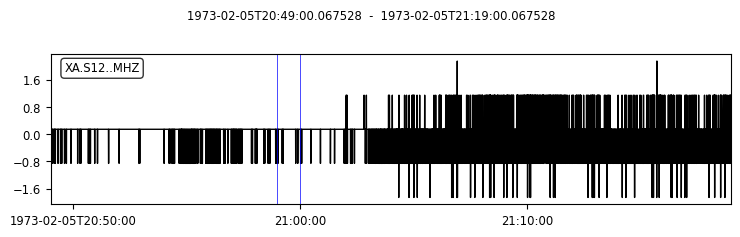

1973-02-05T20:59:00.000000Z
Meteoroid Impact - 1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH1/S12.XA..MH1.1973.36


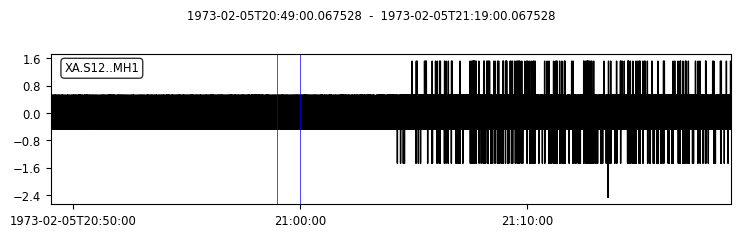

1973-02-05T20:59:00.000000Z
Meteoroid Impact - 2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH2/S12.XA..MH2.1973.36


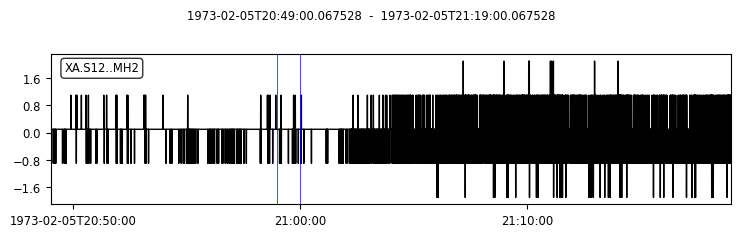

1973-01-03T22:48:00.000000Z
Apollo Instrument Noise - Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.3


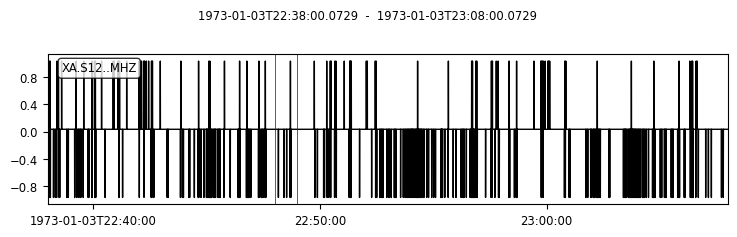

1973-01-03T22:48:00.000000Z
Apollo Instrument Noise - 1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH1/S12.XA..MH1.1973.3


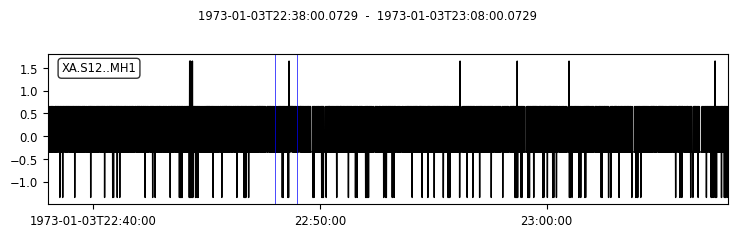

1973-01-03T22:48:00.000000Z
Apollo Instrument Noise - 2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH2/S12.XA..MH2.1973.3


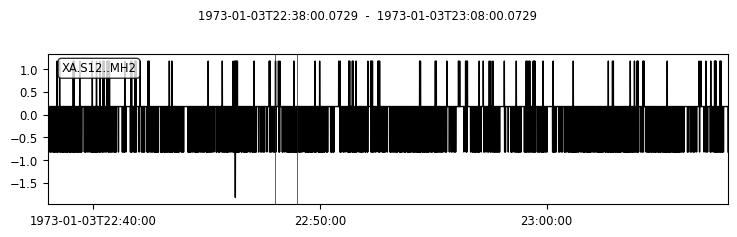

Successful count =  1


In [26]:
# viewing the difference between the horizontal and vertical components - 3 examples 

ppsd_hours=1/6
three_components=[
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', 'navy', 'Large Lunar Event - Z', 'solid',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MH1', 'navy', 'Large Lunar Event - 1','dashed',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MH2', 'navy', 'Large Lunar Event - 2','dotted',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
    
  [UTCDateTime('1973-02-05T20:59:00.000000Z'), 'S12', 'MHZ', 'royalblue', 'Meteoroid Impact - Z','solid',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
  [UTCDateTime('1973-02-05T20:59:00.000000Z'), 'S12', 'MH1', 'royalblue', 'Meteoroid Impact - 1','dashed',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
  [UTCDateTime('1973-02-05T20:59:00.000000Z'), 'S12', 'MH2', 'royalblue', 'Meteoroid Impact - 2','dotted',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
    
  [UTCDateTime('1973-01-03T22:48:00.000000Z'), 'S12', 'MHZ', 'skyblue', 'Apollo Instrument Noise - Z','solid',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
  [UTCDateTime('1973-01-03T22:48:00.000000Z'), 'S12', 'MH1', 'skyblue', 'Apollo Instrument Noise - 1','dashed',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
  [UTCDateTime('1973-01-03T22:48:00.000000Z'), 'S12', 'MH2', 'skyblue', 'Apollo Instrument Noise - 2','dotted',(0.3,100),(-200, -150, 0.1),600,ppsd_hours,2.2],
    
]

pre_filt=None
check_waveform_from_data(three_components,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,
    plot_raw_waveform=True,plot_waveform=False,plot_instrument_removal=False,pre_filt=pre_filt,plot_ppsd=False,
    noise=False)

# CHECKED

# Section 6 - Catalog events accepted for the histograms

We analayzed the events, to find events with at least 2.5 signal-to-noise ratio.

In [27]:
S12_shallow_events = [
    # catalogs/S12_shallow.xml
    'smi:nakamura81/event/01122',
    'smi:nakamura81/event/01264',
    'smi:nakamura81/event/01555',
    'smi:nakamura81/event/06051',
    'smi:nakamura81/event/06567',
    'smi:nakamura81/event/08269',
    'smi:nakamura81/event/09287'
    ]
save_tmp_selected_events('tmp_selected_events/S12_shallow_events.txt', S12_shallow_events)

S12_met_1973_events = [
    # catalogs/1973_S12_met.xml
    'smi:nakamura81/event/05756',
    'smi:nakamura81/event/05853',
    'smi:nakamura81/event/05953',
    'smi:nakamura81/event/06048',
    'smi:nakamura81/event/06100',
    'smi:nakamura81/event/06122',
    'smi:nakamura81/event/06137',
    'smi:nakamura81/event/06142',
    'smi:nakamura81/event/06168',
    'smi:nakamura81/event/06263',
    'smi:nakamura81/event/06382',
    'smi:nakamura81/event/06538',
    'smi:nakamura81/event/06545',
    'smi:nakamura81/event/06569',
    'smi:nakamura81/event/06620',
    'smi:nakamura81/event/06662',
    'smi:nakamura81/event/06802',
    'smi:nakamura81/event/06858',
    'smi:nakamura81/event/06910',
    'smi:nakamura81/event/06938',
    'smi:nakamura81/event/07073',
    'smi:nakamura81/event/07257',
    'smi:nakamura81/event/07338',
    'smi:nakamura81/event/07360'
    ]
save_tmp_selected_events('tmp_selected_events/S12_met_1973_events.txt', S12_met_1973_events)


S12_deep_1973_events = [
    #catalogs/1973_S12_deep.xml
    'smi:nakamura81/event/05619',
    'smi:nakamura81/event/05670',
    'smi:nakamura81/event/05697',
    'smi:nakamura81/event/05725',
    'smi:nakamura81/event/05748',
    'smi:nakamura81/event/05752',
    'smi:nakamura81/event/05764',
    'smi:nakamura81/event/05801',
    'smi:nakamura81/event/05830',
    'smi:nakamura81/event/05858',
    'smi:nakamura81/event/05888',
    'smi:nakamura81/event/05914',
    'smi:nakamura81/event/06027',
    'smi:nakamura81/event/06039',
    'smi:nakamura81/event/06135',
    'smi:nakamura81/event/06144',
    'smi:nakamura81/event/06181',
    'smi:nakamura81/event/06261',
    'smi:nakamura81/event/06277',
    'smi:nakamura81/event/06336',
    'smi:nakamura81/event/06359',
    'smi:nakamura81/event/06474',
    'smi:nakamura81/event/06497',
    'smi:nakamura81/event/06524',
    'smi:nakamura81/event/06572',
    'smi:nakamura81/event/06598',
    'smi:nakamura81/event/06612',
    'smi:nakamura81/event/06623',
    'smi:nakamura81/event/06658',
    'smi:nakamura81/event/06745',
    'smi:nakamura81/event/06767',
    'smi:nakamura81/event/06770',
    'smi:nakamura81/event/06771',
    'smi:nakamura81/event/06785',
    'smi:nakamura81/event/06897',
    'smi:nakamura81/event/06911',
    'smi:nakamura81/event/06913',
    'smi:nakamura81/event/06922',
    'smi:nakamura81/event/06927',
    'smi:nakamura81/event/07055',
    'smi:nakamura81/event/07068',
    'smi:nakamura81/event/07075',
    'smi:nakamura81/event/07207',
    'smi:nakamura81/event/07239',
    'smi:nakamura81/event/07244',
    'smi:nakamura81/event/07277',
    'smi:nakamura81/event/07291',
    'smi:nakamura81/event/07334',
    'smi:nakamura81/event/07350',
    'smi:nakamura81/event/07351',
    'smi:nakamura81/event/07417'
    ]
save_tmp_selected_events('tmp_selected_events/S12_deep_1973_events.txt', S12_deep_1973_events)




# Section 7 - View any of the events in the catalogs


In [28]:
# S12, MHZ

0 smi:nakamura81/event/01122
P  1971-04-17T07:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S12/MHZ/S12.XA..MHZ.1971.107


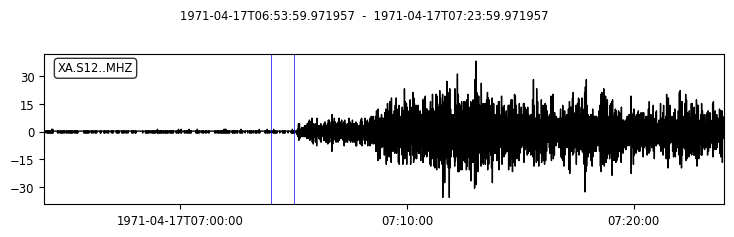

1 smi:nakamura81/event/01264
P  1971-05-20T17:29:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S12/MHZ/S12.XA..MHZ.1971.140


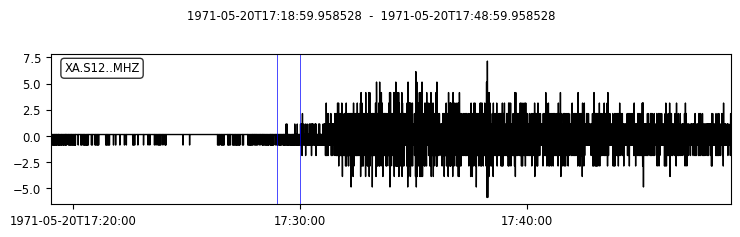

2 smi:nakamura81/event/01555
P  1971-07-11T13:27:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S12/MHZ/S12.XA..MHZ.1971.192


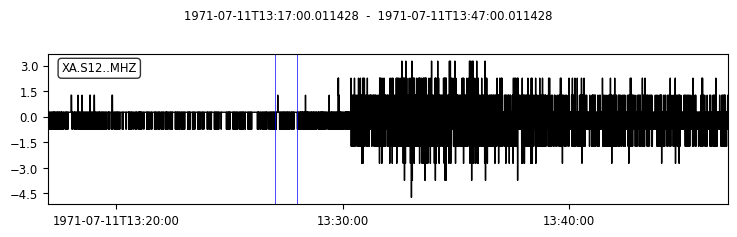

3 smi:nakamura81/event/02616
P  1972-01-02T22:32:00.000000Z
Event is not in list of accepted events
4 smi:nakamura81/event/05446
P  1972-12-06T23:10:00.000000Z
Event is not in list of accepted events
5 smi:nakamura81/event/05469
P  1972-12-09T03:52:00.000000Z
Event is not in list of accepted events
6 smi:nakamura81/event/05861
P  1973-02-08T22:53:00.000000Z
Event is not in list of accepted events
7 smi:nakamura81/event/06051
P  1973-03-13T08:01:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72


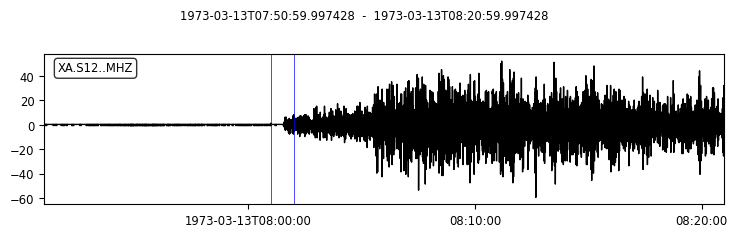

8 smi:nakamura81/event/06567
P  1973-06-20T20:25:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.171


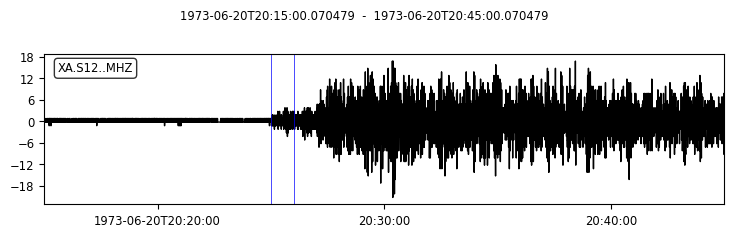

9 smi:nakamura81/event/07098
P  1973-10-01T04:00:00.000000Z
Event is not in list of accepted events
10 smi:nakamura81/event/07746
P  1974-02-23T21:17:00.000000Z
Event is not in list of accepted events
11 smi:nakamura81/event/07913
P  1974-03-27T09:11:00.000000Z
Event is not in list of accepted events
12 smi:nakamura81/event/07980
P  1974-04-19T13:39:00.000000Z
Event is not in list of accepted events
13 smi:nakamura81/event/08269
P  1974-07-11T00:52:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1974/S12/MHZ/S12.XA..MHZ.1974.192


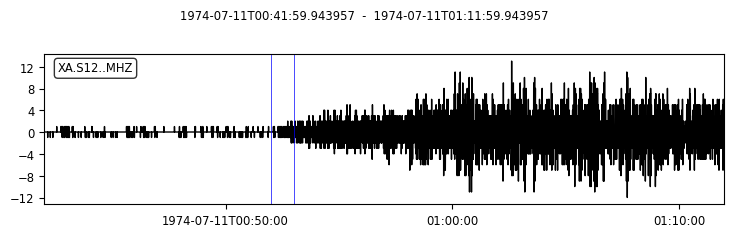

14 smi:nakamura81/event/08889
P  1975-01-03T01:47:00.000000Z
Event is not in list of accepted events
15 smi:nakamura81/event/08913
P  1975-01-12T03:17:00.000000Z
Event is not in list of accepted events
16 smi:nakamura81/event/08916
P  1975-01-13T00:28:00.000000Z
Event is not in list of accepted events
17 smi:nakamura81/event/09013
P  1975-02-13T22:05:00.000000Z
Event is not in list of accepted events
18 smi:nakamura81/event/09231
P  1975-05-07T06:40:00.000000Z
Event is not in list of accepted events
19 smi:nakamura81/event/09287
P  1975-05-27T23:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.147


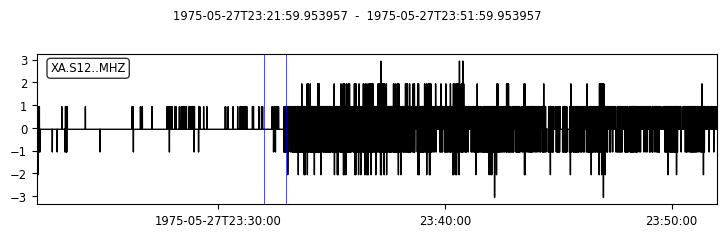

20 smi:nakamura81/event/09806
P  1975-11-10T07:56:00.000000Z
Event is not in list of accepted events
21 smi:nakamura81/event/10171
P  1976-03-06T10:16:00.000000Z
Event is not in list of accepted events
22 smi:nakamura81/event/10184
P  1976-03-08T14:44:00.000000Z
Event is not in list of accepted events
23 smi:nakamura81/event/10500
P  1976-05-16T12:36:00.000000Z
Event is not in list of accepted events
Successful count =  7
0 smi:nakamura81/event/05648
P  1973-01-03T23:48:00.000000Z
Event is not in list of accepted events
1 smi:nakamura81/event/05679
P  1973-01-07T02:02:00.000000Z
Event is not in list of accepted events
2 smi:nakamura81/event/05756
P  1973-01-18T23:01:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.18


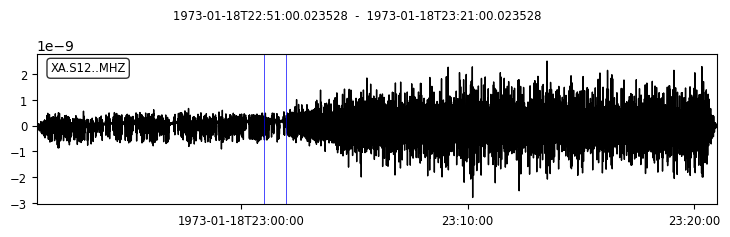

3 smi:nakamura81/event/05757
P  1973-01-18T23:59:00.000000Z
Event is not in list of accepted events
4 smi:nakamura81/event/05788
P  1973-01-24T23:43:00.000000Z
Event is not in list of accepted events
5 smi:nakamura81/event/05790
P  1973-01-25T23:50:00.000000Z
Event is not in list of accepted events
6 smi:nakamura81/event/05809
P  1973-01-29T11:27:00.000000Z
Event is not in list of accepted events
7 smi:nakamura81/event/05818
P  1973-01-31T00:44:00.000000Z
Event is not in list of accepted events
8 smi:nakamura81/event/05827
P  1973-02-01T03:43:00.000000Z
Event is not in list of accepted events
9 smi:nakamura81/event/05833
P  1973-02-02T10:44:00.000000Z
Event is not in list of accepted events
10 smi:nakamura81/event/05851
P  1973-02-05T15:27:00.000000Z
Event is not in list of accepted events
11 smi:nakamura81/event/05853
P  1973-02-05T20:59:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.36


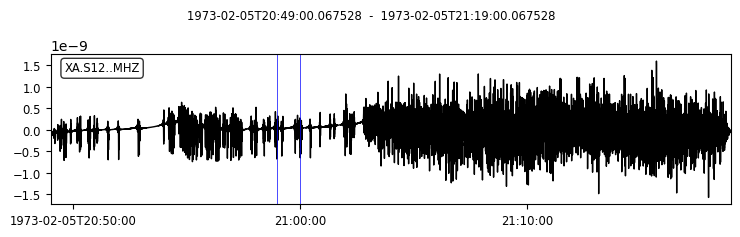

12 smi:nakamura81/event/05863
P  1973-02-09T12:28:00.000000Z
Event is not in list of accepted events
13 smi:nakamura81/event/05889
P  1973-02-11T18:42:00.000000Z
Event is not in list of accepted events
14 smi:nakamura81/event/05894
P  1973-02-12T10:56:00.000000Z
Event is not in list of accepted events
15 smi:nakamura81/event/05949
P  1973-02-15T23:35:00.000000Z
Event is not in list of accepted events
16 smi:nakamura81/event/05953
P  1973-02-16T06:31:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.47


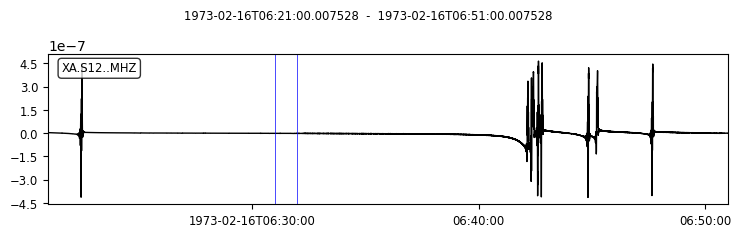

17 smi:nakamura81/event/05991
P  1973-02-21T09:23:00.000000Z
Event is not in list of accepted events
18 smi:nakamura81/event/06000
P  1973-02-24T06:22:00.000000Z
Event is not in list of accepted events
19 smi:nakamura81/event/06033
P  1973-03-07T08:54:00.000000Z
Event is not in list of accepted events
20 smi:nakamura81/event/06042
P  1973-03-11T21:11:00.000000Z
Event is not in list of accepted events
21 smi:nakamura81/event/06048
P  1973-03-12T20:40:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.71


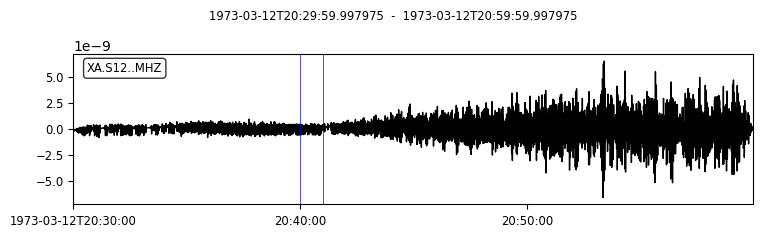

22 smi:nakamura81/event/06072
P  1973-03-15T13:46:00.000000Z
Event is not in list of accepted events
23 smi:nakamura81/event/06073
P  1973-03-15T16:40:00.000000Z
Event is not in list of accepted events
24 smi:nakamura81/event/06089
P  1973-03-16T17:46:00.000000Z
Event is not in list of accepted events
25 smi:nakamura81/event/06100
P  1973-03-17T08:58:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.76


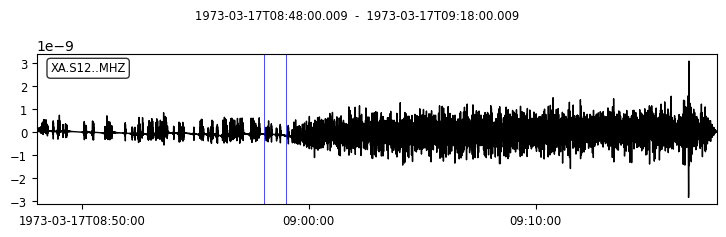

26 smi:nakamura81/event/06122
P  1973-03-20T09:46:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.79


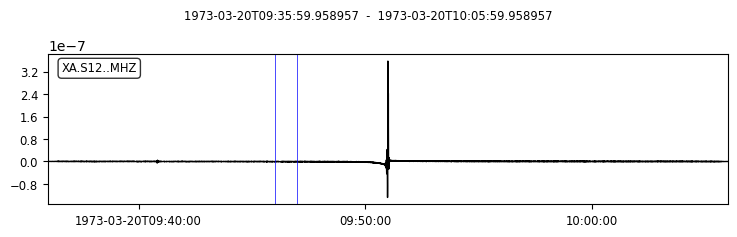

27 smi:nakamura81/event/06127
P  1973-03-22T09:30:00.000000Z
Event is not in list of accepted events
28 smi:nakamura81/event/06129
P  1973-03-22T15:18:00.000000Z
Event is not in list of accepted events
29 smi:nakamura81/event/06136
P  1973-03-23T13:07:00.000000Z
Event is not in list of accepted events
30 smi:nakamura81/event/06137
P  1973-03-23T17:07:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.82


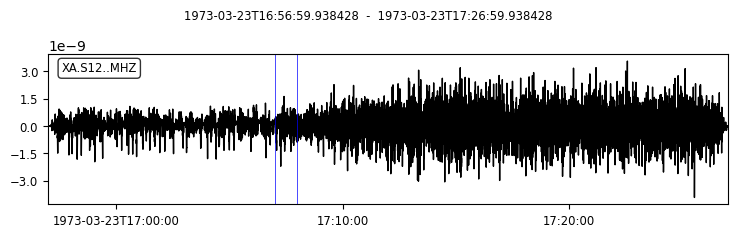

31 smi:nakamura81/event/06142
P  1973-03-24T19:23:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.83


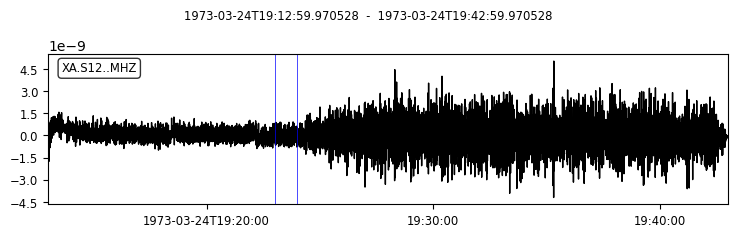

32 smi:nakamura81/event/06168
P  1973-03-27T15:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.86


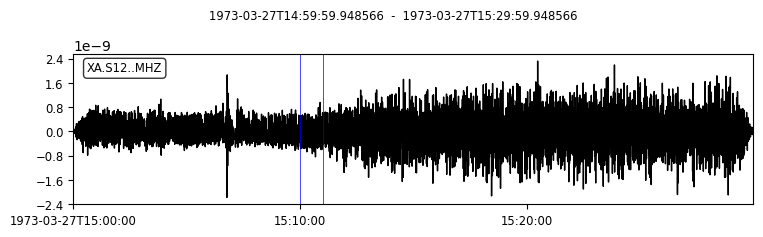

33 smi:nakamura81/event/06246
P  1973-04-13T16:43:00.000000Z
Event is not in list of accepted events
34 smi:nakamura81/event/06263
P  1973-04-23T13:56:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.113


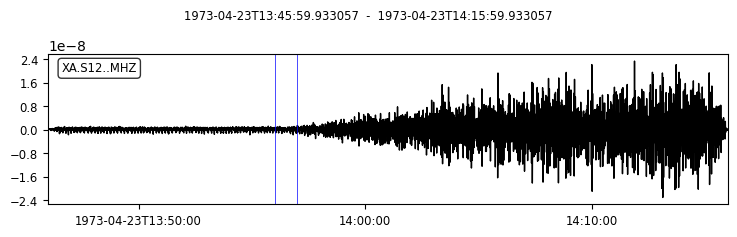

35 smi:nakamura81/event/06316
P  1973-04-29T22:42:00.000000Z
Event is not in list of accepted events
36 smi:nakamura81/event/06363
P  1973-05-09T11:45:00.000000Z
Event is not in list of accepted events
37 smi:nakamura81/event/06366
P  1973-05-10T08:36:00.000000Z
Event is not in list of accepted events
38 smi:nakamura81/event/06367
P  1973-05-10T12:57:00.000000Z
Event is not in list of accepted events
39 smi:nakamura81/event/06368
P  1973-05-11T05:13:00.000000Z
Event is not in list of accepted events
40 smi:nakamura81/event/06382
P  1973-05-14T00:44:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.134


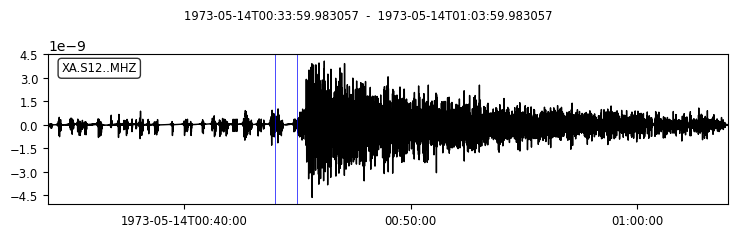

41 smi:nakamura81/event/06435
P  1973-05-23T11:42:00.000000Z
Event is not in list of accepted events
42 smi:nakamura81/event/06436
P  1973-05-23T18:54:00.000000Z
Event is not in list of accepted events
43 smi:nakamura81/event/06445
P  1973-05-25T00:42:00.000000Z
Event is not in list of accepted events
44 smi:nakamura81/event/06451
P  1973-05-26T01:02:00.000000Z
Event is not in list of accepted events
45 smi:nakamura81/event/06459
P  1973-05-27T17:03:00.000000Z
Event is not in list of accepted events
46 smi:nakamura81/event/06460
P  1973-05-27T17:40:00.000000Z
Event is not in list of accepted events
47 smi:nakamura81/event/06461
P  1973-05-27T18:05:00.000000Z
Event is not in list of accepted events
48 smi:nakamura81/event/06469
P  1973-05-28T10:55:00.000000Z
Event is not in list of accepted events
49 smi:nakamura81/event/06470
P  1973-05-28T11:48:00.000000Z
Event is not in list of accepted events
50 smi:nakamura81/event/06472
P  1973-05-28T16:08:00.000000Z
Event is not in list of accept

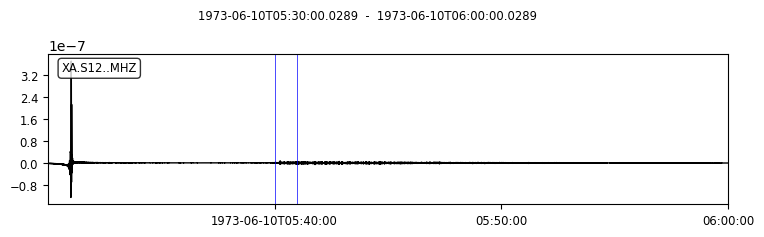

62 smi:nakamura81/event/06541
P  1973-06-13T04:50:00.000000Z
Event is not in list of accepted events
63 smi:nakamura81/event/06545
P  1973-06-14T05:43:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.165


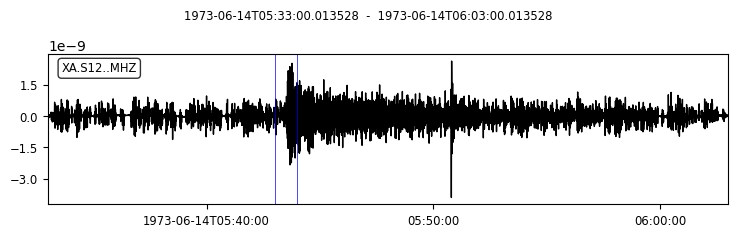

64 smi:nakamura81/event/06546
P  1973-06-14T12:53:00.000000Z
Event is not in list of accepted events
65 smi:nakamura81/event/06549
P  1973-06-15T20:13:00.000000Z
Event is not in list of accepted events
66 smi:nakamura81/event/06552
P  1973-06-16T05:55:00.000000Z
Event is not in list of accepted events
67 smi:nakamura81/event/06555
P  1973-06-16T16:43:00.000000Z
Event is not in list of accepted events
68 smi:nakamura81/event/06559
P  1973-06-18T01:42:00.000000Z
Event is not in list of accepted events
69 smi:nakamura81/event/06566
P  1973-06-20T16:00:00.000000Z
Event is not in list of accepted events
70 smi:nakamura81/event/06569
P  1973-06-22T06:42:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.173


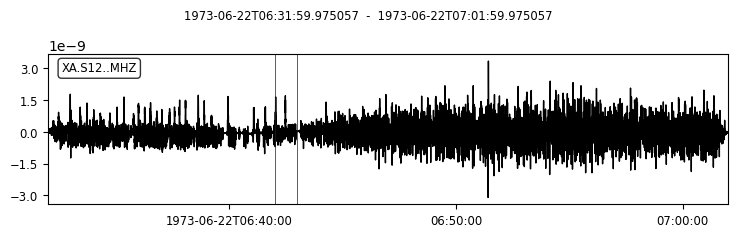

71 smi:nakamura81/event/06620
P  1973-06-27T18:36:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.178


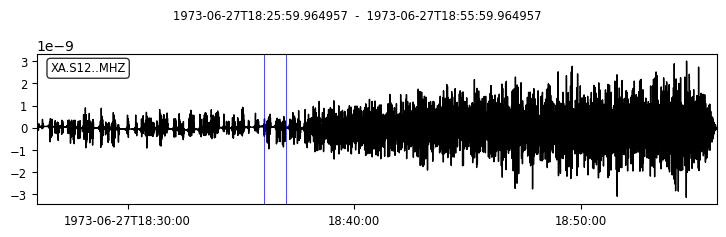

72 smi:nakamura81/event/06662
P  1973-07-03T18:15:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.184


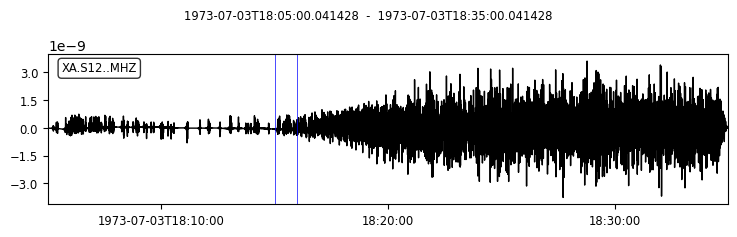

73 smi:nakamura81/event/06664
P  1973-07-04T02:46:00.000000Z
Event is not in list of accepted events
74 smi:nakamura81/event/06665
P  1973-07-04T05:12:00.000000Z
Event is not in list of accepted events
75 smi:nakamura81/event/06672
P  1973-07-06T07:37:00.000000Z
Event is not in list of accepted events
76 smi:nakamura81/event/06675
P  1973-07-08T05:30:00.000000Z
Event is not in list of accepted events
77 smi:nakamura81/event/06676
P  1973-07-08T05:57:00.000000Z
Event is not in list of accepted events
78 smi:nakamura81/event/06683
P  1973-07-10T06:14:00.000000Z
Event is not in list of accepted events
79 smi:nakamura81/event/06687
P  1973-07-10T18:15:00.000000Z
Event is not in list of accepted events
80 smi:nakamura81/event/06743
P  1973-07-20T08:18:00.000000Z
Event is not in list of accepted events
81 smi:nakamura81/event/06772
P  1973-07-24T08:45:00.000000Z
Event is not in list of accepted events
82 smi:nakamura81/event/06793
P  1973-07-28T00:52:00.000000Z
Event is not in list of accept

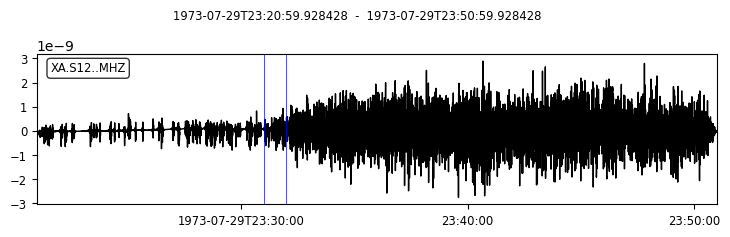

86 smi:nakamura81/event/06807
P  1973-07-31T06:11:00.000000Z
Event is not in list of accepted events
87 smi:nakamura81/event/06818
P  1973-08-01T08:54:00.000000Z
Event is not in list of accepted events
88 smi:nakamura81/event/06819
P  1973-08-01T11:02:00.000000Z
Event is not in list of accepted events
89 smi:nakamura81/event/06858
P  1973-08-08T17:19:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.220


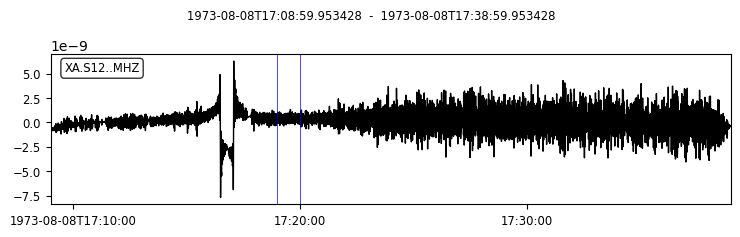

90 smi:nakamura81/event/06860
P  1973-08-08T23:47:00.000000Z
Event is not in list of accepted events
91 smi:nakamura81/event/06902
P  1973-08-19T07:28:00.000000Z
Event is not in list of accepted events
92 smi:nakamura81/event/06910
P  1973-08-21T12:17:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.233


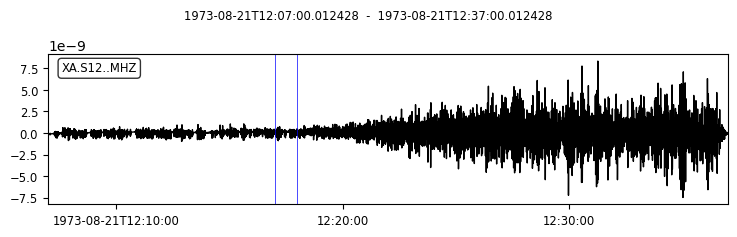

93 smi:nakamura81/event/06919
P  1973-08-27T00:04:00.000000Z
Event is not in list of accepted events
94 smi:nakamura81/event/06923
P  1973-08-29T15:33:00.000000Z
Event is not in list of accepted events
95 smi:nakamura81/event/06933
P  1973-09-01T06:59:00.000000Z
Event is not in list of accepted events
96 smi:nakamura81/event/06938
P  1973-09-01T12:58:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.244


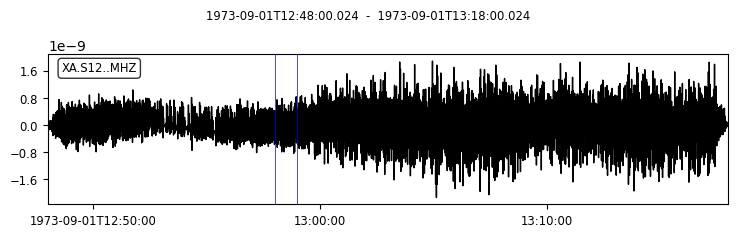

97 smi:nakamura81/event/06949
P  1973-09-02T16:47:00.000000Z
Event is not in list of accepted events
98 smi:nakamura81/event/06956
P  1973-09-04T04:41:00.000000Z
Event is not in list of accepted events
99 smi:nakamura81/event/06964
P  1973-09-05T11:42:00.000000Z
Event is not in list of accepted events
100 smi:nakamura81/event/07004
P  1973-09-10T04:00:00.000000Z
Event is not in list of accepted events
101 smi:nakamura81/event/07027
P  1973-09-12T09:13:00.000000Z
Event is not in list of accepted events
102 smi:nakamura81/event/07059
P  1973-09-16T13:20:00.000000Z
Event is not in list of accepted events
103 smi:nakamura81/event/07062
P  1973-09-16T20:07:00.000000Z
Event is not in list of accepted events
104 smi:nakamura81/event/07066
P  1973-09-17T22:54:00.000000Z
Event is not in list of accepted events
105 smi:nakamura81/event/07073
P  1973-09-19T09:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.262


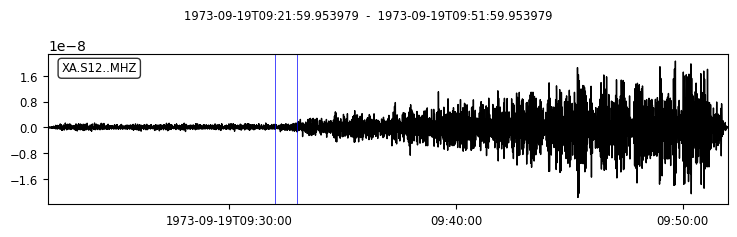

106 smi:nakamura81/event/07082
P  1973-09-23T04:22:00.000000Z
Event is not in list of accepted events
107 smi:nakamura81/event/07085
P  1973-09-26T15:34:00.000000Z
Event is not in list of accepted events
108 smi:nakamura81/event/07086
P  1973-09-26T20:48:00.000000Z
Event is not in list of accepted events
109 smi:nakamura81/event/07087
P  1973-09-26T23:58:00.000000Z
Event is not in list of accepted events
110 smi:nakamura81/event/07117
P  1973-10-03T20:31:00.000000Z
Event is not in list of accepted events
111 smi:nakamura81/event/07122
P  1973-10-05T13:45:00.000000Z
Event is not in list of accepted events
112 smi:nakamura81/event/07150
P  1973-10-07T16:10:00.000000Z
Event is not in list of accepted events
113 smi:nakamura81/event/07187
P  1973-10-10T03:01:00.000000Z
Event is not in list of accepted events
114 smi:nakamura81/event/07252
P  1973-10-19T10:10:00.000000Z
Event is not in list of accepted events
115 smi:nakamura81/event/07257
P  1973-10-21T05:32:00.000000Z
/Users/cnunn/lunar_d

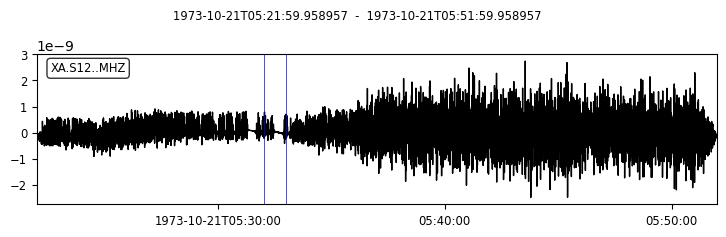

116 smi:nakamura81/event/07264
P  1973-10-24T10:34:00.000000Z
Event is not in list of accepted events
117 smi:nakamura81/event/07287
P  1973-11-01T08:28:00.000000Z
Event is not in list of accepted events
118 smi:nakamura81/event/07296
P  1973-11-05T17:21:00.000000Z
Event is not in list of accepted events
119 smi:nakamura81/event/07298
P  1973-11-06T03:38:00.000000Z
Event is not in list of accepted events
120 smi:nakamura81/event/07331
P  1973-11-13T15:45:00.000000Z
Event is not in list of accepted events
121 smi:nakamura81/event/07332
P  1973-11-14T02:16:00.000000Z
Event is not in list of accepted events
122 smi:nakamura81/event/07335
P  1973-11-18T14:23:00.000000Z
Event is not in list of accepted events
123 smi:nakamura81/event/07336
P  1973-11-20T21:00:00.000000Z
Event is not in list of accepted events
124 smi:nakamura81/event/07337
P  1973-11-21T15:22:00.000000Z
Event is not in list of accepted events
125 smi:nakamura81/event/07338
P  1973-11-22T13:57:00.000000Z
/Users/cnunn/lunar_d

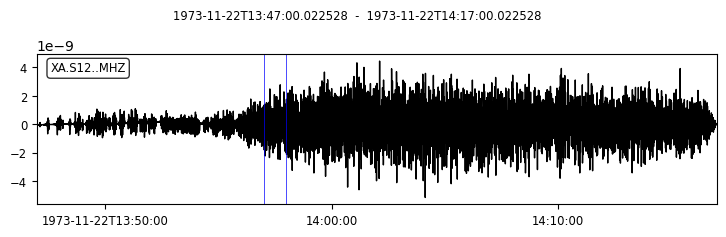

126 smi:nakamura81/event/07358
P  1973-11-27T14:06:00.000000Z
Event is not in list of accepted events
127 smi:nakamura81/event/07360
P  1973-11-29T17:33:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.333


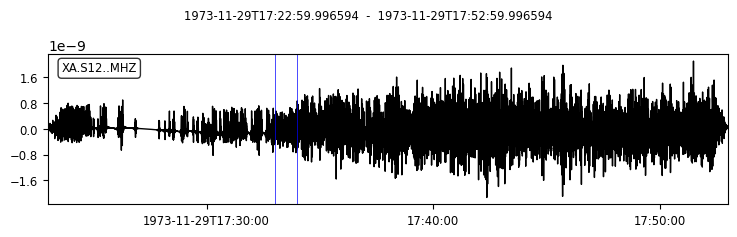

128 smi:nakamura81/event/07391
P  1973-12-05T13:18:00.000000Z
Event is not in list of accepted events
129 smi:nakamura81/event/07424
P  1973-12-10T12:40:00.000000Z
Event is not in list of accepted events
130 smi:nakamura81/event/07429
P  1973-12-10T22:08:00.000000Z
Event is not in list of accepted events
131 smi:nakamura81/event/07432
P  1973-12-13T06:07:00.000000Z
Event is not in list of accepted events
132 smi:nakamura81/event/07480
P  1973-12-23T21:34:00.000000Z
Event is not in list of accepted events
133 smi:nakamura81/event/07484
P  1973-12-24T10:05:00.000000Z
Event is not in list of accepted events
134 smi:nakamura81/event/07492
P  1973-12-28T08:10:00.000000Z
Event is not in list of accepted events
Successful count =  24
0 smi:nakamura81/event/05617
P  1973-01-01T06:35:00.000000Z
Event is not in list of accepted events
1 smi:nakamura81/event/05619
P  1973-01-01T11:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.1


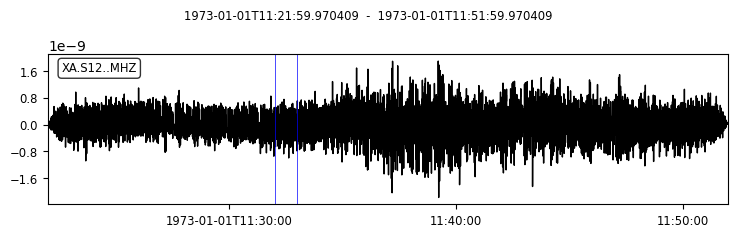

2 smi:nakamura81/event/05621
P  1973-01-01T16:55:00.000000Z
Event is not in list of accepted events
3 smi:nakamura81/event/05623
P  1973-01-01T20:22:00.000000Z
Event is not in list of accepted events
4 smi:nakamura81/event/05624
P  1973-01-01T22:42:00.000000Z
Event is not in list of accepted events
5 smi:nakamura81/event/05633
P  1973-01-02T16:32:00.000000Z
Event is not in list of accepted events
6 smi:nakamura81/event/05634
P  1973-01-02T17:48:00.000000Z
Event is not in list of accepted events
7 smi:nakamura81/event/05639
P  1973-01-03T02:44:00.000000Z
Event is not in list of accepted events
8 smi:nakamura81/event/05641
P  1973-01-03T10:38:00.000000Z
Event is not in list of accepted events
9 smi:nakamura81/event/05643
P  1973-01-03T15:48:00.000000Z
Event is not in list of accepted events
10 smi:nakamura81/event/05644
P  1973-01-03T16:47:00.000000Z
Event is not in list of accepted events
11 smi:nakamura81/event/05653
P  1973-01-04T06:32:00.000000Z
Event is not in list of accepted event

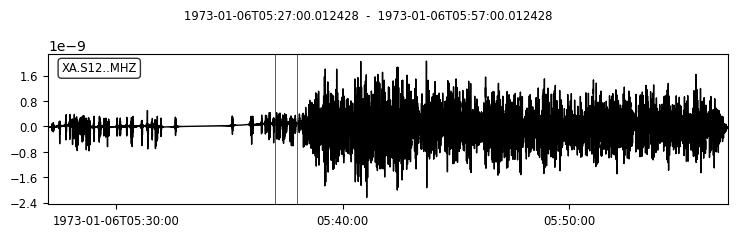

19 smi:nakamura81/event/05674
P  1973-01-06T15:02:00.000000Z
Event is not in list of accepted events
20 smi:nakamura81/event/05675
P  1973-01-06T16:21:00.000000Z
Event is not in list of accepted events
21 smi:nakamura81/event/05681
P  1973-01-07T09:37:00.000000Z
Event is not in list of accepted events
22 smi:nakamura81/event/05682
P  1973-01-07T12:35:00.000000Z
Event is not in list of accepted events
23 smi:nakamura81/event/05683
P  1973-01-07T17:13:00.000000Z
Event is not in list of accepted events
24 smi:nakamura81/event/05687
P  1973-01-08T09:11:00.000000Z
Event is not in list of accepted events
25 smi:nakamura81/event/05688
P  1973-01-08T11:30:00.000000Z
Event is not in list of accepted events
26 smi:nakamura81/event/05690
P  1973-01-10T00:22:00.000000Z
Event is not in list of accepted events
27 smi:nakamura81/event/05692
P  1973-01-10T05:37:00.000000Z
Event is not in list of accepted events
28 smi:nakamura81/event/05696
P  1973-01-11T15:07:00.000000Z
Event is not in list of accept

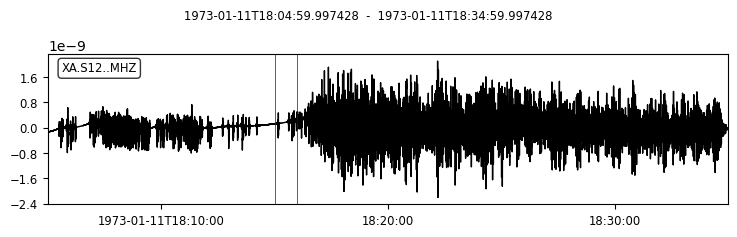

30 smi:nakamura81/event/05700
P  1973-01-12T07:16:00.000000Z
Event is not in list of accepted events
31 smi:nakamura81/event/05710
P  1973-01-13T03:46:00.000000Z
Event is not in list of accepted events
32 smi:nakamura81/event/05712
P  1973-01-13T11:06:00.000000Z
Event is not in list of accepted events
33 smi:nakamura81/event/05716
P  1973-01-14T03:10:00.000000Z
Event is not in list of accepted events
34 smi:nakamura81/event/05717
P  1973-01-14T05:44:00.000000Z
Event is not in list of accepted events
35 smi:nakamura81/event/05725
P  1973-01-14T22:29:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.14


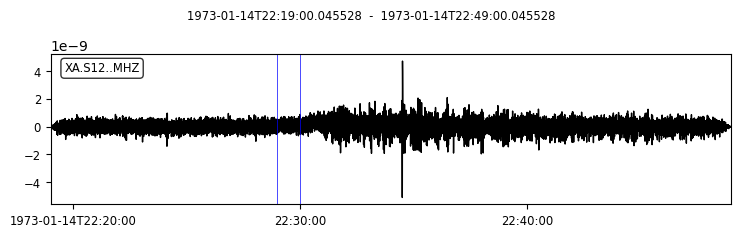

36 smi:nakamura81/event/05729
P  1973-01-15T08:17:00.000000Z
Event is not in list of accepted events
37 smi:nakamura81/event/05734
P  1973-01-15T18:48:00.000000Z
Event is not in list of accepted events
38 smi:nakamura81/event/05735
P  1973-01-15T21:20:00.000000Z
Event is not in list of accepted events
39 smi:nakamura81/event/05748
P  1973-01-17T08:05:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.17


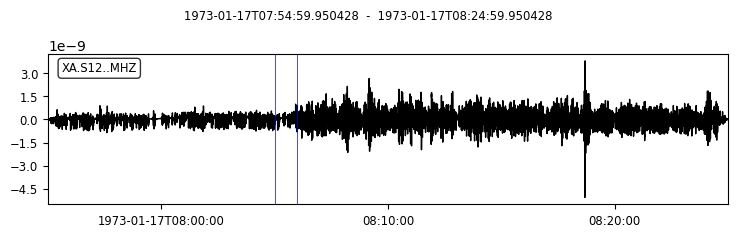

40 smi:nakamura81/event/05751
P  1973-01-17T10:49:00.000000Z
Event is not in list of accepted events
41 smi:nakamura81/event/05752
P  1973-01-17T11:22:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.17


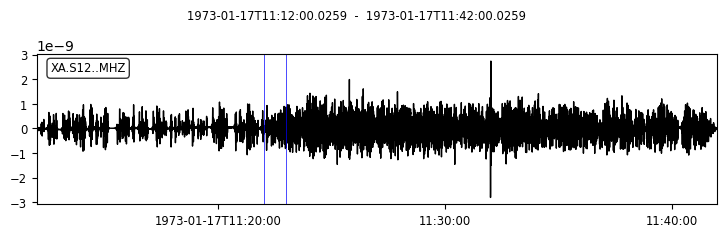

42 smi:nakamura81/event/05764
P  1973-01-20T00:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.19
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.20


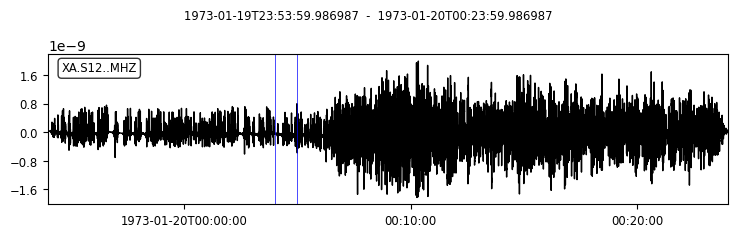

43 smi:nakamura81/event/05779
P  1973-01-21T14:46:00.000000Z
Event is not in list of accepted events
44 smi:nakamura81/event/05783
P  1973-01-22T15:23:00.000000Z
Event is not in list of accepted events
45 smi:nakamura81/event/05784
P  1973-01-23T03:53:00.000000Z
Event is not in list of accepted events
46 smi:nakamura81/event/05801
P  1973-01-27T21:47:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.27


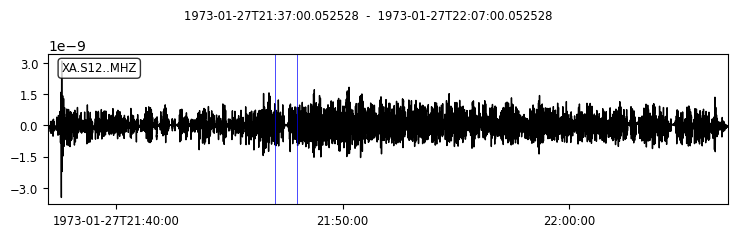

47 smi:nakamura81/event/05805
P  1973-01-28T13:45:00.000000Z
Event is not in list of accepted events
48 smi:nakamura81/event/05808
P  1973-01-29T09:28:00.000000Z
Event is not in list of accepted events
49 smi:nakamura81/event/05814
P  1973-01-30T04:15:00.000000Z
Event is not in list of accepted events
50 smi:nakamura81/event/05816
P  1973-01-30T16:09:00.000000Z
Event is not in list of accepted events
51 smi:nakamura81/event/05817
P  1973-01-30T20:46:00.000000Z
Event is not in list of accepted events
52 smi:nakamura81/event/05820
P  1973-01-31T05:13:00.000000Z
Event is not in list of accepted events
53 smi:nakamura81/event/05821
P  1973-01-31T07:53:00.000000Z
Event is not in list of accepted events
54 smi:nakamura81/event/05825
P  1973-01-31T21:48:00.000000Z
Event is not in list of accepted events
55 smi:nakamura81/event/05828
P  1973-02-01T13:51:00.000000Z
Event is not in list of accepted events
56 smi:nakamura81/event/05829
P  1973-02-01T14:57:00.000000Z
Event is not in list of accept

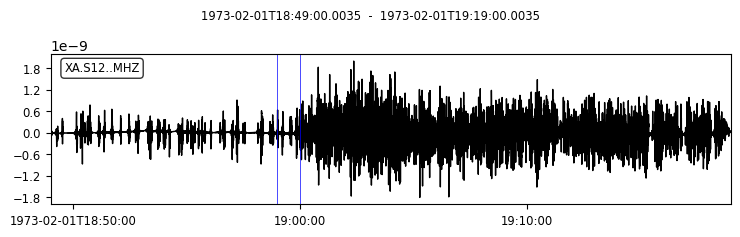

58 smi:nakamura81/event/05831
P  1973-02-01T20:37:00.000000Z
Event is not in list of accepted events
59 smi:nakamura81/event/05832
P  1973-02-02T02:36:00.000000Z
Event is not in list of accepted events
60 smi:nakamura81/event/05835
P  1973-02-02T16:33:00.000000Z
Event is not in list of accepted events
61 smi:nakamura81/event/05836
P  1973-02-02T17:29:00.000000Z
Event is not in list of accepted events
62 smi:nakamura81/event/05838
P  1973-02-02T21:00:00.000000Z
Event is not in list of accepted events
63 smi:nakamura81/event/05839
P  1973-02-03T00:55:00.000000Z
Event is not in list of accepted events
64 smi:nakamura81/event/05841
P  1973-02-03T12:44:00.000000Z
Event is not in list of accepted events
65 smi:nakamura81/event/05842
P  1973-02-03T13:10:00.000000Z
Event is not in list of accepted events
66 smi:nakamura81/event/05845
P  1973-02-04T00:11:00.000000Z
Event is not in list of accepted events
67 smi:nakamura81/event/05847
P  1973-02-05T03:51:00.000000Z
Event is not in list of accept

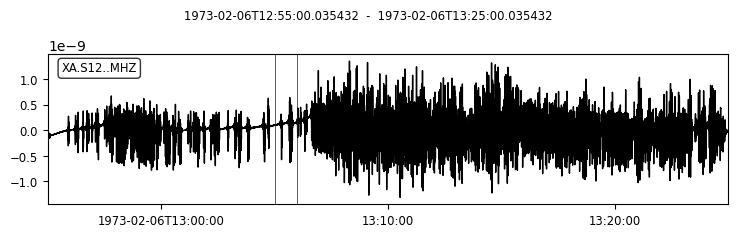

71 smi:nakamura81/event/05859
P  1973-02-06T13:17:00.000000Z
Event is not in list of accepted events
72 smi:nakamura81/event/05862
P  1973-02-09T02:24:00.000000Z
Event is not in list of accepted events
73 smi:nakamura81/event/05864
P  1973-02-09T13:36:00.000000Z
Event is not in list of accepted events
74 smi:nakamura81/event/05874
P  1973-02-10T05:40:00.000000Z
Event is not in list of accepted events
75 smi:nakamura81/event/05876
P  1973-02-10T09:56:00.000000Z
Event is not in list of accepted events
76 smi:nakamura81/event/05880
P  1973-02-10T16:21:00.000000Z
Event is not in list of accepted events
77 smi:nakamura81/event/05884
P  1973-02-10T22:34:00.000000Z
Event is not in list of accepted events
78 smi:nakamura81/event/05888
P  1973-02-11T16:47:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.42


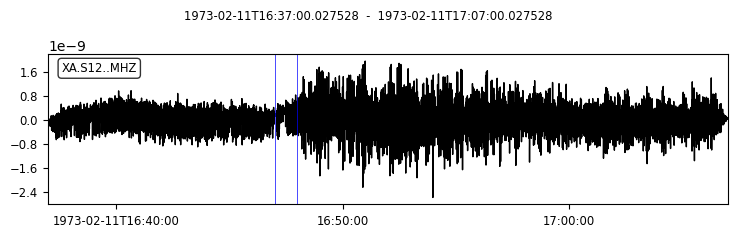

79 smi:nakamura81/event/05893
P  1973-02-12T10:20:00.000000Z
Event is not in list of accepted events
80 smi:nakamura81/event/05910
P  1973-02-13T09:00:00.000000Z
Event is not in list of accepted events
81 smi:nakamura81/event/05914
P  1973-02-13T15:26:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.44


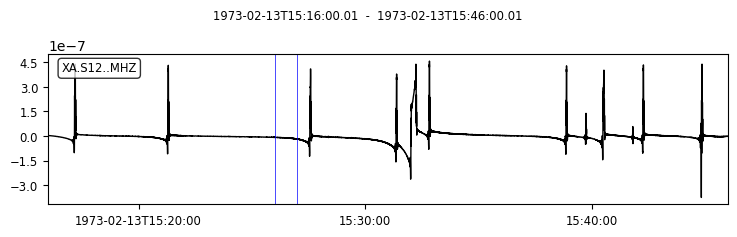

82 smi:nakamura81/event/05989
P  1973-02-19T12:54:00.000000Z
Event is not in list of accepted events
83 smi:nakamura81/event/05996
P  1973-02-23T06:46:00.000000Z
Event is not in list of accepted events
84 smi:nakamura81/event/06004
P  1973-02-25T04:22:00.000000Z
Event is not in list of accepted events
85 smi:nakamura81/event/06005
P  1973-02-25T08:46:00.000000Z
Event is not in list of accepted events
86 smi:nakamura81/event/06012
P  1973-02-26T13:31:00.000000Z
Event is not in list of accepted events
87 smi:nakamura81/event/06024
P  1973-02-28T11:53:00.000000Z
Event is not in list of accepted events
88 smi:nakamura81/event/06027
P  1973-03-01T07:15:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.60


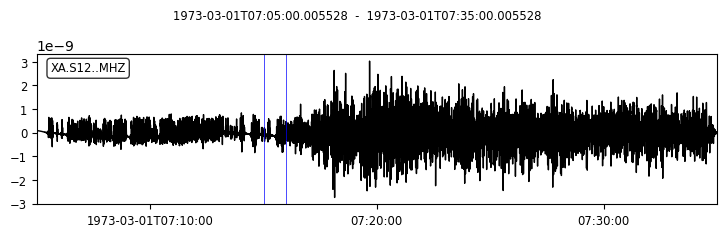

89 smi:nakamura81/event/06028
P  1973-03-02T06:37:00.000000Z
Event is not in list of accepted events
90 smi:nakamura81/event/06029
P  1973-03-02T10:30:00.000000Z
Event is not in list of accepted events
91 smi:nakamura81/event/06030
P  1973-03-02T20:53:00.000000Z
Event is not in list of accepted events
92 smi:nakamura81/event/06031
P  1973-03-03T02:04:00.000000Z
Event is not in list of accepted events
93 smi:nakamura81/event/06035
P  1973-03-08T19:09:00.000000Z
Event is not in list of accepted events
94 smi:nakamura81/event/06038
P  1973-03-09T13:37:00.000000Z
Event is not in list of accepted events
95 smi:nakamura81/event/06039
P  1973-03-09T18:38:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.68


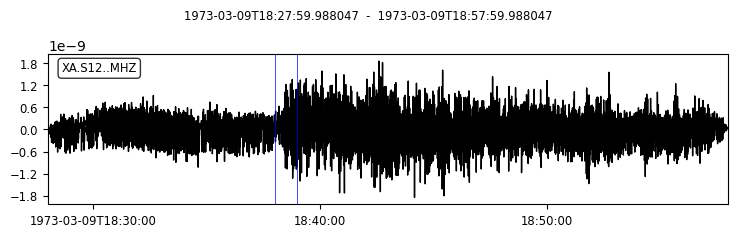

96 smi:nakamura81/event/06040
P  1973-03-09T20:18:00.000000Z
Event is not in list of accepted events
97 smi:nakamura81/event/06041
P  1973-03-11T13:45:00.000000Z
Event is not in list of accepted events
98 smi:nakamura81/event/06044
P  1973-03-12T04:49:00.000000Z
Event is not in list of accepted events
99 smi:nakamura81/event/06046
P  1973-03-12T08:38:00.000000Z
Event is not in list of accepted events
100 smi:nakamura81/event/06047
P  1973-03-12T16:03:00.000000Z
Event is not in list of accepted events
101 smi:nakamura81/event/06085
P  1973-03-16T14:53:00.000000Z
Event is not in list of accepted events
102 smi:nakamura81/event/06117
P  1973-03-19T12:53:00.000000Z
Event is not in list of accepted events
103 smi:nakamura81/event/06126
P  1973-03-22T08:22:00.000000Z
Event is not in list of accepted events
104 smi:nakamura81/event/06135
P  1973-03-23T09:52:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.82


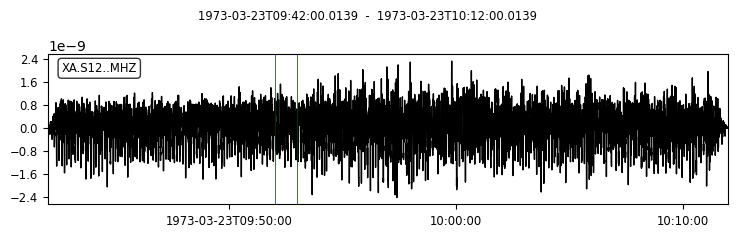

105 smi:nakamura81/event/06138
P  1973-03-23T22:57:00.000000Z
Event is not in list of accepted events
106 smi:nakamura81/event/06139
P  1973-03-24T06:22:00.000000Z
Event is not in list of accepted events
107 smi:nakamura81/event/06140
P  1973-03-24T06:45:00.000000Z
Event is not in list of accepted events
108 smi:nakamura81/event/06143
P  1973-03-25T04:37:00.000000Z
Event is not in list of accepted events
109 smi:nakamura81/event/06144
P  1973-03-25T09:00:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.84


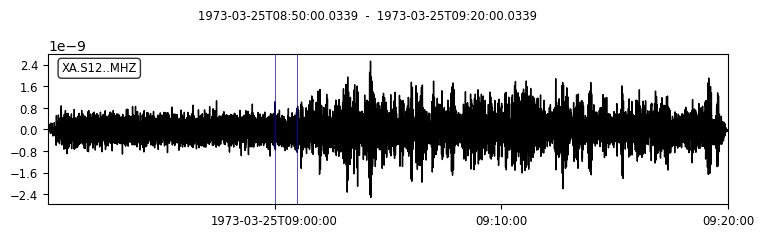

110 smi:nakamura81/event/06148
P  1973-03-26T05:58:00.000000Z
Event is not in list of accepted events
111 smi:nakamura81/event/06152
P  1973-03-26T14:20:00.000000Z
Event is not in list of accepted events
112 smi:nakamura81/event/06165
P  1973-03-27T10:07:00.000000Z
Event is not in list of accepted events
113 smi:nakamura81/event/06181
P  1973-03-29T06:39:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.88


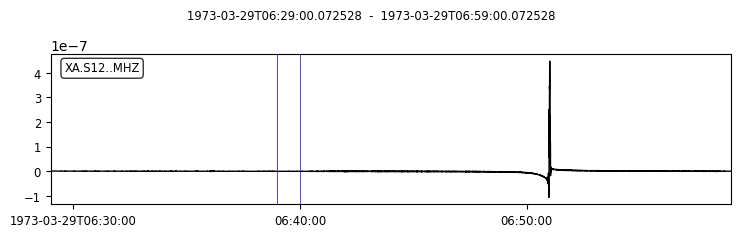

114 smi:nakamura81/event/06182
P  1973-03-29T08:45:00.000000Z
Event is not in list of accepted events
115 smi:nakamura81/event/06184
P  1973-03-29T10:12:00.000000Z
Event is not in list of accepted events
116 smi:nakamura81/event/06189
P  1973-03-30T01:06:00.000000Z
Event is not in list of accepted events
117 smi:nakamura81/event/06197
P  1973-04-01T13:34:00.000000Z
Event is not in list of accepted events
118 smi:nakamura81/event/06199
P  1973-04-01T18:50:00.000000Z
Event is not in list of accepted events
119 smi:nakamura81/event/06219
P  1973-04-05T00:00:00.000000Z
Event is not in list of accepted events
120 smi:nakamura81/event/06221
P  1973-04-05T03:32:00.000000Z
Event is not in list of accepted events
121 smi:nakamura81/event/06231
P  1973-04-06T20:40:00.000000Z
Event is not in list of accepted events
122 smi:nakamura81/event/06239
P  1973-04-08T13:31:00.000000Z
Event is not in list of accepted events
123 smi:nakamura81/event/06241
P  1973-04-08T19:02:00.000000Z
Event is not in list

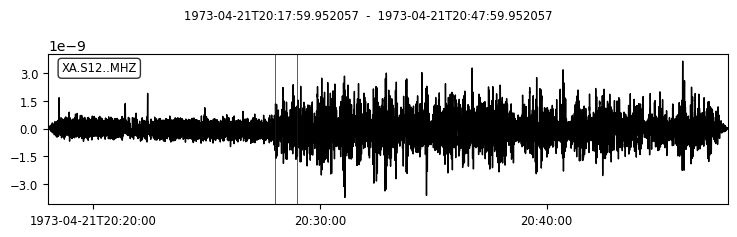

127 smi:nakamura81/event/06266
P  1973-04-24T08:42:00.000000Z
Event is not in list of accepted events
128 smi:nakamura81/event/06271
P  1973-04-24T21:07:00.000000Z
Event is not in list of accepted events
129 smi:nakamura81/event/06277
P  1973-04-25T16:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.115


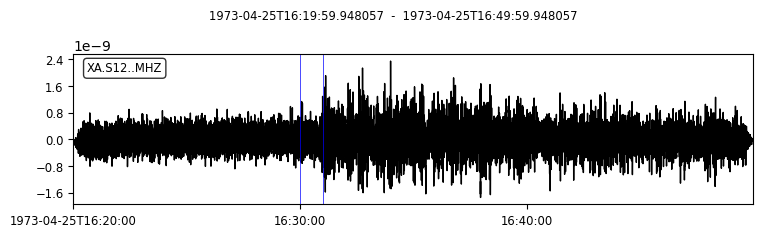

130 smi:nakamura81/event/06284
P  1973-04-26T10:57:00.000000Z
Event is not in list of accepted events
131 smi:nakamura81/event/06293
P  1973-04-27T14:04:00.000000Z
Event is not in list of accepted events
132 smi:nakamura81/event/06294
P  1973-04-27T14:32:00.000000Z
Event is not in list of accepted events
133 smi:nakamura81/event/06295
P  1973-04-27T15:00:00.000000Z
Event is not in list of accepted events
134 smi:nakamura81/event/06304
P  1973-04-28T22:36:00.000000Z
Event is not in list of accepted events
135 smi:nakamura81/event/06309
P  1973-04-29T07:54:00.000000Z
Event is not in list of accepted events
136 smi:nakamura81/event/06317
P  1973-04-30T01:07:00.000000Z
Event is not in list of accepted events
137 smi:nakamura81/event/06319
P  1973-04-30T13:46:00.000000Z
Event is not in list of accepted events
138 smi:nakamura81/event/06325
P  1973-05-01T12:04:00.000000Z
Event is not in list of accepted events
139 smi:nakamura81/event/06329
P  1973-05-02T08:35:00.000000Z
Event is not in list

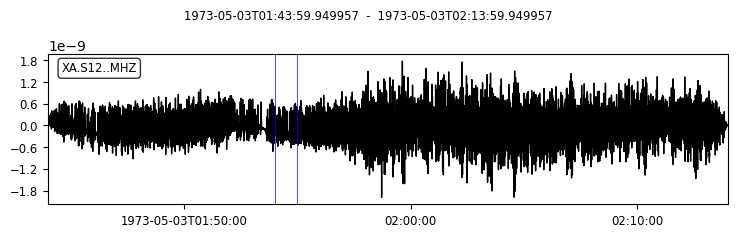

143 smi:nakamura81/event/06343
P  1973-05-03T15:44:00.000000Z
Event is not in list of accepted events
144 smi:nakamura81/event/06354
P  1973-05-05T08:59:00.000000Z
Event is not in list of accepted events
145 smi:nakamura81/event/06355
P  1973-05-05T19:34:00.000000Z
Event is not in list of accepted events
146 smi:nakamura81/event/06356
P  1973-05-05T21:08:00.000000Z
Event is not in list of accepted events
147 smi:nakamura81/event/06357
P  1973-05-06T02:54:00.000000Z
Event is not in list of accepted events
148 smi:nakamura81/event/06359
P  1973-05-07T19:07:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.127


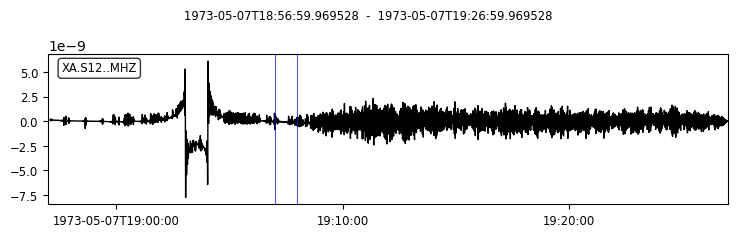

149 smi:nakamura81/event/06360
P  1973-05-08T10:20:00.000000Z
Event is not in list of accepted events
150 smi:nakamura81/event/06410
P  1973-05-16T14:18:00.000000Z
Event is not in list of accepted events
151 smi:nakamura81/event/06413
P  1973-05-16T19:00:00.000000Z
Event is not in list of accepted events
152 smi:nakamura81/event/06417
P  1973-05-17T11:42:00.000000Z
Event is not in list of accepted events
153 smi:nakamura81/event/06423
P  1973-05-18T12:40:00.000000Z
Event is not in list of accepted events
154 smi:nakamura81/event/06424
P  1973-05-18T13:32:00.000000Z
Event is not in list of accepted events
155 smi:nakamura81/event/06426
P  1973-05-19T06:11:00.000000Z
Event is not in list of accepted events
156 smi:nakamura81/event/06427
P  1973-05-19T15:33:00.000000Z
Event is not in list of accepted events
157 smi:nakamura81/event/06429
P  1973-05-19T22:52:00.000000Z
Event is not in list of accepted events
158 smi:nakamura81/event/06431
P  1973-05-20T08:24:00.000000Z
Event is not in list

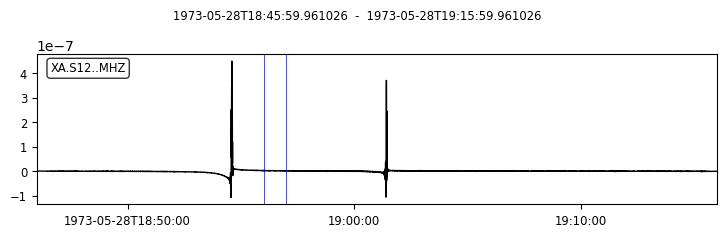

173 smi:nakamura81/event/06475
P  1973-05-28T20:54:00.000000Z
Event is not in list of accepted events
174 smi:nakamura81/event/06478
P  1973-05-29T02:56:00.000000Z
Event is not in list of accepted events
175 smi:nakamura81/event/06479
P  1973-05-29T03:35:00.000000Z
Event is not in list of accepted events
176 smi:nakamura81/event/06487
P  1973-05-29T12:30:00.000000Z
Event is not in list of accepted events
177 smi:nakamura81/event/06492
P  1973-05-29T18:57:00.000000Z
Event is not in list of accepted events
178 smi:nakamura81/event/06493
P  1973-05-30T00:30:00.000000Z
Event is not in list of accepted events
179 smi:nakamura81/event/06494
P  1973-05-30T01:55:00.000000Z
Event is not in list of accepted events
180 smi:nakamura81/event/06496
P  1973-05-30T10:20:00.000000Z
Event is not in list of accepted events
181 smi:nakamura81/event/06497
P  1973-05-30T14:19:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.150


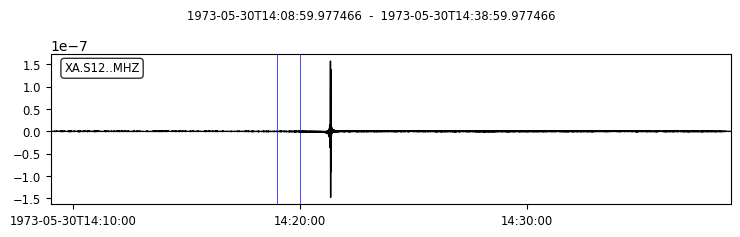

182 smi:nakamura81/event/06500
P  1973-05-31T05:02:00.000000Z
Event is not in list of accepted events
183 smi:nakamura81/event/06509
P  1973-06-02T03:13:00.000000Z
Event is not in list of accepted events
184 smi:nakamura81/event/06511
P  1973-06-02T05:11:00.000000Z
Event is not in list of accepted events
185 smi:nakamura81/event/06515
P  1973-06-03T01:25:00.000000Z
Event is not in list of accepted events
186 smi:nakamura81/event/06520
P  1973-06-04T14:49:00.000000Z
Event is not in list of accepted events
187 smi:nakamura81/event/06523
P  1973-06-05T05:20:00.000000Z
Event is not in list of accepted events
188 smi:nakamura81/event/06524
P  1973-06-05T11:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.156


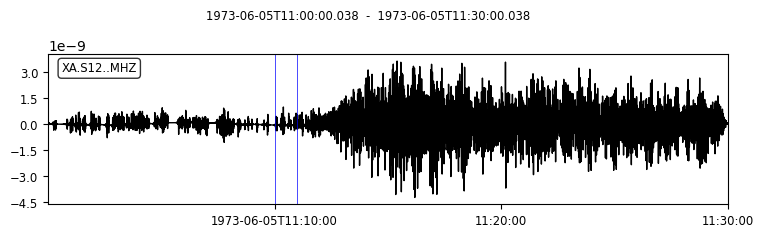

189 smi:nakamura81/event/06526
P  1973-06-06T20:50:00.000000Z
Event is not in list of accepted events
190 smi:nakamura81/event/06540
P  1973-06-12T21:18:00.000000Z
Event is not in list of accepted events
191 smi:nakamura81/event/06542
P  1973-06-13T06:03:00.000000Z
Event is not in list of accepted events
192 smi:nakamura81/event/06547
P  1973-06-15T04:19:00.000000Z
Event is not in list of accepted events
193 smi:nakamura81/event/06550
P  1973-06-15T21:08:00.000000Z
Event is not in list of accepted events
194 smi:nakamura81/event/06564
P  1973-06-20T00:11:00.000000Z
Event is not in list of accepted events
195 smi:nakamura81/event/06568
P  1973-06-21T10:46:00.000000Z
Event is not in list of accepted events
196 smi:nakamura81/event/06572
P  1973-06-22T18:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.173


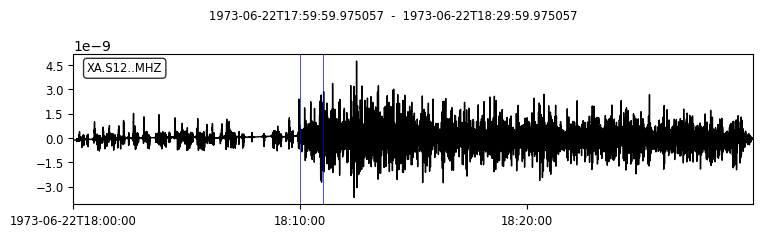

197 smi:nakamura81/event/06573
P  1973-06-22T20:04:00.000000Z
Event is not in list of accepted events
198 smi:nakamura81/event/06577
P  1973-06-23T12:20:00.000000Z
Event is not in list of accepted events
199 smi:nakamura81/event/06582
P  1973-06-24T23:20:00.000000Z
Event is not in list of accepted events
200 smi:nakamura81/event/06584
P  1973-06-25T02:02:00.000000Z
Event is not in list of accepted events
201 smi:nakamura81/event/06585
P  1973-06-25T03:59:00.000000Z
Event is not in list of accepted events
202 smi:nakamura81/event/06586
P  1973-06-25T04:13:00.000000Z
Event is not in list of accepted events
203 smi:nakamura81/event/06587
P  1973-06-25T06:03:00.000000Z
Event is not in list of accepted events
204 smi:nakamura81/event/06589
P  1973-06-25T09:02:00.000000Z
Event is not in list of accepted events
205 smi:nakamura81/event/06590
P  1973-06-25T10:59:00.000000Z
Event is not in list of accepted events
206 smi:nakamura81/event/06592
P  1973-06-25T17:35:00.000000Z
Event is not in list

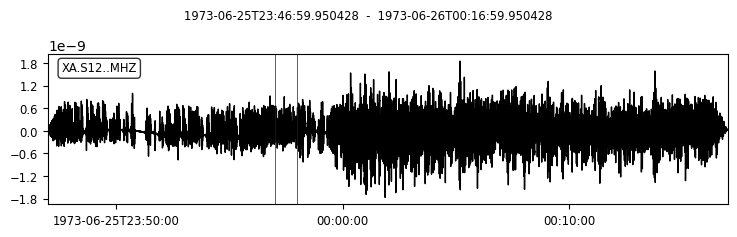

209 smi:nakamura81/event/06604
P  1973-06-26T10:00:00.000000Z
Event is not in list of accepted events
210 smi:nakamura81/event/06606
P  1973-06-26T11:45:00.000000Z
Event is not in list of accepted events
211 smi:nakamura81/event/06607
P  1973-06-26T13:18:00.000000Z
Event is not in list of accepted events
212 smi:nakamura81/event/06609
P  1973-06-26T16:49:00.000000Z
Event is not in list of accepted events
213 smi:nakamura81/event/06610
P  1973-06-26T16:57:00.000000Z
Event is not in list of accepted events
214 smi:nakamura81/event/06611
P  1973-06-26T17:41:00.000000Z
Event is not in list of accepted events
215 smi:nakamura81/event/06612
P  1973-06-26T20:51:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.177


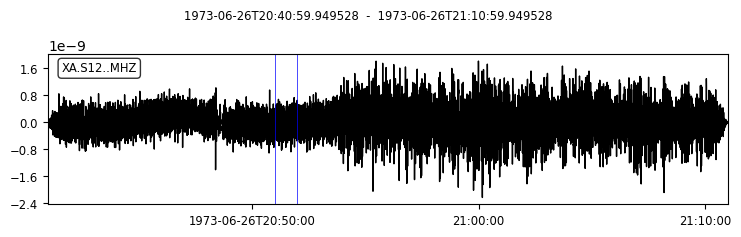

216 smi:nakamura81/event/06619
P  1973-06-27T11:01:00.000000Z
Event is not in list of accepted events
217 smi:nakamura81/event/06623
P  1973-06-27T23:51:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.178
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.179


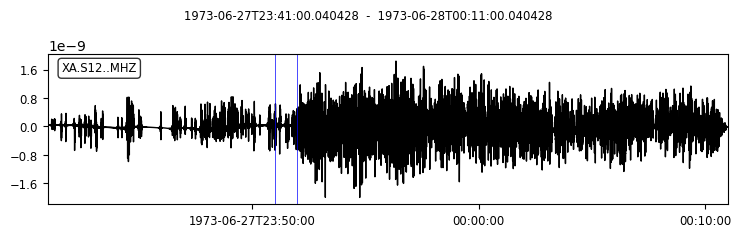

218 smi:nakamura81/event/06624
P  1973-06-28T00:18:00.000000Z
Event is not in list of accepted events
219 smi:nakamura81/event/06627
P  1973-06-28T02:49:00.000000Z
Event is not in list of accepted events
220 smi:nakamura81/event/06629
P  1973-06-28T05:27:00.000000Z
Event is not in list of accepted events
221 smi:nakamura81/event/06640
P  1973-06-30T01:56:00.000000Z
Event is not in list of accepted events
222 smi:nakamura81/event/06641
P  1973-06-30T03:49:00.000000Z
Event is not in list of accepted events
223 smi:nakamura81/event/06647
P  1973-07-01T04:20:00.000000Z
Event is not in list of accepted events
224 smi:nakamura81/event/06649
P  1973-07-01T11:38:00.000000Z
Event is not in list of accepted events
225 smi:nakamura81/event/06653
P  1973-07-02T08:00:00.000000Z
Event is not in list of accepted events
226 smi:nakamura81/event/06655
P  1973-07-02T09:59:00.000000Z
Event is not in list of accepted events
227 smi:nakamura81/event/06658
P  1973-07-03T03:07:00.000000Z
/Users/cnunn/lunar_d

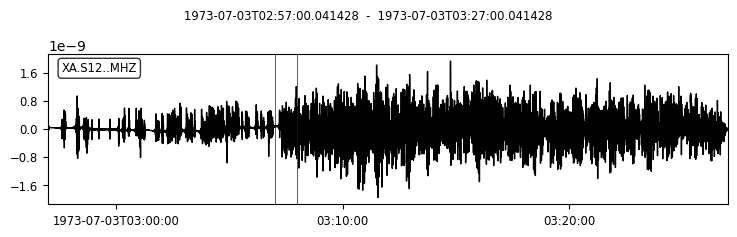

228 smi:nakamura81/event/06659
P  1973-07-03T03:56:00.000000Z
Event is not in list of accepted events
229 smi:nakamura81/event/06660
P  1973-07-03T05:08:00.000000Z
Event is not in list of accepted events
230 smi:nakamura81/event/06661
P  1973-07-03T06:10:00.000000Z
Event is not in list of accepted events
231 smi:nakamura81/event/06663
P  1973-07-03T23:17:00.000000Z
Event is not in list of accepted events
232 smi:nakamura81/event/06666
P  1973-07-04T13:49:00.000000Z
Event is not in list of accepted events
233 smi:nakamura81/event/06670
P  1973-07-06T05:20:00.000000Z
Event is not in list of accepted events
234 smi:nakamura81/event/06671
P  1973-07-06T06:10:00.000000Z
Event is not in list of accepted events
235 smi:nakamura81/event/06673
P  1973-07-06T12:42:00.000000Z
Event is not in list of accepted events
236 smi:nakamura81/event/06677
P  1973-07-09T00:00:00.000000Z
Event is not in list of accepted events
237 smi:nakamura81/event/06680
P  1973-07-09T10:45:00.000000Z
Event is not in list

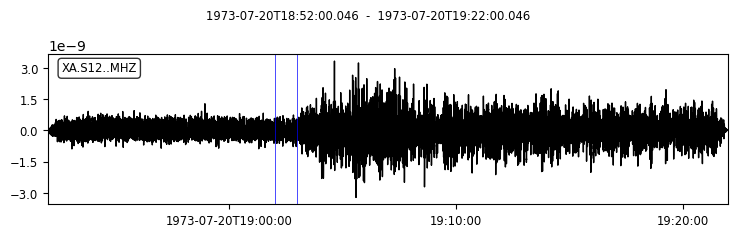

256 smi:nakamura81/event/06746
P  1973-07-21T12:35:00.000000Z
Event is not in list of accepted events
257 smi:nakamura81/event/06748
P  1973-07-21T18:34:00.000000Z
Event is not in list of accepted events
258 smi:nakamura81/event/06749
P  1973-07-21T21:17:00.000000Z
Event is not in list of accepted events
259 smi:nakamura81/event/06751
P  1973-07-22T09:14:00.000000Z
Event is not in list of accepted events
260 smi:nakamura81/event/06752
P  1973-07-22T10:08:00.000000Z
Event is not in list of accepted events
261 smi:nakamura81/event/06753
P  1973-07-22T14:17:00.000000Z
Event is not in list of accepted events
262 smi:nakamura81/event/06754
P  1973-07-22T14:30:00.000000Z
Event is not in list of accepted events
263 smi:nakamura81/event/06755
P  1973-07-22T20:47:00.000000Z
Event is not in list of accepted events
264 smi:nakamura81/event/06756
P  1973-07-22T23:04:00.000000Z
Event is not in list of accepted events
265 smi:nakamura81/event/06757
P  1973-07-22T23:48:00.000000Z
Event is not in list

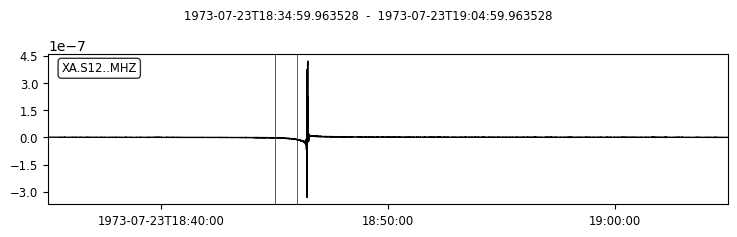

272 smi:nakamura81/event/06768
P  1973-07-23T19:02:00.000000Z
Event is not in list of accepted events
273 smi:nakamura81/event/06769
P  1973-07-23T21:50:00.000000Z
Event is not in list of accepted events
274 smi:nakamura81/event/06770
P  1973-07-24T02:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.205


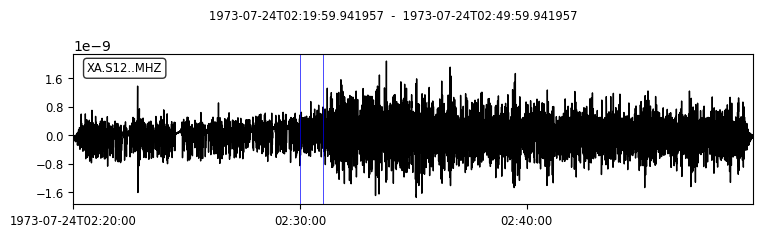

275 smi:nakamura81/event/06771
P  1973-07-24T04:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.205


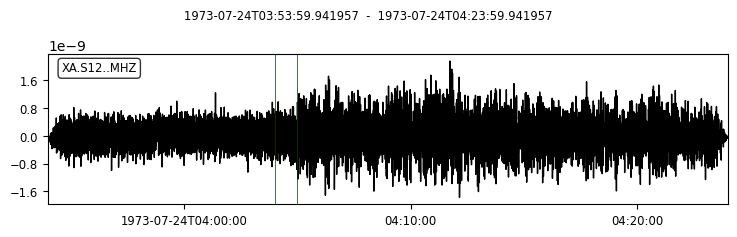

276 smi:nakamura81/event/06774
P  1973-07-24T14:58:00.000000Z
Event is not in list of accepted events
277 smi:nakamura81/event/06777
P  1973-07-25T04:12:00.000000Z
Event is not in list of accepted events
278 smi:nakamura81/event/06782
P  1973-07-26T00:32:00.000000Z
Event is not in list of accepted events
279 smi:nakamura81/event/06783
P  1973-07-26T01:22:00.000000Z
Event is not in list of accepted events
280 smi:nakamura81/event/06784
P  1973-07-26T02:12:00.000000Z
Event is not in list of accepted events
281 smi:nakamura81/event/06785
P  1973-07-26T06:45:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.207


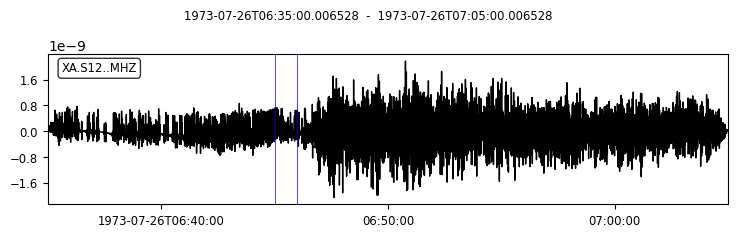

282 smi:nakamura81/event/06788
P  1973-07-27T07:38:00.000000Z
Event is not in list of accepted events
283 smi:nakamura81/event/06791
P  1973-07-27T14:08:00.000000Z
Event is not in list of accepted events
284 smi:nakamura81/event/06792
P  1973-07-27T21:01:00.000000Z
Event is not in list of accepted events
285 smi:nakamura81/event/06794
P  1973-07-28T03:45:00.000000Z
Event is not in list of accepted events
286 smi:nakamura81/event/06799
P  1973-07-29T15:20:00.000000Z
Event is not in list of accepted events
287 smi:nakamura81/event/06804
P  1973-07-31T01:19:00.000000Z
Event is not in list of accepted events
288 smi:nakamura81/event/06805
P  1973-07-31T05:05:00.000000Z
Event is not in list of accepted events
289 smi:nakamura81/event/06806
P  1973-07-31T05:10:00.000000Z
Event is not in list of accepted events
290 smi:nakamura81/event/06810
P  1973-07-31T10:18:00.000000Z
Event is not in list of accepted events
291 smi:nakamura81/event/06821
P  1973-08-01T15:42:00.000000Z
Event is not in list

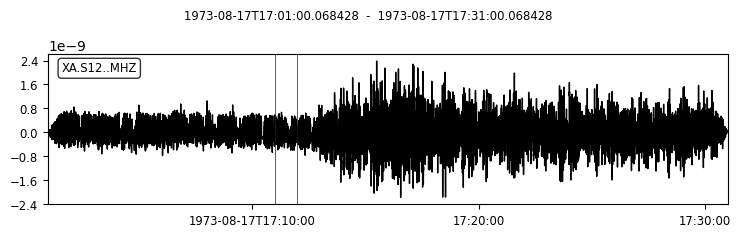

312 smi:nakamura81/event/06898
P  1973-08-17T19:58:00.000000Z
Event is not in list of accepted events
313 smi:nakamura81/event/06899
P  1973-08-18T02:29:00.000000Z
Event is not in list of accepted events
314 smi:nakamura81/event/06903
P  1973-08-19T20:12:00.000000Z
Event is not in list of accepted events
315 smi:nakamura81/event/06904
P  1973-08-20T02:18:00.000000Z
Event is not in list of accepted events
316 smi:nakamura81/event/06905
P  1973-08-20T04:38:00.000000Z
Event is not in list of accepted events
317 smi:nakamura81/event/06906
P  1973-08-20T05:50:00.000000Z
Event is not in list of accepted events
318 smi:nakamura81/event/06908
P  1973-08-20T10:04:00.000000Z
Event is not in list of accepted events
319 smi:nakamura81/event/06909
P  1973-08-20T22:10:00.000000Z
Event is not in list of accepted events
320 smi:nakamura81/event/06911
P  1973-08-22T18:50:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.234


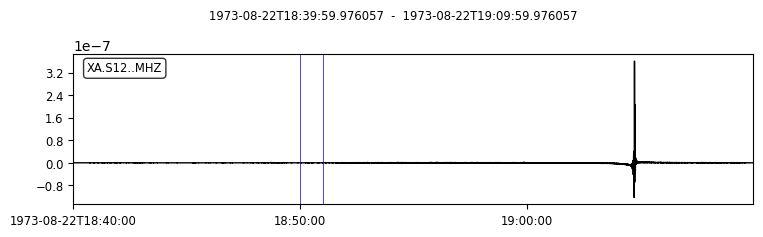

321 smi:nakamura81/event/06912
P  1973-08-23T07:52:00.000000Z
Event is not in list of accepted events
322 smi:nakamura81/event/06913
P  1973-08-23T22:29:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.235


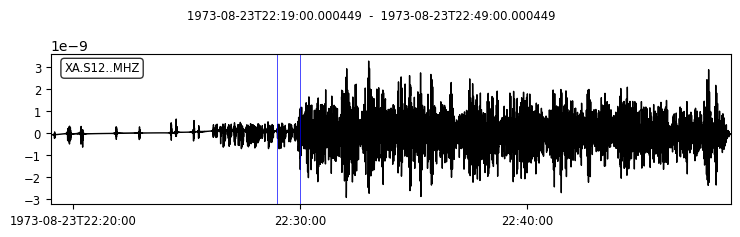

323 smi:nakamura81/event/06922
P  1973-08-29T06:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.241


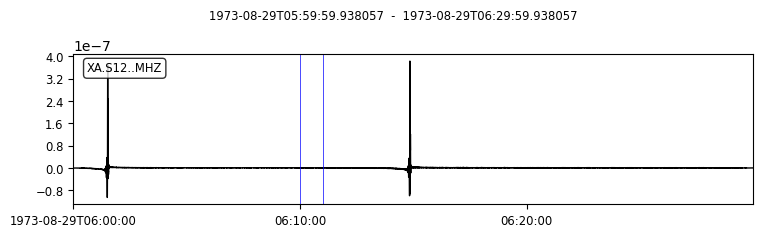

324 smi:nakamura81/event/06927
P  1973-08-31T00:02:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.242
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.243


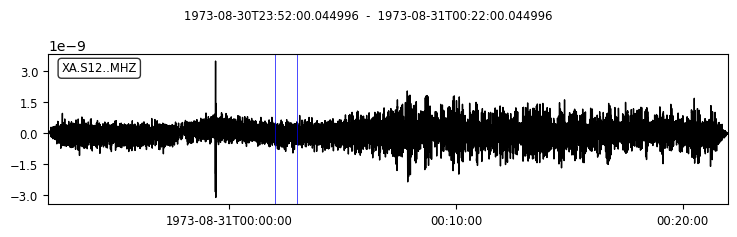

325 smi:nakamura81/event/06942
P  1973-09-02T01:52:00.000000Z
Event is not in list of accepted events
326 smi:nakamura81/event/06943
P  1973-09-02T03:40:00.000000Z
Event is not in list of accepted events
327 smi:nakamura81/event/06947
P  1973-09-02T08:40:00.000000Z
Event is not in list of accepted events
328 smi:nakamura81/event/06953
P  1973-09-03T15:35:00.000000Z
Event is not in list of accepted events
329 smi:nakamura81/event/06954
P  1973-09-03T16:00:00.000000Z
Event is not in list of accepted events
330 smi:nakamura81/event/06957
P  1973-09-04T06:44:00.000000Z
Event is not in list of accepted events
331 smi:nakamura81/event/06958
P  1973-09-04T07:58:00.000000Z
Event is not in list of accepted events
332 smi:nakamura81/event/06962
P  1973-09-04T21:58:00.000000Z
Event is not in list of accepted events
333 smi:nakamura81/event/06963
P  1973-09-05T10:37:00.000000Z
Event is not in list of accepted events
334 smi:nakamura81/event/06965
P  1973-09-05T15:55:00.000000Z
Event is not in list

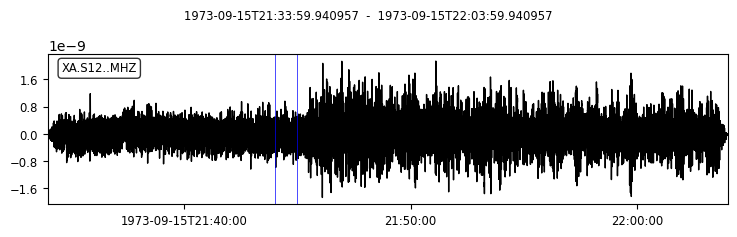

348 smi:nakamura81/event/07057
P  1973-09-16T02:48:00.000000Z
Event is not in list of accepted events
349 smi:nakamura81/event/07058
P  1973-09-16T12:50:00.000000Z
Event is not in list of accepted events
350 smi:nakamura81/event/07064
P  1973-09-17T00:50:00.000000Z
Event is not in list of accepted events
351 smi:nakamura81/event/07068
P  1973-09-18T10:42:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.261


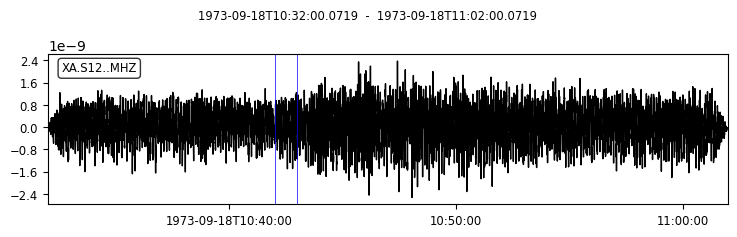

352 smi:nakamura81/event/07070
P  1973-09-18T22:22:00.000000Z
Event is not in list of accepted events
353 smi:nakamura81/event/07072
P  1973-09-19T05:36:00.000000Z
Event is not in list of accepted events
354 smi:nakamura81/event/07075
P  1973-09-19T23:48:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.262
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.263


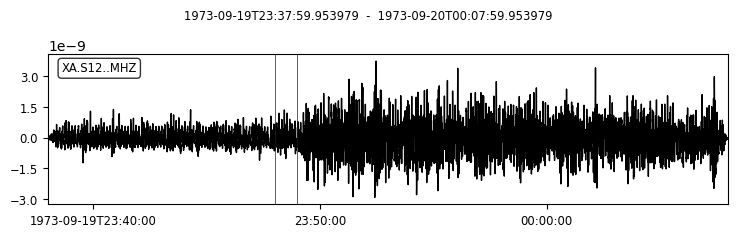

355 smi:nakamura81/event/07084
P  1973-09-23T17:44:00.000000Z
Event is not in list of accepted events
356 smi:nakamura81/event/07088
P  1973-09-27T17:45:00.000000Z
Event is not in list of accepted events
357 smi:nakamura81/event/07089
P  1973-09-29T13:02:00.000000Z
Event is not in list of accepted events
358 smi:nakamura81/event/07090
P  1973-09-29T14:27:00.000000Z
Event is not in list of accepted events
359 smi:nakamura81/event/07091
P  1973-09-29T14:54:00.000000Z
Event is not in list of accepted events
360 smi:nakamura81/event/07094
P  1973-09-29T22:58:00.000000Z
Event is not in list of accepted events
361 smi:nakamura81/event/07095
P  1973-09-30T04:12:00.000000Z
Event is not in list of accepted events
362 smi:nakamura81/event/07097
P  1973-09-30T12:57:00.000000Z
Event is not in list of accepted events
363 smi:nakamura81/event/07103
P  1973-10-01T18:35:00.000000Z
Event is not in list of accepted events
364 smi:nakamura81/event/07112
P  1973-10-02T22:53:00.000000Z
Event is not in list

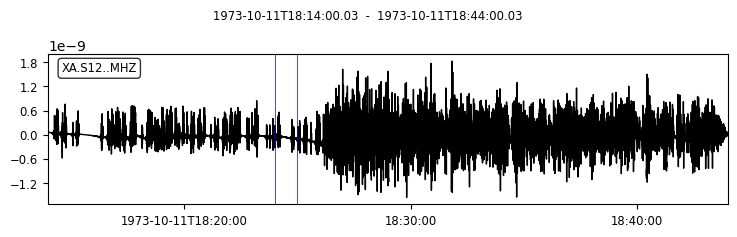

379 smi:nakamura81/event/07211
P  1973-10-11T21:45:00.000000Z
Event is not in list of accepted events
380 smi:nakamura81/event/07216
P  1973-10-12T01:05:00.000000Z
Event is not in list of accepted events
381 smi:nakamura81/event/07224
P  1973-10-12T10:21:00.000000Z
Event is not in list of accepted events
382 smi:nakamura81/event/07225
P  1973-10-12T12:58:00.000000Z
Event is not in list of accepted events
383 smi:nakamura81/event/07231
P  1973-10-12T23:52:00.000000Z
Event is not in list of accepted events
384 smi:nakamura81/event/07236
P  1973-10-13T09:24:00.000000Z
Event is not in list of accepted events
385 smi:nakamura81/event/07239
P  1973-10-14T15:55:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.287


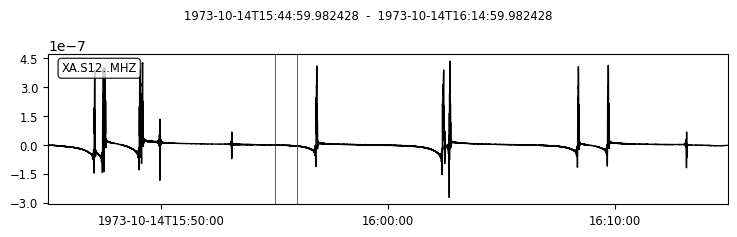

386 smi:nakamura81/event/07240
P  1973-10-15T12:08:00.000000Z
Event is not in list of accepted events
387 smi:nakamura81/event/07242
P  1973-10-16T11:42:00.000000Z
Event is not in list of accepted events
388 smi:nakamura81/event/07244
P  1973-10-16T19:08:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.289


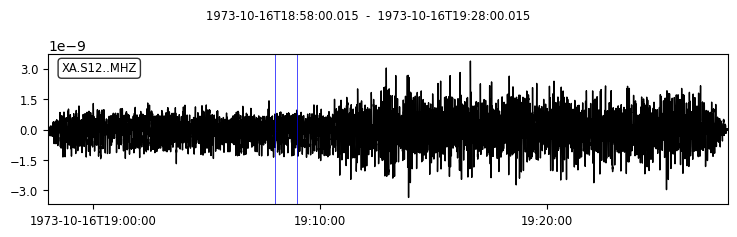

389 smi:nakamura81/event/07245
P  1973-10-17T00:26:00.000000Z
Event is not in list of accepted events
390 smi:nakamura81/event/07246
P  1973-10-17T14:01:00.000000Z
Event is not in list of accepted events
391 smi:nakamura81/event/07269
P  1973-10-26T20:31:00.000000Z
Event is not in list of accepted events
392 smi:nakamura81/event/07270
P  1973-10-27T02:55:00.000000Z
Event is not in list of accepted events
393 smi:nakamura81/event/07271
P  1973-10-27T05:44:00.000000Z
Event is not in list of accepted events
394 smi:nakamura81/event/07274
P  1973-10-27T18:39:00.000000Z
Event is not in list of accepted events
395 smi:nakamura81/event/07275
P  1973-10-27T20:10:00.000000Z
Event is not in list of accepted events
396 smi:nakamura81/event/07277
P  1973-10-29T08:08:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.302


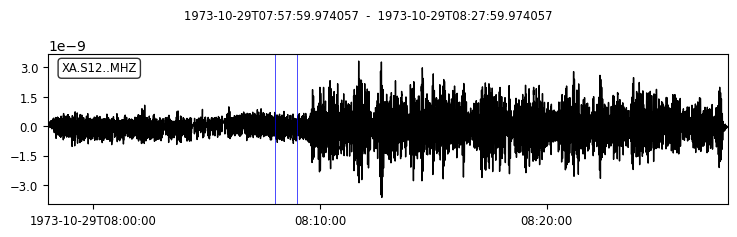

397 smi:nakamura81/event/07279
P  1973-10-30T01:00:00.000000Z
Event is not in list of accepted events
398 smi:nakamura81/event/07286
P  1973-10-31T19:00:00.000000Z
Event is not in list of accepted events
399 smi:nakamura81/event/07291
P  1973-11-04T07:38:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.308


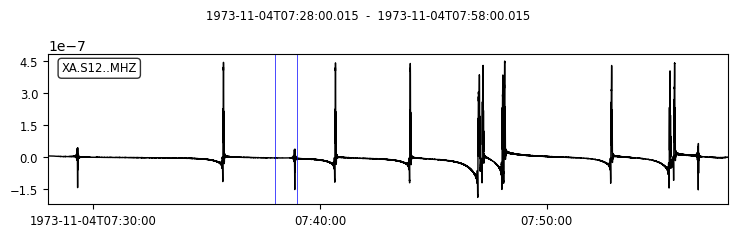

400 smi:nakamura81/event/07292
P  1973-11-04T10:57:00.000000Z
Event is not in list of accepted events
401 smi:nakamura81/event/07293
P  1973-11-04T11:33:00.000000Z
Event is not in list of accepted events
402 smi:nakamura81/event/07294
P  1973-11-05T05:03:00.000000Z
Event is not in list of accepted events
403 smi:nakamura81/event/07299
P  1973-11-06T10:09:00.000000Z
Event is not in list of accepted events
404 smi:nakamura81/event/07303
P  1973-11-08T01:13:00.000000Z
Event is not in list of accepted events
405 smi:nakamura81/event/07306
P  1973-11-08T06:58:00.000000Z
Event is not in list of accepted events
406 smi:nakamura81/event/07307
P  1973-11-08T10:51:00.000000Z
Event is not in list of accepted events
407 smi:nakamura81/event/07308
P  1973-11-08T15:30:00.000000Z
Event is not in list of accepted events
408 smi:nakamura81/event/07309
P  1973-11-08T16:11:00.000000Z
Event is not in list of accepted events
409 smi:nakamura81/event/07311
P  1973-11-08T21:20:00.000000Z
Event is not in list

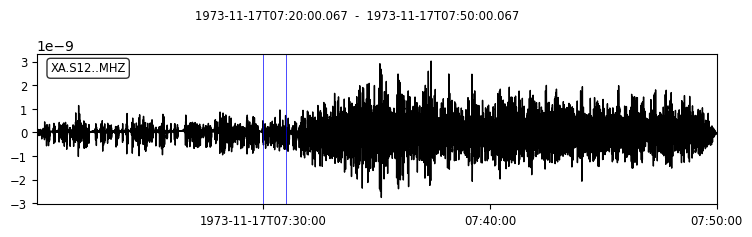

423 smi:nakamura81/event/07341
P  1973-11-23T00:10:00.000000Z
Event is not in list of accepted events
424 smi:nakamura81/event/07342
P  1973-11-23T07:16:00.000000Z
Event is not in list of accepted events
425 smi:nakamura81/event/07343
P  1973-11-23T08:51:00.000000Z
Event is not in list of accepted events
426 smi:nakamura81/event/07345
P  1973-11-24T07:13:00.000000Z
Event is not in list of accepted events
427 smi:nakamura81/event/07349
P  1973-11-25T13:00:00.000000Z
Event is not in list of accepted events
428 smi:nakamura81/event/07350
P  1973-11-25T16:21:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.329


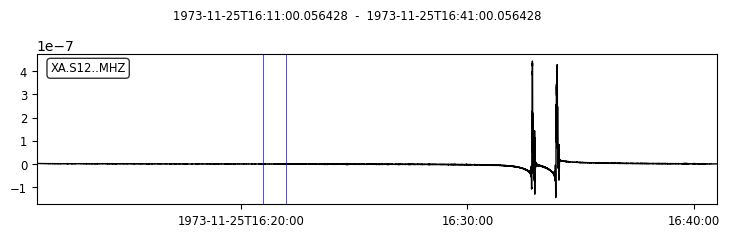

429 smi:nakamura81/event/07351
P  1973-11-26T02:34:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.330


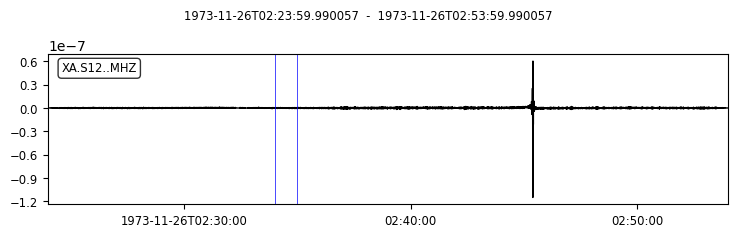

430 smi:nakamura81/event/07352
P  1973-11-26T04:48:00.000000Z
Event is not in list of accepted events
431 smi:nakamura81/event/07354
P  1973-11-26T06:36:00.000000Z
Event is not in list of accepted events
432 smi:nakamura81/event/07355
P  1973-11-26T14:38:00.000000Z
Event is not in list of accepted events
433 smi:nakamura81/event/07357
P  1973-11-27T10:59:00.000000Z
Event is not in list of accepted events
434 smi:nakamura81/event/07369
P  1973-12-02T01:30:00.000000Z
Event is not in list of accepted events
435 smi:nakamura81/event/07371
P  1973-12-02T22:36:00.000000Z
Event is not in list of accepted events
436 smi:nakamura81/event/07373
P  1973-12-03T00:35:00.000000Z
Event is not in list of accepted events
437 smi:nakamura81/event/07374
P  1973-12-03T05:50:00.000000Z
Event is not in list of accepted events
438 smi:nakamura81/event/07375
P  1973-12-03T10:59:00.000000Z
Event is not in list of accepted events
439 smi:nakamura81/event/07378
P  1973-12-03T17:48:00.000000Z
Event is not in list

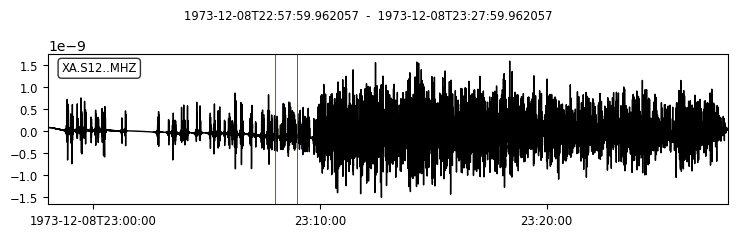

451 smi:nakamura81/event/07419
P  1973-12-10T03:40:00.000000Z
Event is not in list of accepted events
452 smi:nakamura81/event/07423
P  1973-12-10T12:03:00.000000Z
Event is not in list of accepted events
453 smi:nakamura81/event/07427
P  1973-12-10T16:17:00.000000Z
Event is not in list of accepted events
454 smi:nakamura81/event/07433
P  1973-12-14T01:39:00.000000Z
Event is not in list of accepted events
455 smi:nakamura81/event/07439
P  1973-12-17T08:51:00.000000Z
Event is not in list of accepted events
456 smi:nakamura81/event/07447
P  1973-12-20T00:56:00.000000Z
Event is not in list of accepted events
457 smi:nakamura81/event/07455
P  1973-12-20T17:05:00.000000Z
Event is not in list of accepted events
458 smi:nakamura81/event/07456
P  1973-12-20T18:48:00.000000Z
Event is not in list of accepted events
459 smi:nakamura81/event/07457
P  1973-12-20T21:11:00.000000Z
Event is not in list of accepted events
460 smi:nakamura81/event/07458
P  1973-12-21T02:40:00.000000Z
Event is not in list

In [29]:
# S12, MHZ - View all of the accepted events for the histogram cumulative_count_S12.jpg
# plot the waveform (plot_waveform=True) or plot the PPSD (plot_ppsd=False)

catalogs = [
  ['tmp_catalogs/S12_shallow.xml', 'navy', 'Shallow events (all)'],
  ]


check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=False,yaxis_db=False,station_code='S12',channel='MHZ',
    plot_raw_waveform=True, plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=False,accepted_events_file='tmp_selected_events/S12_shallow_events.txt',folder=None,save_mode=False)


catalogs = [
  ['tmp_catalogs/1973_S12_met.xml', 'darkgreen', 'Meteoroid impacts (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S12',channel='MHZ',
    plot_waveform=True,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=False,accepted_events_file='tmp_selected_events/S12_met_1973_events.txt',folder=None,save_mode=False)

catalogs = [  
      ['tmp_catalogs/1973_S12_deep.xml', 'red', 'Deep events (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S12',channel='MHZ',
    plot_waveform=True,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=False,accepted_events_file='tmp_selected_events/S12_deep_1973_events.txt',folder=None,save_mode=False)

# CHECKED


# Section 8 - Saving the npz files for the histograms  

# To rerun this section, set save_mode_default=True

In [30]:
# Save the npz files for S12 for MHX, for the accepted catalog all years for shallow, and for 1973 for the 
# other event types 

# Events with signal-to-noise ratio of approx 2.5 and above 

### Station 12, MHZ

In [31]:
# Station 12, MHZ, just the best events 

catalogs = [
  ['tmp_catalogs/S12_shallow.xml', 'navy', 'Shallow events (all)'],
  ]


check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=False,yaxis_db=False,station_code='S12',channel='MHZ',
    plot_raw_waveform=False, plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=False,accepted_events_file='tmp_selected_events/S12_shallow_events.txt',folder='tmp_npz',save_mode=save_mode_default)


catalogs = [
  ['tmp_catalogs/1973_S12_met.xml', 'darkgreen', 'Meteoroid impacts (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S12',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=False,accepted_events_file='tmp_selected_events/S12_met_1973_events.txt',folder='tmp_npz',save_mode=save_mode_default)

catalogs = [  
      ['tmp_catalogs/1973_S12_deep.xml', 'red', 'Deep events (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S12',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=False,accepted_events_file='tmp_selected_events/S12_deep_1973_events.txt',folder='tmp_npz',save_mode=save_mode_default)

# CHECKED


0 smi:nakamura81/event/01122
P  1971-04-17T07:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S12/MHZ/S12.XA..MHZ.1971.107
1 smi:nakamura81/event/01264
P  1971-05-20T17:29:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S12/MHZ/S12.XA..MHZ.1971.140
2 smi:nakamura81/event/01555
P  1971-07-11T13:27:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S12/MHZ/S12.XA..MHZ.1971.192
3 smi:nakamura81/event/02616
P  1972-01-02T22:32:00.000000Z
Event is not in list of accepted events
4 smi:nakamura81/event/05446
P  1972-12-06T23:10:00.000000Z
Event is not in list of accepted events
5 smi:nakamura81/event/05469
P  1972-12-09T03:52:00.000000Z
Event is not in list of accepted events
6 smi:nakamura81/event/05861
P  1973-02-08T22:53:00.000000Z
Event is not in list of accepted events
7 smi:nakamura81/event/06051
P  1973-03-13T08:01:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
8 smi:nakamura81/event/06567
P  1973-06-20T20:25:

0 smi:nakamura81/event/05617
P  1973-01-01T06:35:00.000000Z
Event is not in list of accepted events
1 smi:nakamura81/event/05619
P  1973-01-01T11:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.1
2 smi:nakamura81/event/05621
P  1973-01-01T16:55:00.000000Z
Event is not in list of accepted events
3 smi:nakamura81/event/05623
P  1973-01-01T20:22:00.000000Z
Event is not in list of accepted events
4 smi:nakamura81/event/05624
P  1973-01-01T22:42:00.000000Z
Event is not in list of accepted events
5 smi:nakamura81/event/05633
P  1973-01-02T16:32:00.000000Z
Event is not in list of accepted events
6 smi:nakamura81/event/05634
P  1973-01-02T17:48:00.000000Z
Event is not in list of accepted events
7 smi:nakamura81/event/05639
P  1973-01-03T02:44:00.000000Z
Event is not in list of accepted events
8 smi:nakamura81/event/05641
P  1973-01-03T10:38:00.000000Z
Event is not in list of accepted events
9 smi:nakamura81/event/05643
P  1973-01-03T15:48:00.000000Z
Even

P  1973-06-24T23:20:00.000000Z
Event is not in list of accepted events
200 smi:nakamura81/event/06584
P  1973-06-25T02:02:00.000000Z
Event is not in list of accepted events
201 smi:nakamura81/event/06585
P  1973-06-25T03:59:00.000000Z
Event is not in list of accepted events
202 smi:nakamura81/event/06586
P  1973-06-25T04:13:00.000000Z
Event is not in list of accepted events
203 smi:nakamura81/event/06587
P  1973-06-25T06:03:00.000000Z
Event is not in list of accepted events
204 smi:nakamura81/event/06589
P  1973-06-25T09:02:00.000000Z
Event is not in list of accepted events
205 smi:nakamura81/event/06590
P  1973-06-25T10:59:00.000000Z
Event is not in list of accepted events
206 smi:nakamura81/event/06592
P  1973-06-25T17:35:00.000000Z
Event is not in list of accepted events
207 smi:nakamura81/event/06593
P  1973-06-25T20:03:00.000000Z
Event is not in list of accepted events
208 smi:nakamura81/event/06598
P  1973-06-25T23:57:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S1

429 smi:nakamura81/event/07351
P  1973-11-26T02:34:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.330
430 smi:nakamura81/event/07352
P  1973-11-26T04:48:00.000000Z
Event is not in list of accepted events
431 smi:nakamura81/event/07354
P  1973-11-26T06:36:00.000000Z
Event is not in list of accepted events
432 smi:nakamura81/event/07355
P  1973-11-26T14:38:00.000000Z
Event is not in list of accepted events
433 smi:nakamura81/event/07357
P  1973-11-27T10:59:00.000000Z
Event is not in list of accepted events
434 smi:nakamura81/event/07369
P  1973-12-02T01:30:00.000000Z
Event is not in list of accepted events
435 smi:nakamura81/event/07371
P  1973-12-02T22:36:00.000000Z
Event is not in list of accepted events
436 smi:nakamura81/event/07373
P  1973-12-03T00:35:00.000000Z
Event is not in list of accepted events
437 smi:nakamura81/event/07374
P  1973-12-03T05:50:00.000000Z
Event is not in list of accepted events
438 smi:nakamura81/event/07375
P  1973-12-03

### Nakamura Catalog - S12, MHZ

In [32]:
# ############################
# Nakamura catalog
# As many values in the Nakamura catalog as possible (this uses the Z component, so if that's not working,
# but the event was in the catalog, that event will not be counted)
# Station 12


catalogs = [
  ['tmp_catalogs/S12_shallow.xml', 'navy', 'Shallow events (all)'],
  ]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=False,yaxis_db=False,station_code='S12',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)


catalogs = [
  ['tmp_catalogs/1973_S12_met.xml', 'darkgreen', 'Meteoroid impacts (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S12',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)

catalogs = [  
      ['tmp_catalogs/1973_S12_deep.xml', 'red', 'Deep events (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S12',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)

# CHECKED

0 smi:nakamura81/event/01122
P  1971-04-17T07:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S12/MHZ/S12.XA..MHZ.1971.107
1 smi:nakamura81/event/01264
P  1971-05-20T17:29:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S12/MHZ/S12.XA..MHZ.1971.140
2 smi:nakamura81/event/01555
P  1971-07-11T13:27:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S12/MHZ/S12.XA..MHZ.1971.192
3 smi:nakamura81/event/02616
P  1972-01-02T22:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.2
4 smi:nakamura81/event/05446
P  1972-12-06T23:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.341
5 smi:nakamura81/event/05469
P  1972-12-09T03:52:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.344
6 smi:nakamura81/event/05861
P  1973-02-08T22:53:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.39
7 smi:nakamura81/event/06051
P  1973-

45 smi:nakamura81/event/06459
P  1973-05-27T17:03:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.147
46 smi:nakamura81/event/06460
P  1973-05-27T17:40:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.147
47 smi:nakamura81/event/06461
P  1973-05-27T18:05:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.147
48 smi:nakamura81/event/06469
P  1973-05-28T10:55:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.148
49 smi:nakamura81/event/06470
P  1973-05-28T11:48:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.148
50 smi:nakamura81/event/06472
P  1973-05-28T16:08:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.148
51 smi:nakamura81/event/06485
P  1973-05-29T10:01:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.149
52 smi:nakamura81/event/064

113 smi:nakamura81/event/07187
P  1973-10-10T03:01:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.283
114 smi:nakamura81/event/07252
P  1973-10-19T10:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.292
115 smi:nakamura81/event/07257
P  1973-10-21T05:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.294
116 smi:nakamura81/event/07264
P  1973-10-24T10:34:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.297
117 smi:nakamura81/event/07287
P  1973-11-01T08:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.305
118 smi:nakamura81/event/07296
P  1973-11-05T17:21:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.309
119 smi:nakamura81/event/07298
P  1973-11-06T03:38:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.310
120 smi:nakamura81/e

50 smi:nakamura81/event/05816
P  1973-01-30T16:09:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.30
51 smi:nakamura81/event/05817
P  1973-01-30T20:46:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.30
52 smi:nakamura81/event/05820
P  1973-01-31T05:13:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.31
53 smi:nakamura81/event/05821
P  1973-01-31T07:53:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.31
54 smi:nakamura81/event/05825
P  1973-01-31T21:48:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.31
55 smi:nakamura81/event/05828
P  1973-02-01T13:51:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.32
56 smi:nakamura81/event/05829
P  1973-02-01T14:57:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.32
57 smi:nakamura81/event/05830
P  1

122 smi:nakamura81/event/06239
P  1973-04-08T13:31:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.98
123 smi:nakamura81/event/06241
P  1973-04-08T19:02:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.98
124 smi:nakamura81/event/06253
P  1973-04-19T12:50:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.109
125 smi:nakamura81/event/06258
P  1973-04-20T10:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.110
126 smi:nakamura81/event/06261
P  1973-04-21T20:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.111
127 smi:nakamura81/event/06266
P  1973-04-24T08:42:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.114
128 smi:nakamura81/event/06271
P  1973-04-24T21:07:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.114
129 smi:nakamura81/eve

199 smi:nakamura81/event/06582
P  1973-06-24T23:20:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.175
200 smi:nakamura81/event/06584
P  1973-06-25T02:02:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.176
201 smi:nakamura81/event/06585
P  1973-06-25T03:59:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.176
202 smi:nakamura81/event/06586
P  1973-06-25T04:13:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.176
203 smi:nakamura81/event/06587
P  1973-06-25T06:03:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.176
204 smi:nakamura81/event/06589
P  1973-06-25T09:02:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.176
205 smi:nakamura81/event/06590
P  1973-06-25T10:59:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.176
206 smi:nakamura81/e

276 smi:nakamura81/event/06774
P  1973-07-24T14:58:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.205
277 smi:nakamura81/event/06777
P  1973-07-25T04:12:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.206
278 smi:nakamura81/event/06782
P  1973-07-26T00:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.207
279 smi:nakamura81/event/06783
P  1973-07-26T01:22:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.207
280 smi:nakamura81/event/06784
P  1973-07-26T02:12:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.207
281 smi:nakamura81/event/06785
P  1973-07-26T06:45:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.207
282 smi:nakamura81/event/06788
P  1973-07-27T07:38:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.208
283 smi:nakamura81/e

341 smi:nakamura81/event/07014
P  1973-09-10T21:13:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.253
342 smi:nakamura81/event/07016
P  1973-09-10T23:40:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.253
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.254
343 smi:nakamura81/event/07024
P  1973-09-11T23:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.254
344 smi:nakamura81/event/07041
P  1973-09-13T21:19:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.256
345 smi:nakamura81/event/07052
P  1973-09-15T12:25:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.258
346 smi:nakamura81/event/07054
P  1973-09-15T16:11:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.258
347 smi:nakamura81/event/07055
P  1973-09-15T21:44:00.000000Z
/Users/cnunn/lunar_d

405 smi:nakamura81/event/07306
P  1973-11-08T06:58:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.312
406 smi:nakamura81/event/07307
P  1973-11-08T10:51:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.312
407 smi:nakamura81/event/07308
P  1973-11-08T15:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.312
408 smi:nakamura81/event/07309
P  1973-11-08T16:11:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.312
409 smi:nakamura81/event/07311
P  1973-11-08T21:20:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.312
410 smi:nakamura81/event/07313
P  1973-11-09T03:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.313
411 smi:nakamura81/event/07314
P  1973-11-09T04:00:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.313
412 smi:nakamura81/e

Successful count =  469


### Nakamura Catalog - S16, MHZ

In [33]:
# ############################
# Nakamura catalog
# As many values in the Nakamura catalog as possible (this uses the Z component, so if that's not working,
# but the event was in the catalog, that event will not be counted)
# Station 16

catalogs = [
  ['tmp_catalogs/S16_shallow.xml', 'navy', 'Shallow events (all)'],
  ]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=False,yaxis_db=False,station_code='S16',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)


catalogs = [
  ['tmp_catalogs/1973_S16_met.xml', 'darkgreen', 'Meteoroid impacts (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S16',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)

catalogs = [  
      ['tmp_catalogs/1973_S16_deep.xml', 'red', 'Deep events (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S16',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)


0 smi:nakamura81/event/04679
P  1972-09-17T14:38:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/MHZ/S16.XA..MHZ.1972.261
1 smi:nakamura81/event/05446
P  1972-12-06T23:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/MHZ/S16.XA..MHZ.1972.341
2 smi:nakamura81/event/05469
P  1972-12-09T03:52:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/MHZ/S16.XA..MHZ.1972.344
3 smi:nakamura81/event/05861
P  1973-02-08T22:53:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.39
4 smi:nakamura81/event/06051
P  1973-03-13T08:01:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.72
[Errno 2] No such file or directory: '/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.72'
5 smi:nakamura81/event/06567
P  1973-06-20T20:25:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.171
6 smi:nakamura81/event/07098
P  1973-10-01T04:00:00.000000

49 smi:nakamura81/event/06450
P  1973-05-25T17:06:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.145
50 smi:nakamura81/event/06451
P  1973-05-26T01:02:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.146
51 smi:nakamura81/event/06459
P  1973-05-27T17:03:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.147
52 smi:nakamura81/event/06461
P  1973-05-27T18:05:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.147
53 smi:nakamura81/event/06469
P  1973-05-28T10:55:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.148
54 smi:nakamura81/event/06470
P  1973-05-28T11:48:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.148
55 smi:nakamura81/event/06472
P  1973-05-28T16:08:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.148
56 smi:nakamura81/event/064

111 smi:nakamura81/event/06902
P  1973-08-19T07:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.231
112 smi:nakamura81/event/06910
P  1973-08-21T12:17:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.233
113 smi:nakamura81/event/06918
P  1973-08-25T02:45:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.237
114 smi:nakamura81/event/06923
P  1973-08-29T15:33:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.241
115 smi:nakamura81/event/06930
P  1973-09-01T01:05:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.244
116 smi:nakamura81/event/06933
P  1973-09-01T06:59:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.244
117 smi:nakamura81/event/06935
P  1973-09-01T09:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.244
118 smi:nakamura81/e

0 smi:nakamura81/event/05615
P  1973-01-01T02:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.1
1 smi:nakamura81/event/05618
P  1973-01-01T10:16:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.1
2 smi:nakamura81/event/05619
P  1973-01-01T11:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.1
3 smi:nakamura81/event/05620
P  1973-01-01T12:08:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.1
4 smi:nakamura81/event/05635
P  1973-01-02T21:56:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.2
5 smi:nakamura81/event/05637
P  1973-01-02T23:42:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.3
6 smi:nakamura81/event/05638
P  1973-01-03T01:00:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973

71 smi:nakamura81/event/05783
P  1973-01-22T15:23:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.22
72 smi:nakamura81/event/05796
P  1973-01-26T22:00:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.26
73 smi:nakamura81/event/05797
P  1973-01-27T04:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.27
74 smi:nakamura81/event/05799
P  1973-01-27T11:39:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.27
75 smi:nakamura81/event/05802
P  1973-01-27T22:37:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.27
76 smi:nakamura81/event/05803
P  1973-01-28T03:17:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.28
77 smi:nakamura81/event/05807
P  1973-01-29T07:50:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.29
78 smi:nakamura81/event/05814
P  1

153 smi:nakamura81/event/06037
P  1973-03-09T12:50:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.68
154 smi:nakamura81/event/06047
P  1973-03-12T16:03:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.71
155 smi:nakamura81/event/06060
P  1973-03-14T11:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.73
[Errno 2] No such file or directory: '/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.73'
156 smi:nakamura81/event/06062
P  1973-03-14T16:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.73
[Errno 2] No such file or directory: '/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.73'
157 smi:nakamura81/event/06070
P  1973-03-15T09:52:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.74
[Errno 2] No such file or directory: '/Users/cnunn/lunar_data/GEOSCOPE_lu

198 smi:nakamura81/event/06258
P  1973-04-20T10:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.110
199 smi:nakamura81/event/06259
P  1973-04-21T14:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.111
200 smi:nakamura81/event/06261
P  1973-04-21T20:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.111
201 smi:nakamura81/event/06265
P  1973-04-24T04:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.114
202 smi:nakamura81/event/06267
P  1973-04-24T09:07:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.114
203 smi:nakamura81/event/06268
P  1973-04-24T12:20:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.114
204 smi:nakamura81/event/06270
P  1973-04-24T14:29:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.114
205 smi:nakamura81/e

267 smi:nakamura81/event/06418
P  1973-05-17T21:31:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.137
268 smi:nakamura81/event/06422
P  1973-05-18T08:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.138
269 smi:nakamura81/event/06423
P  1973-05-18T12:40:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.138
270 smi:nakamura81/event/06426
P  1973-05-19T06:11:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.139
271 smi:nakamura81/event/06427
P  1973-05-19T15:33:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.139
272 smi:nakamura81/event/06428
P  1973-05-19T22:00:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.139
273 smi:nakamura81/event/06429
P  1973-05-19T22:52:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.139
274 smi:nakamura81/e

329 smi:nakamura81/event/06550
P  1973-06-15T21:08:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.166
330 smi:nakamura81/event/06551
P  1973-06-16T03:40:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.167
331 smi:nakamura81/event/06553
P  1973-06-16T08:49:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.167
332 smi:nakamura81/event/06554
P  1973-06-16T13:27:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.167
333 smi:nakamura81/event/06558
P  1973-06-17T23:55:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.168
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.169
334 smi:nakamura81/event/06560
P  1973-06-18T11:22:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.169
335 smi:nakamura81/event/06561
P  1973-06-18T21:10:00.000000Z
/Users/cnunn/lunar_d

409 smi:nakamura81/event/06695
P  1973-07-11T09:44:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.192
410 smi:nakamura81/event/06697
P  1973-07-11T21:05:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.192
411 smi:nakamura81/event/06698
P  1973-07-12T00:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.193
412 smi:nakamura81/event/06701
P  1973-07-12T06:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.193
413 smi:nakamura81/event/06708
P  1973-07-12T21:15:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.193
414 smi:nakamura81/event/06711
P  1973-07-13T03:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.194
415 smi:nakamura81/event/06714
P  1973-07-13T07:43:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.194
416 smi:nakamura81/e

485 smi:nakamura81/event/06871
P  1973-08-10T22:38:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.222
486 smi:nakamura81/event/06873
P  1973-08-11T00:51:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.223
487 smi:nakamura81/event/06874
P  1973-08-11T01:12:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.223
488 smi:nakamura81/event/06875
P  1973-08-11T12:08:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.223
489 smi:nakamura81/event/06877
P  1973-08-11T23:43:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.223
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.224
490 smi:nakamura81/event/06878
P  1973-08-12T12:07:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.224
491 smi:nakamura81/event/06879
P  1973-08-12T12:45:00.000000Z
/Users/cnunn/lunar_d

568 smi:nakamura81/event/07109
P  1973-10-02T11:35:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.275
569 smi:nakamura81/event/07110
P  1973-10-02T16:08:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.275
570 smi:nakamura81/event/07111
P  1973-10-02T22:31:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.275
571 smi:nakamura81/event/07112
P  1973-10-02T22:53:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.275
572 smi:nakamura81/event/07113
P  1973-10-02T23:46:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.275
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.276
573 smi:nakamura81/event/07114
P  1973-10-03T01:34:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.276
574 smi:nakamura81/event/07119
P  1973-10-04T00:32:00.000000Z
/Users/cnunn/lunar_d

642 smi:nakamura81/event/07323
P  1973-11-10T22:55:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.314
643 smi:nakamura81/event/07326
P  1973-11-12T12:48:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.316
644 smi:nakamura81/event/07327
P  1973-11-12T21:50:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.316
645 smi:nakamura81/event/07328
P  1973-11-12T21:57:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.316
646 smi:nakamura81/event/07329
P  1973-11-13T03:27:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.317
647 smi:nakamura81/event/07334
P  1973-11-17T07:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.321
648 smi:nakamura81/event/07340
P  1973-11-22T19:47:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.326
649 smi:nakamura81/e

724 smi:nakamura81/event/07487
P  1973-12-25T15:16:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.359
725 smi:nakamura81/event/07488
P  1973-12-26T23:44:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.360
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.361
726 smi:nakamura81/event/07489
P  1973-12-27T07:37:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.361
727 smi:nakamura81/event/07490
P  1973-12-27T23:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.361
728 smi:nakamura81/event/07491
P  1973-12-28T00:20:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.362
729 smi:nakamura81/event/07494
P  1973-12-28T16:23:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.362
730 smi:nakamura81/event/07495
P  1973-12-28T16:28:00.000000Z
/Users/cnunn/lunar_d

# Nakamura Catalog - S14, MHZ

In [34]:
### Nakamura Catalog - S14, MHZ

# ############################
# Nakamura catalog
# As many values in the Nakamura catalog as possible (this uses the Z component, so if that's not working,
# but the event was in the catalog, that event will not be counted)
# Station 16

catalogs = [
  ['tmp_catalogs/S14_shallow.xml', 'navy', 'Shallow events (all)'],
  ]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=False,yaxis_db=False,station_code='S14',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)


catalogs = [
  ['tmp_catalogs/1973_S14_met.xml', 'darkgreen', 'Meteoroid impacts (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S14',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)

catalogs = [  
      ['tmp_catalogs/1973_S14_deep.xml', 'red', 'Deep events (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S14',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)




0 smi:nakamura81/event/01122
P  1971-04-17T07:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
1 smi:nakamura81/event/01264
P  1971-05-20T17:29:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.140
[Errno 2] No such file or directory: '/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.140'
2 smi:nakamura81/event/01555
P  1971-07-11T13:27:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.192
[Errno 2] No such file or directory: '/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.192'
3 smi:nakamura81/event/02616
P  1972-01-02T22:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S14/MHZ/S14.XA..MHZ.1972.2
4 smi:nakamura81/event/04679
P  1972-09-17T14:38:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S14/MHZ/S14.XA..MHZ.1972.261
5 smi:nakamura81/event/05446
P  1972-12-06T23:10:00.000000Z
/Users/cnunn/lunar

28 smi:nakamura81/event/06072
P  1973-03-15T13:46:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.74
29 smi:nakamura81/event/06073
P  1973-03-15T16:40:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.74
30 smi:nakamura81/event/06089
P  1973-03-16T17:46:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.75
31 smi:nakamura81/event/06100
P  1973-03-17T08:58:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.76
32 smi:nakamura81/event/06120
P  1973-03-20T06:05:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.79
33 smi:nakamura81/event/06122
P  1973-03-20T09:46:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.79
34 smi:nakamura81/event/06124
P  1973-03-20T18:35:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.79
35 smi:nakamura81/event/06127
P  1

92 smi:nakamura81/event/06549
P  1973-06-15T20:13:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.166
93 smi:nakamura81/event/06552
P  1973-06-16T05:55:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.167
94 smi:nakamura81/event/06555
P  1973-06-16T16:43:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.167
95 smi:nakamura81/event/06556
P  1973-06-16T18:43:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.167
96 smi:nakamura81/event/06559
P  1973-06-18T01:42:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.169
97 smi:nakamura81/event/06565
P  1973-06-20T00:45:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.171
98 smi:nakamura81/event/06566
P  1973-06-20T16:00:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.171
99 smi:nakamura81/event/065

155 smi:nakamura81/event/07257
P  1973-10-21T05:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.294
156 smi:nakamura81/event/07264
P  1973-10-24T10:34:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.297
157 smi:nakamura81/event/07276
P  1973-10-29T07:50:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.302
158 smi:nakamura81/event/07278
P  1973-10-29T19:22:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.302
159 smi:nakamura81/event/07280
P  1973-10-30T05:22:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.303
160 smi:nakamura81/event/07287
P  1973-11-01T08:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.305
161 smi:nakamura81/event/07289
P  1973-11-03T10:00:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.307
162 smi:nakamura81/e

75 smi:nakamura81/event/05808
P  1973-01-29T09:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.29
76 smi:nakamura81/event/05810
P  1973-01-29T13:24:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.29
77 smi:nakamura81/event/05812
P  1973-01-30T02:21:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.30
78 smi:nakamura81/event/05813
P  1973-01-30T03:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.30
79 smi:nakamura81/event/05814
P  1973-01-30T04:15:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.30
80 smi:nakamura81/event/05815
P  1973-01-30T10:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.30
81 smi:nakamura81/event/05816
P  1973-01-30T16:09:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.30
82 smi:nakamura81/event/05817
P  1

150 smi:nakamura81/event/06132
P  1973-03-22T20:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.81
151 smi:nakamura81/event/06134
P  1973-03-23T04:54:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.82
152 smi:nakamura81/event/06135
P  1973-03-23T09:52:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.82
153 smi:nakamura81/event/06138
P  1973-03-23T22:57:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.82
154 smi:nakamura81/event/06139
P  1973-03-24T06:22:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.83
155 smi:nakamura81/event/06140
P  1973-03-24T06:45:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.83
156 smi:nakamura81/event/06143
P  1973-03-25T04:37:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.84
157 smi:nakamura81/event/06

213 smi:nakamura81/event/06290
P  1973-04-26T23:40:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.116
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.117
214 smi:nakamura81/event/06291
P  1973-04-27T02:40:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.117
215 smi:nakamura81/event/06293
P  1973-04-27T14:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.117
216 smi:nakamura81/event/06294
P  1973-04-27T14:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.117
217 smi:nakamura81/event/06295
P  1973-04-27T15:00:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.117
218 smi:nakamura81/event/06299
P  1973-04-28T07:07:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.118
219 smi:nakamura81/event/06307
P  1973-04-29T05:17:00.000000Z
/Users/cnunn/lunar_d

275 smi:nakamura81/event/06466
P  1973-05-28T02:50:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.148
276 smi:nakamura81/event/06468
P  1973-05-28T09:25:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.148
277 smi:nakamura81/event/06471
P  1973-05-28T13:13:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.148
278 smi:nakamura81/event/06473
P  1973-05-28T17:36:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.148
279 smi:nakamura81/event/06474
P  1973-05-28T18:56:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.148
280 smi:nakamura81/event/06475
P  1973-05-28T20:54:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.148
281 smi:nakamura81/event/06476
P  1973-05-28T23:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.148
282 smi:nakamura81/e

353 smi:nakamura81/event/06613
P  1973-06-26T22:24:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.177
354 smi:nakamura81/event/06614
P  1973-06-26T23:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.177
355 smi:nakamura81/event/06617
P  1973-06-27T07:22:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.178
356 smi:nakamura81/event/06619
P  1973-06-27T11:01:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.178
357 smi:nakamura81/event/06623
P  1973-06-27T23:51:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.178
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.179
[Errno 2] No such file or directory: '/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.179'
358 smi:nakamura81/event/06624
P  1973-06-28T00:18:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data

419 smi:nakamura81/event/06748
P  1973-07-21T18:34:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.202
420 smi:nakamura81/event/06749
P  1973-07-21T21:17:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.202
421 smi:nakamura81/event/06752
P  1973-07-22T10:08:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.203
422 smi:nakamura81/event/06753
P  1973-07-22T14:17:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.203
423 smi:nakamura81/event/06754
P  1973-07-22T14:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.203
424 smi:nakamura81/event/06756
P  1973-07-22T23:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.203
425 smi:nakamura81/event/06761
P  1973-07-23T05:31:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.204
426 smi:nakamura81/e

477 smi:nakamura81/event/06854
P  1973-08-07T21:55:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.219
478 smi:nakamura81/event/06855
P  1973-08-07T22:41:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.219
479 smi:nakamura81/event/06856
P  1973-08-08T00:12:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.220
480 smi:nakamura81/event/06863
P  1973-08-09T05:53:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.221
481 smi:nakamura81/event/06866
P  1973-08-09T18:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.221
482 smi:nakamura81/event/06870
P  1973-08-10T19:27:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.222
483 smi:nakamura81/event/06875
P  1973-08-11T12:08:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.223
484 smi:nakamura81/e

542 smi:nakamura81/event/06970
P  1973-09-07T09:42:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.250
543 smi:nakamura81/event/06971
P  1973-09-07T22:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.250
544 smi:nakamura81/event/06983
P  1973-09-08T12:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.251
545 smi:nakamura81/event/06987
P  1973-09-08T19:50:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.251
546 smi:nakamura81/event/06999
P  1973-09-09T20:49:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.252
547 smi:nakamura81/event/07007
P  1973-09-10T08:20:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.253
548 smi:nakamura81/event/07010
P  1973-09-10T10:59:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.253
549 smi:nakamura81/e

604 smi:nakamura81/event/07235
P  1973-10-13T07:31:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.286
605 smi:nakamura81/event/07236
P  1973-10-13T09:24:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.286
606 smi:nakamura81/event/07238
P  1973-10-14T09:20:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.287
607 smi:nakamura81/event/07239
P  1973-10-14T15:55:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.287
608 smi:nakamura81/event/07240
P  1973-10-15T12:08:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.288
[Errno 2] No such file or directory: '/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.288'
609 smi:nakamura81/event/07242
P  1973-10-16T11:42:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.289
610 smi:nakamura81/event/07244
P  1973-10-1

687 smi:nakamura81/event/07396
P  1973-12-05T21:37:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.339
688 smi:nakamura81/event/07400
P  1973-12-06T11:12:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.340
689 smi:nakamura81/event/07401
P  1973-12-06T11:40:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.340
690 smi:nakamura81/event/07402
P  1973-12-06T12:07:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.340
691 smi:nakamura81/event/07403
P  1973-12-06T15:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.340
692 smi:nakamura81/event/07404
P  1973-12-06T16:05:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.340
693 smi:nakamura81/event/07405
P  1973-12-06T18:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/MHZ/S14.XA..MHZ.1973.340
694 smi:nakamura81/e

# Nakamura Catalog - S15, MHZ

In [35]:
### Nakamura Catalog - S15, MHZ

# ############################
# Nakamura catalog
# As many values in the Nakamura catalog as possible (this uses the Z component, so if that's not working,
# but the event was in the catalog, that event will not be counted)
# Station 16

catalogs = [
  ['tmp_catalogs/S15_shallow.xml', 'navy', 'Shallow events (all)'],
  ]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=False,yaxis_db=False,station_code='S15',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)


catalogs = [
  ['tmp_catalogs/1973_S15_met.xml', 'darkgreen', 'Meteoroid impacts (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S15',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)

catalogs = [  
      ['tmp_catalogs/1973_S15_deep.xml', 'red', 'Deep events (1973)']
]

check_waveform_write_mode(catalogs,top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,yaxis_db=False,station_code='S15',channel='MHZ',
    plot_waveform=False,plot_instrument_removal=False,plot_ppsd=False,
    accept_all=True,accepted_events_file=None,folder='tmp_Nakamura_npz',save_mode=save_mode_default)




0 smi:nakamura81/event/02616
P  1972-01-02T22:32:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S15/MHZ/S15.XA..MHZ.1972.2
1 smi:nakamura81/event/04679
P  1972-09-17T14:38:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S15/MHZ/S15.XA..MHZ.1972.261
2 smi:nakamura81/event/05446
P  1972-12-06T23:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S15/MHZ/S15.XA..MHZ.1972.341
3 smi:nakamura81/event/05469
P  1972-12-09T03:52:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S15/MHZ/S15.XA..MHZ.1972.344
4 smi:nakamura81/event/05861
P  1973-02-08T22:53:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.39
5 smi:nakamura81/event/06051
P  1973-03-13T08:01:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.72
6 smi:nakamura81/event/06567
P  1973-06-20T20:25:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.171
[Errno 2] No such file or directory: '

53 smi:nakamura81/event/06544
P  1973-06-14T02:20:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.165
54 smi:nakamura81/event/06546
P  1973-06-14T12:53:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.165
55 smi:nakamura81/event/06555
P  1973-06-16T16:43:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.167
56 smi:nakamura81/event/06556
P  1973-06-16T18:43:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.167
57 smi:nakamura81/event/06565
P  1973-06-20T00:45:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.171
[Errno 2] No such file or directory: '/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.171'
58 smi:nakamura81/event/06576
P  1973-06-23T08:20:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.174
[Errno 2] No such file or directory: '/Users/cnun

112 smi:nakamura81/event/07287
P  1973-11-01T08:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.305
113 smi:nakamura81/event/07298
P  1973-11-06T03:38:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.310
114 smi:nakamura81/event/07300
P  1973-11-07T14:38:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.311
115 smi:nakamura81/event/07321
P  1973-11-10T02:52:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.314
116 smi:nakamura81/event/07331
P  1973-11-13T15:45:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.317
117 smi:nakamura81/event/07335
P  1973-11-18T14:23:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.322
118 smi:nakamura81/event/07336
P  1973-11-20T21:00:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.324
119 smi:nakamura81/e

45 smi:nakamura81/event/05989
P  1973-02-19T12:54:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.50
46 smi:nakamura81/event/06010
P  1973-02-26T06:09:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.57
47 smi:nakamura81/event/06011
P  1973-02-26T13:10:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.57
48 smi:nakamura81/event/06012
P  1973-02-26T13:31:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.57
49 smi:nakamura81/event/06022
P  1973-02-28T03:00:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.59
50 smi:nakamura81/event/06025
P  1973-02-28T17:51:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.59
51 smi:nakamura81/event/06027
P  1973-03-01T07:15:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.60
52 smi:nakamura81/event/06029
P  1

115 smi:nakamura81/event/06434
P  1973-05-23T09:05:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.143
116 smi:nakamura81/event/06443
P  1973-05-24T17:33:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.144
117 smi:nakamura81/event/06454
P  1973-05-26T07:07:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.146
118 smi:nakamura81/event/06473
P  1973-05-28T17:36:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.148
119 smi:nakamura81/event/06478
P  1973-05-29T02:56:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.149
120 smi:nakamura81/event/06500
P  1973-05-31T05:02:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.151
121 smi:nakamura81/event/06501
P  1973-05-31T07:50:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.151
122 smi:nakamura81/e

183 smi:nakamura81/event/06740
P  1973-07-19T05:02:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.200
184 smi:nakamura81/event/06745
P  1973-07-20T19:02:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.201
185 smi:nakamura81/event/06756
P  1973-07-22T23:04:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.203
186 smi:nakamura81/event/06763
P  1973-07-23T08:23:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.204
187 smi:nakamura81/event/06768
P  1973-07-23T19:02:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.204
188 smi:nakamura81/event/06769
P  1973-07-23T21:50:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.204
189 smi:nakamura81/event/06770
P  1973-07-24T02:30:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.205
190 smi:nakamura81/e

253 smi:nakamura81/event/07095
P  1973-09-30T04:12:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.273
254 smi:nakamura81/event/07097
P  1973-09-30T12:57:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.273
255 smi:nakamura81/event/07103
P  1973-10-01T18:35:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.274
256 smi:nakamura81/event/07107
P  1973-10-01T22:31:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.274
257 smi:nakamura81/event/07111
P  1973-10-02T22:31:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.275
258 smi:nakamura81/event/07113
P  1973-10-02T23:46:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.275
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.276
259 smi:nakamura81/event/07119
P  1973-10-04T00:32:00.000000Z
/Users/cnunn/lunar_d

330 smi:nakamura81/event/07427
P  1973-12-10T16:17:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.344
331 smi:nakamura81/event/07430
P  1973-12-10T23:44:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.344
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.345
332 smi:nakamura81/event/07433
P  1973-12-14T01:39:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.348
333 smi:nakamura81/event/07437
P  1973-12-16T06:02:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.350
334 smi:nakamura81/event/07440
P  1973-12-17T11:28:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.351
335 smi:nakamura81/event/07442
P  1973-12-18T16:52:00.000000Z
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.352
336 smi:nakamura81/event/07447
P  1973-12-20T00:56:00.000000Z
/Users/cnunn/lunar_d

# Section 9 - Examples from Mars




In [36]:
# For our examples from Mars, we gratefully acknowledge NASA, CNES, their partner agencies and Institutions 
# (UKSA, SSO, DLR, JPL, IPGP-CNRS, 
# ETHZ, IC, MPS-MPG) and the flight operations team at JPL, SISMOC, MSDS, IRIS-DMC and PDS for providing 
# SEED SEIS data.

# InSight Mars SEIS Data Service. (2019). SEIS raw data, Insight Mission. IPGP, JPL, CNES, ETHZ, ICL, 
# MPS, ISAE-Supaero, LPG, MFSC.
# https://doi.org/10.18715/SEIS.INSIGHT.XB_2016

# Lognonné, P.; Banerdt, W. B.; Giardini, D.; Pike, W. T.; Christensen, U.; Laudet, P.; de Raucourt, S.; 
# Zweifel, P.; Calcutt, S.; Bierwirth, M.; Hurst, K. J.; Ijpelaan, F.; Umland, J. W.; Llorca-Cejudo, R.; 
# Larson, S. A.; Garcia, R. F.; Kedar, S.; Knapmeyer-Endrun, B.; Mimoun, D.; Mocquet, A.; Panning, M. P.; 
# Weber, R. C.; Sylvestre-Baron, A.; Pont, G.; Verdier, N.; Kerjean, L.; Facto, L. J.; Gharakanian, V.; 
# Feldman, J. E.; Hoffman, T. L.; Klein, D. B.; Klein, K.; Onufer, N. P.; Paredes-Garcia, J.; Petkov, M. P.; 
# Willis, J. R.; Smrekar, S. E.; Drilleau, M.; Gabsi, T.; Nebut, T.; Robert, O.; Tillier, S.; Moreau, C.; 
# Parise, M.; Aveni, G.; Ben Charef, S.; Bennour, Y.; Camus, T.; Dandonneau, P. A.; Desfoux, C.; Lecomte, B.; 
# Pot, O.; Revuz, P.; Mance, D.; tenPierick, J.; Bowles, N. E.; Charalambous, C.; Delahunty, A. K.; Hurley, J.; 
# Irshad, R.; Liu, H.; Mukherjee, A. G.; Standley, I. M.; Stott, A. E.; Temple, J.; Warren, T.; Eberhardt, M.; 
# Kramer, A.; Kühne, W.; Miettinen, E.-P.; Monecke, M.; Aicardi, C.; André, M.; Baroukh, J.; Borrien, A.; 
# Bouisset, A.; Boutte, P.; Brethomé, K.; Brysbaert, C.; Carlier, T.; Deleuze, M.; Desmarres, J. M.; Dilhan, D.; 
# Doucet, C.; Faye, D.; Faye-Refalo, N.; Gonzalez, R.; Imbert, C.; Larigauderie, C.; Locatelli, E.; Luno, L.; 
# Meyer, J.-R.; Mialhe, F.; Mouret, J. M.; Nonon, M.; Pahn, Y.; Paillet, A.; Pasquier, P.; Perez, G.; Perez, R.; 
# Perrin, L.; Pouilloux, B.; Rosak, A.; Savin de Larclause, I.; Sicre, J.; Sodki, M.; Toulemont, N.; Vella, B.; 
# Yana, C.; Alibay, F.; Avalos, O. M.; Balzer, M. A.; Bhandari, P.; Blanco, E.; Bone, B. D.; Bousman, J. C.; 
# Bruneau, P.; Calef, F. J.; Calvet, R. J.; D’Agostino, S. A.; de los Santos, G.; Deen, R. G.; Denise, R. W.; 
# Ervin, J.; Ferraro, N. W.; Gengl, H. E.; Grinblat, F.; Hernandez, D.; Hetzel, M.; Johnson, M. E.; 
# Khachikyan, L.; Lin, J. Y.; Madzunkov, S. M.; Marshall, S. L.; Mikellides, I. G.; Miller, E. A.; Raff, W.; 
# Singer, J. E.; Sunday, C. M.; Villalvazo, J. F.; Wallace, M. C.; Banfield, D.; Rodriguez-Manfredi, J. A.; 
# Russell, C. T.; Trebi-Ollennu, A.; Maki, J. N.; Beucler, E.; Böse, M.; Bonjour, C.; Berenguer, J. L.; Ceylan, S.; 
# Clinton, J.; Conejero, V.; Daubar, I.; Dehant, V.; Delage, P.; Euchner, F.; Estève, I.; Fayon, L.; Ferraioli, L.; 
# Johnson, C. L.; Gagnepain-Beyneix, J.; Golombek, M.; Khan, A.; Kawamura, T.; Kenda, B.; Labrot, P.; Murdoch, N.; 
# Pardo, C.; Perrin, C.; Pou, L.; Sauron, A.; Savoie, D.; Stähler, S.; Stutzmann, E.; Teanby, N. A.; Tromp, J.; 
# van Driel, M.; Wieczorek, M.; Widmer-Schnidrig, R.; Wookey, J. SEIS: Insight’s Seismic Experiment for 
# Internal Structure of Mars. Space Science Reviews 2019, 215 (1). https://doi.org/10.1007/s11214-018-0574-6.


# Lognonné, P.; Banerdt, W. B.; Pike, W. T.; Giardini, D.; Christensen, U.; Garcia, R. F.; Kawamura, T.; 
# Kedar, S.; Knapmeyer-Endrun, B.; Margerin, L.; Nimmo, F.; Panning, M.; Tauzin, B.; Scholz, J.-R.; Antonangeli, D.; 
# Barkaoui, S.; Beucler, E.; Bissig, F.; Brinkman, N.; Calvet, M.; Ceylan, S.; Charalambous, C.; Davis, P.; 
# van Driel, M.; Drilleau, M.; Fayon, L.; Joshi, R.; Kenda, B.; Khan, A.; Knapmeyer, M.; Lekic, V.; McClean, J.; 
# Mimoun, D.; Murdoch, N.; Pan, L.; Perrin, C.; Pinot, B.; Pou, L.; Menina, S.; Rodriguez, S.; Schmelzbach, C.; 
# Schmerr, N.; Sollberger, D.; Spiga, A.; Stähler, S.; Stott, A.; Stutzmann, E.; Tharimena, S.; 
# Widmer-Schnidrig, R.; Andersson, F.; Ansan, V.; Beghein, C.; Böse, M.; Bozdag, E.; Clinton, J.; Daubar, I.; 
# Delage, P.; Fuji, N.; Golombek, M.; Grott, M.; Horleston, A.; Hurst, K.; Irving, J.; Jacob, A.; Knollenberg, J.; 
# Krasner, S.; Krause, C.; Lorenz, R.; Michaut, C.; Myhill, R.; Nissen-Meyer, T.; ten Pierick, J.; Plesa, A.-C.; 
# Quantin-Nataf, C.; Robertsson, J.; Rochas, L.; Schimmel, M.; Smrekar, S.; Spohn, T.; Teanby, N.; Tromp, J.; 
# Vallade, J.; Verdier, N.; Vrettos, C.; Weber, R.; Banfield, D.; Barrett, E.; Bierwirth, M.; Calcutt, S.; 
# Compaire, N.; Johnson, C. L.; Mance, D.; Euchner, F.; Kerjean, L.; Mainsant, G.; Mocquet, A.; 
# Rodriguez Manfredi, J. A.; Pont, G.; Laudet, P.; Nebut, T.; de Raucourt, S.; Robert, O.; Russell, C. T.; 
# Sylvestre-Baron, A.; Tillier, S.; Warren, T.; Wieczorek, M.; Yana, C.; Zweifel, P. Constraints on the 
# Shallow Elastic and Anelastic Structure of Mars from InSight Seismic Data. Nat. Geosci. 2020, 13 (3), 
# 213–220. https://doi.org/10.1038/s41561-020-0536-y.

         network: XB
         station: ELYSE
        location: 68
         channel: SHW
       starttime: 2019-03-28T23:59:51.377000Z
         endtime: 2019-03-29T00:00:28.077000Z
   sampling_rate: 10.0
           delta: 0.1
            npts: 368
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'R', 'number_of_records': 1, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 50070528})
      processing: ['ObsPy 1.2.2: split()']
        response: Channel Response
	From M/S (VELOCITY in Meters Per Second) to COUNTS ()
	Overall Sensitivity: 1.64417e+10 defined at 0.100 Hz
	6 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 24500
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 671088
		Stage 3: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 4: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: FIRResponseStage from COUNTS

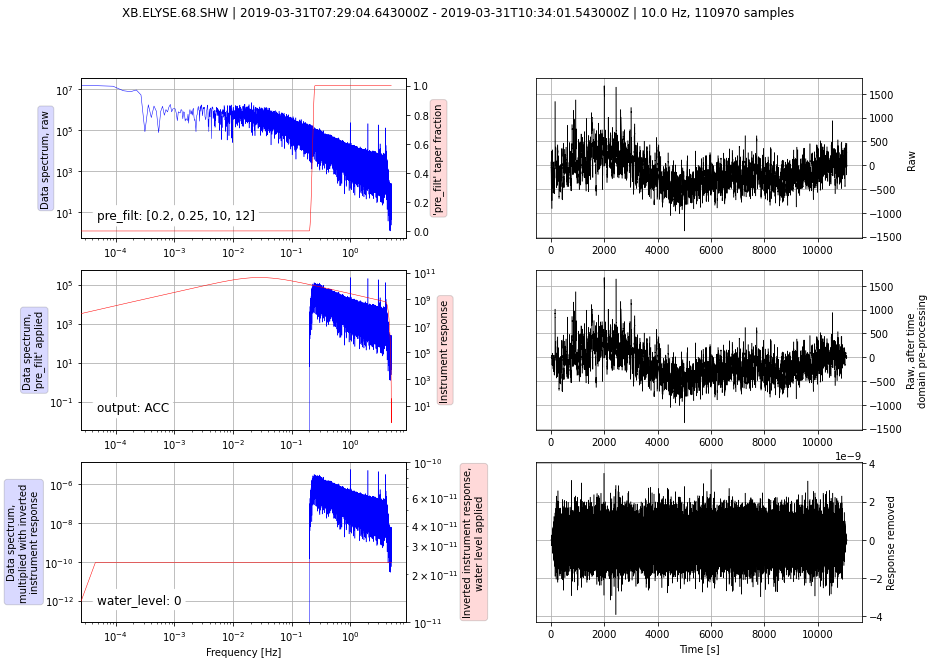

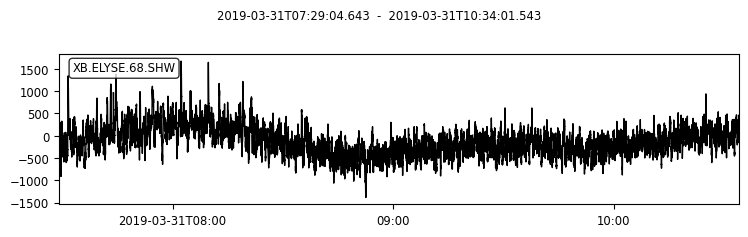

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 10.4999995 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


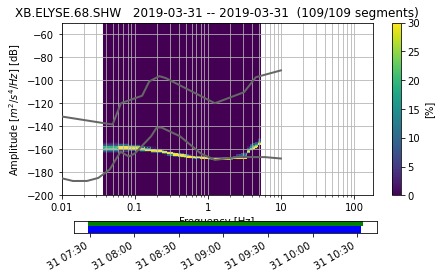

In [37]:
# Mars noise during a really quiet time 

inv_name_mars =  'files/XB.ELYSE_March2019.xml'
seismograms = [['files/fdsnws_msds.mseed','SHW']]

view_seismograms_mars(seismograms=seismograms,inv_name=inv_name_mars, starttime=UTCDateTime('2019-03-31T07:29:04.674897Z'),
          endtime=UTCDateTime('2019-03-31T10:34:01.580416Z'), xaxis_frequency=True,yaxis_db=True,
  plot_waveform=True,plot_instrument_removal=True,plot_ppsd=True)


         network: XB
         station: CRUI1
        location: 65
         channel: EHW
       starttime: 2018-07-16T15:44:56.062000Z
         endtime: 2018-07-16T15:55:20.052000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 62400
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'R', 'number_of_records': 185, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 1414144})
      processing: ['ObsPy 1.2.2: split()']
        response: Channel Response
	From M/S (VELOCITY in Meters Per Second) to COUNTS ()
	Overall Sensitivity: 1.64417e+10 defined at 0.100 Hz
	5 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 24500
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 671088
		Stage 3: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 4: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: FIRResponseStage from COUNTS to COUNTS, gain: 1


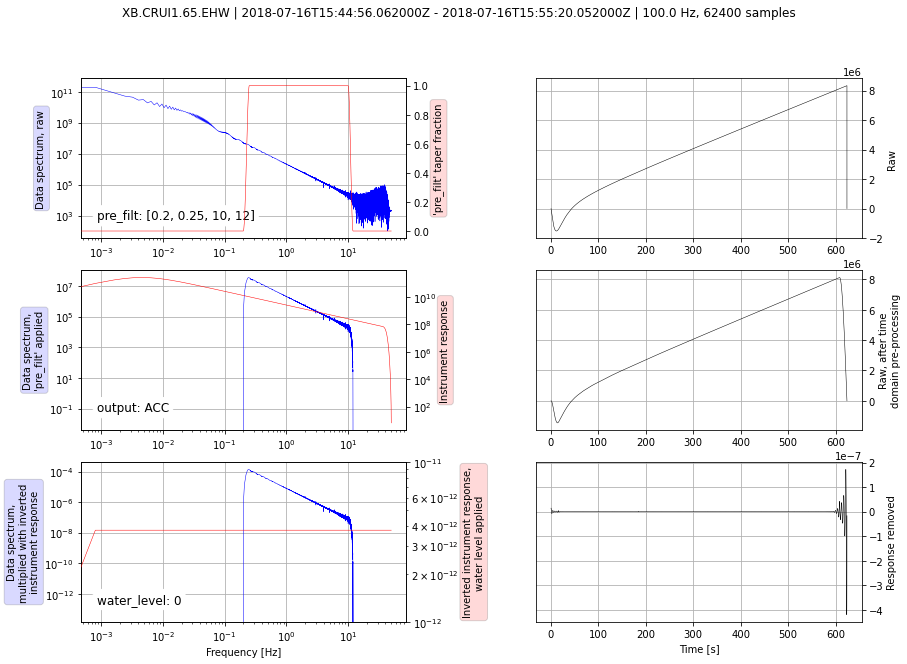

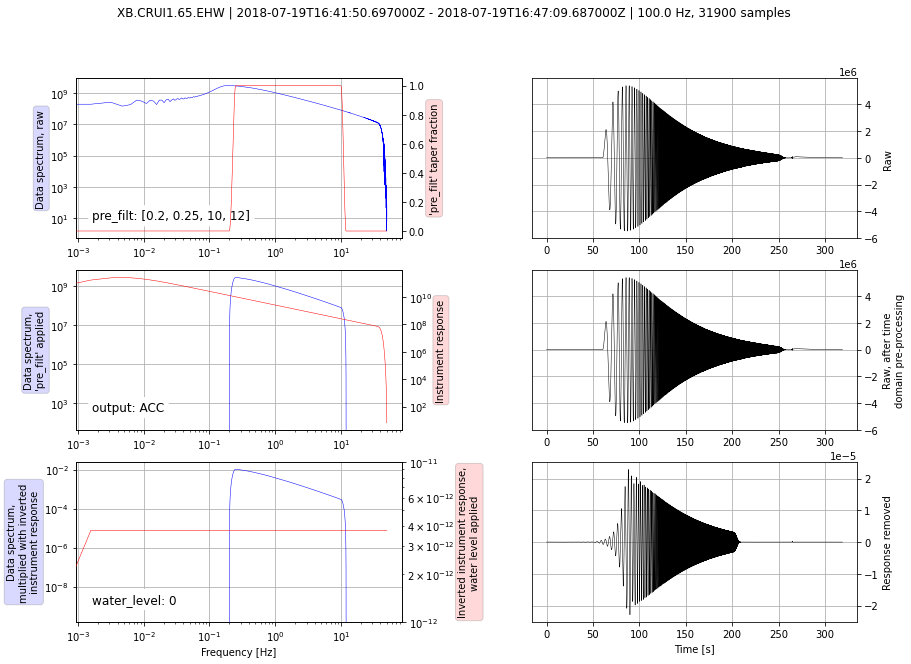

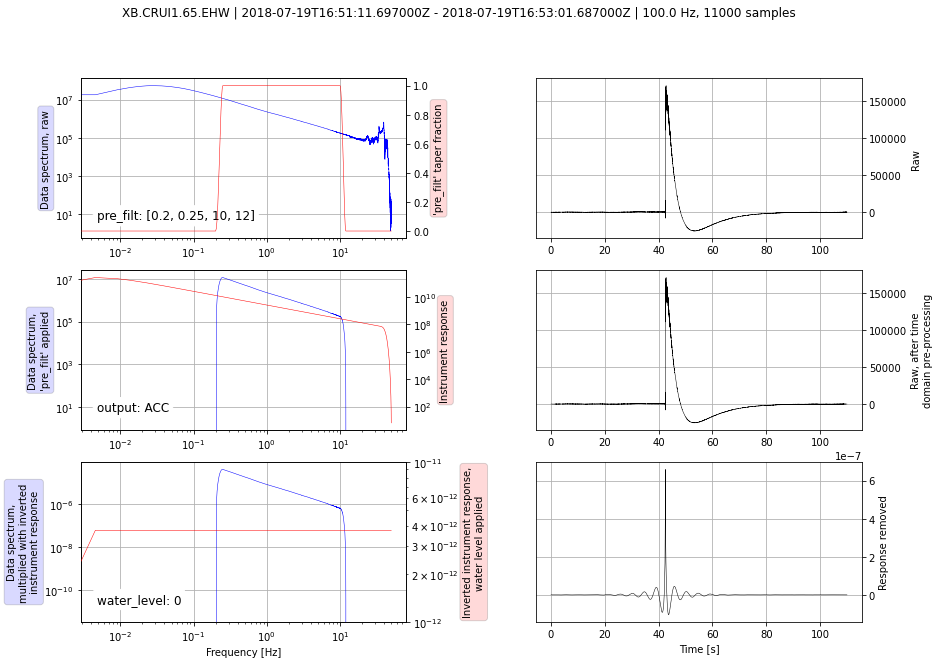

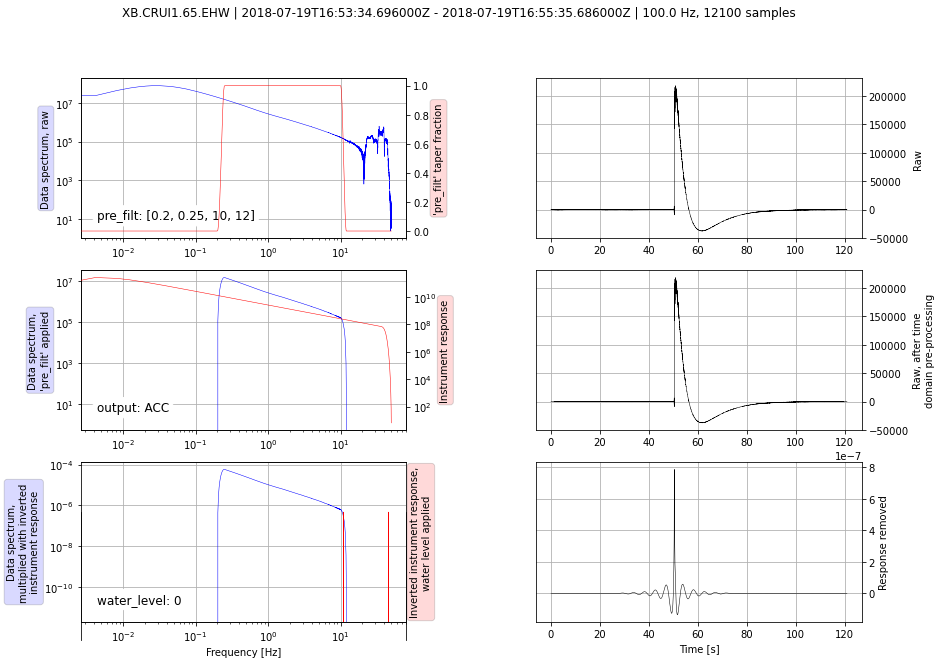

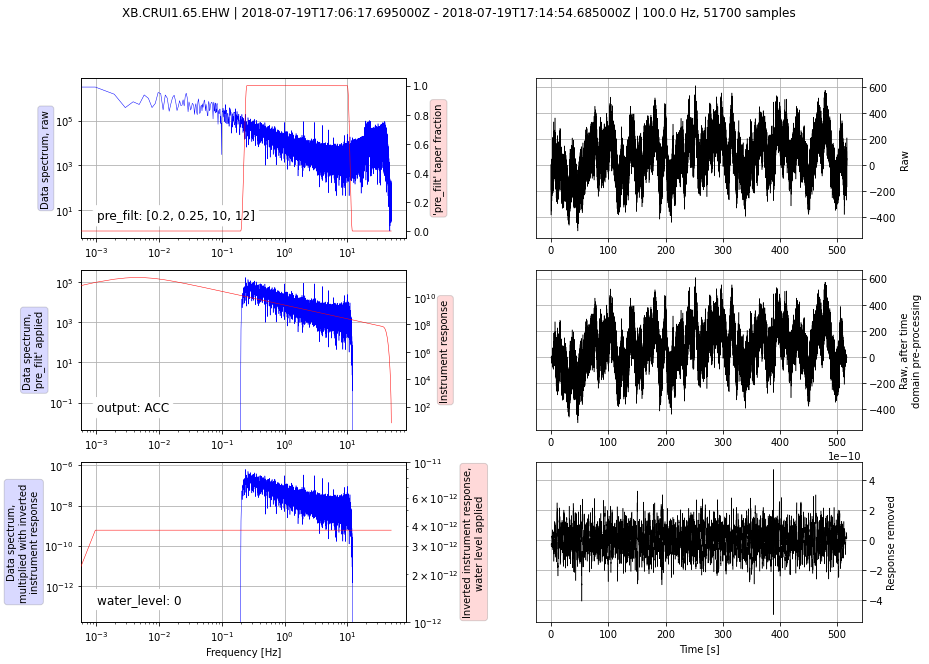

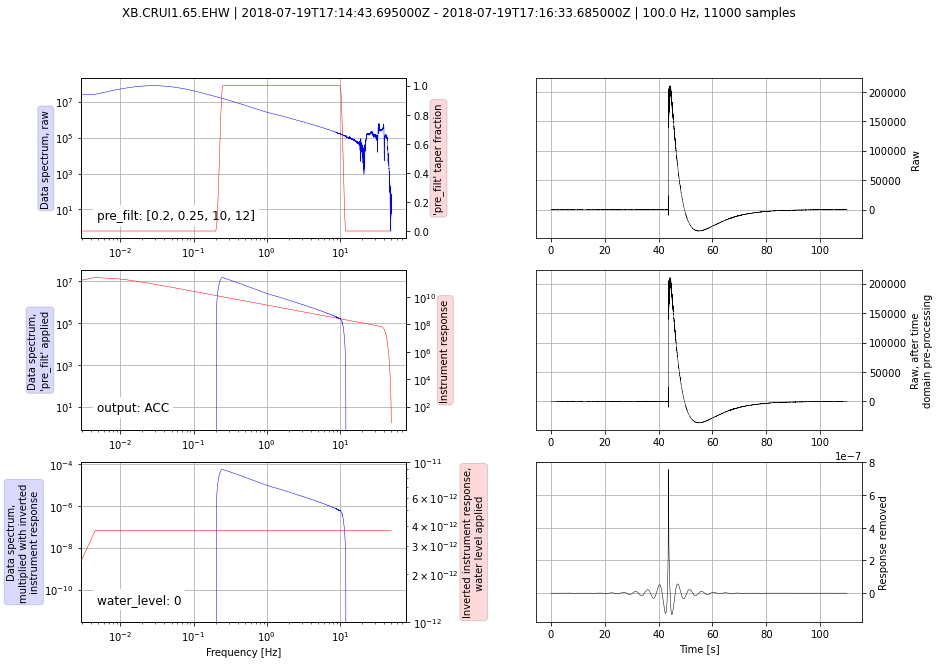

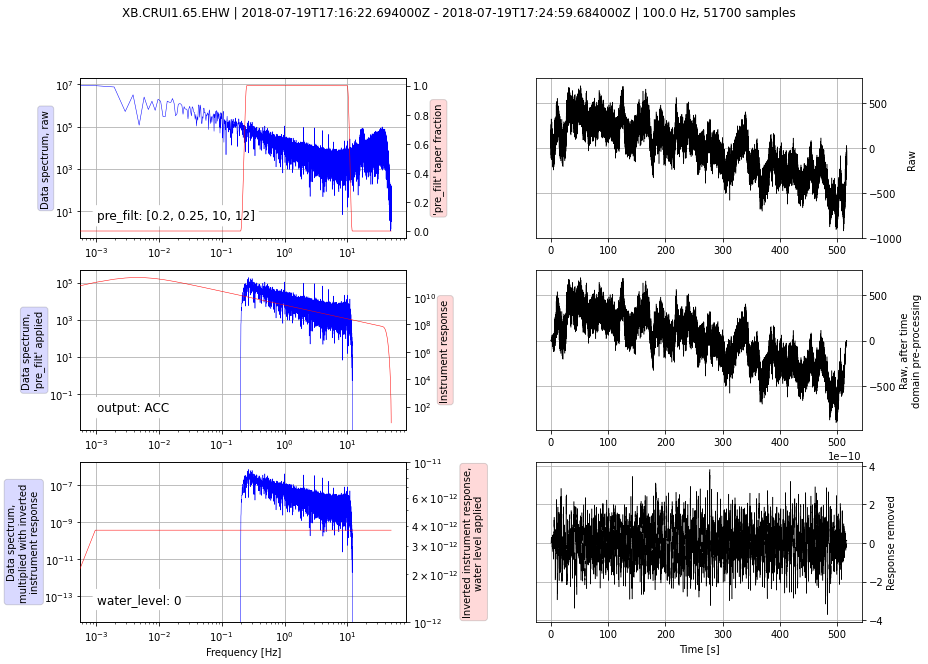

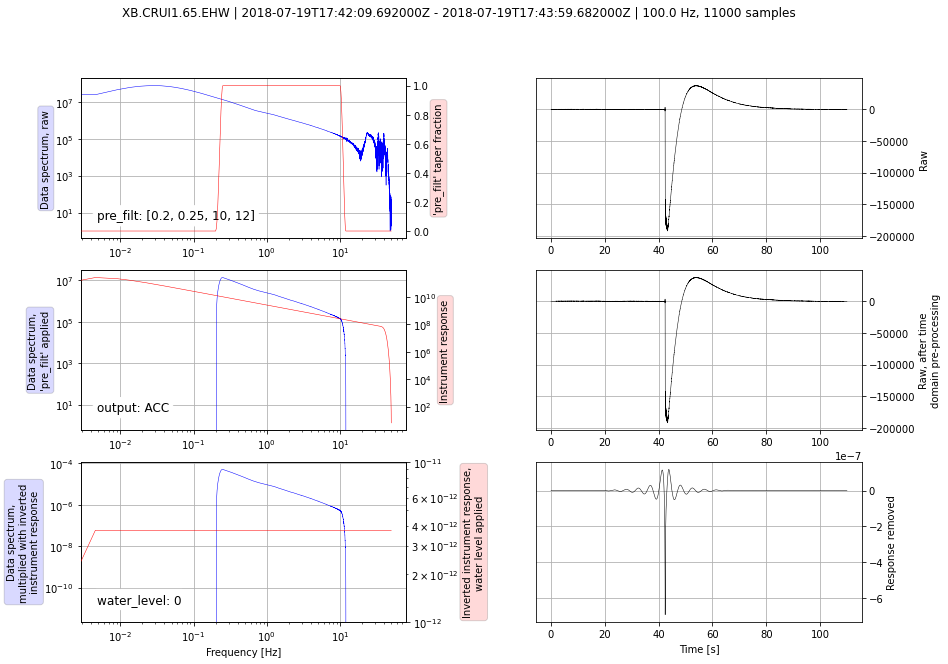

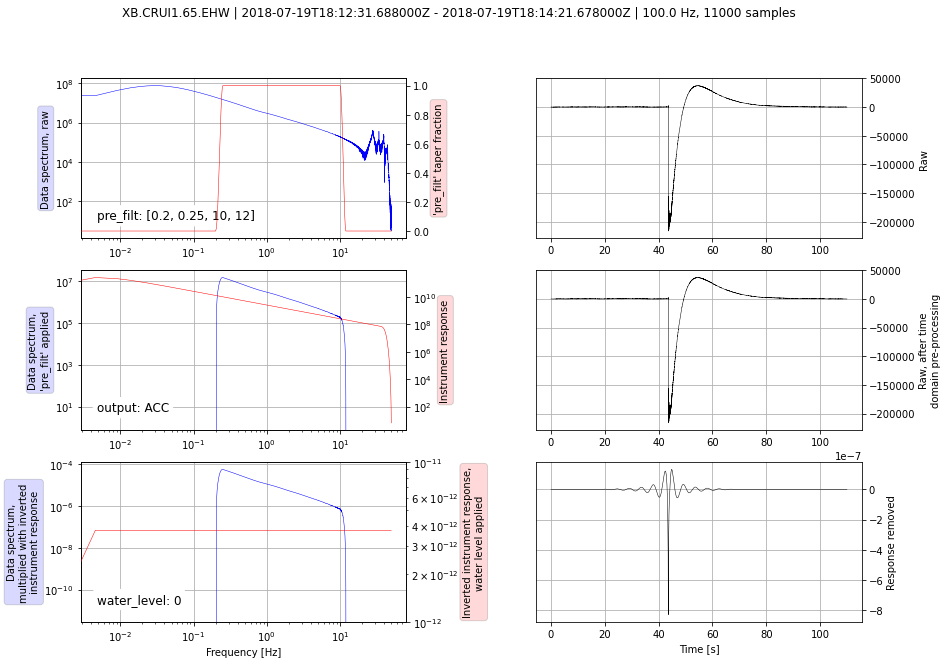

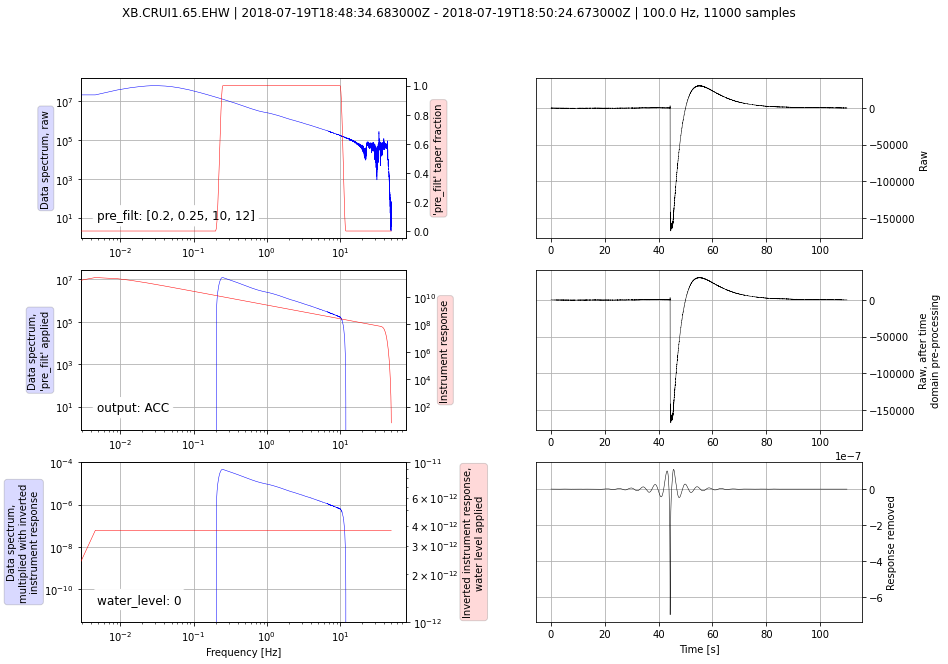

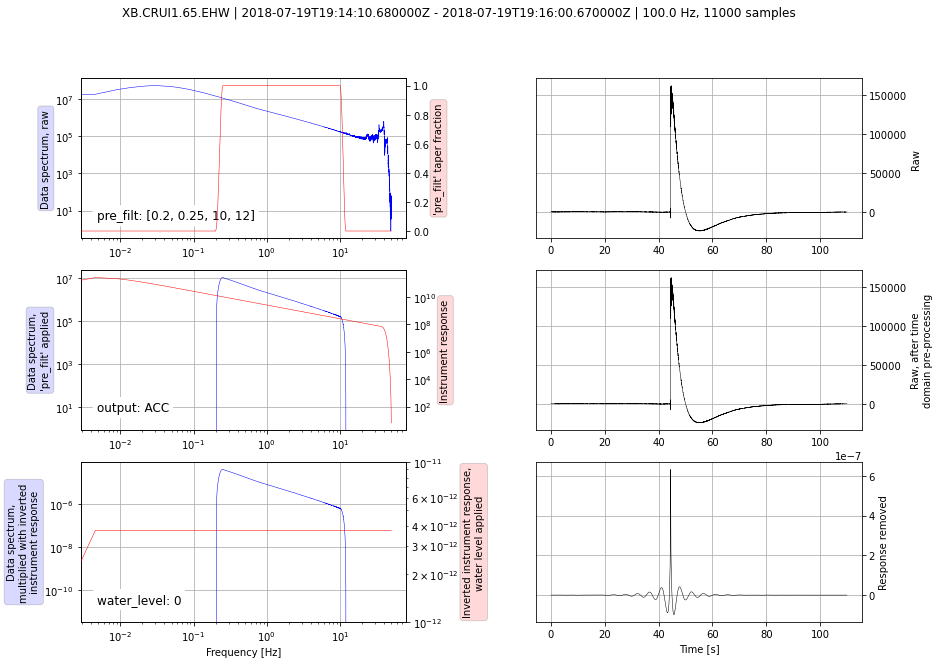

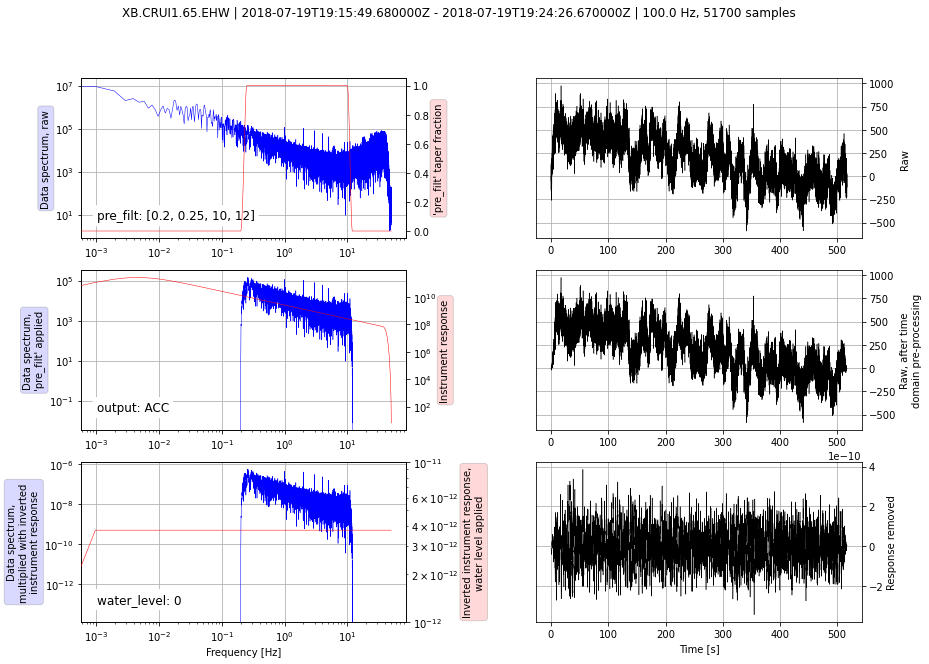

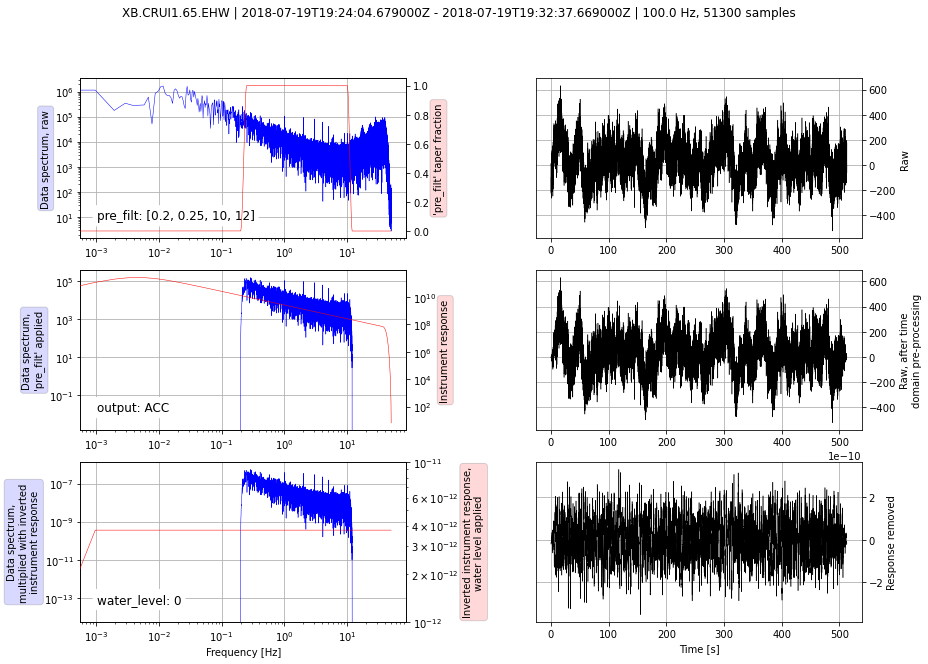

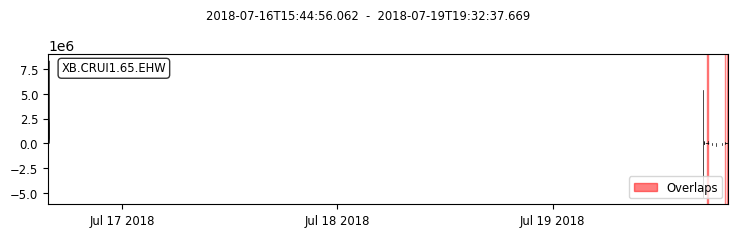

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.invert_xaxis()
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:2028: UserWarning: Attempting to set identical left == right == 52.49999950000001 results in singular transformations; automatically expanding.
  ax.invert_xaxis()


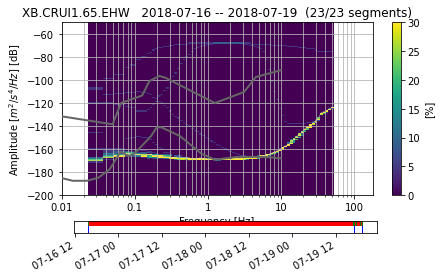

In [38]:
inv_name_cruise =  'files/CRUI1.xml'
seismograms = [['files/CRUI1-2.mseed','EHW']]
view_seismograms_mars(seismograms=seismograms,inv_name=inv_name_cruise, xaxis_frequency=True,yaxis_db=True,
  plot_waveform=True,plot_instrument_removal=True,plot_ppsd=True)

# view_Mars_instrument_resp(seismograms, inv_name, 
#   xaxis_frequency=True,yaxis_db=True,
#   plot_waveform=False,plot_instrument_removal=False,plot_ppsd=True)

In [39]:
print('End of Notebook')

End of Notebook
